**CWRU Dataset Information**

Drive End Bearing

Sampling frequency - 12,000 samples/sec

1HP Motor with 1772rpm

**File Name - Fault type - Fault Dia - Class**

98.mat - Normal baseline data - Class 0

106.mat - Inner race - 0.007in - Class 1

119.mat - Ball - 0.007in - Class 4

131.mat - Outerrace - centered @6.00 - 0.007in fltdia - Class 7

170.mat - Inner race - 0.014in - Class 2

186.mat - Ball - 0.014in - Class 5

198.mat - Outerrace - centered @6.00 - 0.014in fltdia - Class 8

210.mat - Inner race - 0.021in - Class 3

223.mat - Ball - 0.021in - Class 6

235.mat - Outerrace - centered @6.00 - 0.021in fltdia - Class 9

**Load necessary packages and libraries**

In [78]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Flatten, Dense, Softmax
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (confusion_matrix, classification_report, precision_score, f1_score, roc_curve, auc, precision_recall_curve, recall_score)
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import time
import pickle
from math import pi

**Import Data**

In [15]:
def ImportData():
  X98_normal = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\CWRU\Data/98.mat')['X098_DE_time']
  X106_InnerRace_007 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Data/106.mat')['X106_DE_time']
  X119_Ball_007 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Data/119.mat')['X119_DE_time']
  X131_Outer_007 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Data/131.mat')['X131_DE_time']
  X170_InnerRace_014 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Data/170.mat')['X170_DE_time']
  X186_Ball_014 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Data/186.mat')['X186_DE_time']
  X198_Outer_014 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Data/198.mat')['X198_DE_time']
  X210_InnerRace_021 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Data/210.mat')['X210_DE_time']
  X223_Ball_021 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Data/223.mat')['X223_DE_time']
  X235_Outer_021 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Data/235.mat')['X235_DE_time']
  return [X98_normal,X106_InnerRace_007,X119_Ball_007,X131_Outer_007,X170_InnerRace_014,X186_Ball_014,X198_Outer_014,X210_InnerRace_021,X223_Ball_021,X235_Outer_021]


def Sampling(Data, interval_length, samples_per_block):
  # Calculate the number of blocks that can be sampled based on the interval length
  No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length)-1)
  SplitData = np.zeros([No_of_blocks, samples_per_block])
  for i in range(No_of_blocks):
    SplitData[i,:] = (Data[i*interval_length:(i*interval_length)+samples_per_block]).T
  return SplitData


def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block)
    y = np.zeros([len(SplitData),10])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1])
    y1[:,0] = count
    # Stack up and label the data
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  return X, LabelPositional, Label


Data = ImportData()
interval_length = 200
samples_per_block = 2000


# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs,
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block)


print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

Shape of Input Data = (7797, 2000)
Shape of Label Y_CNN = (7797, 10)
Shape of Label Y = (7797, 1)


**K-Fold Cross Validation**

In [16]:
# k-fold cross validation
kSplits = 5
kfold = KFold(n_splits=kSplits, random_state=32, shuffle=True)

**Random Forest Classification Model**

In [17]:
start_time = time.time()
# Reshape the data - 1 dimensional feed
Input_1D = X.reshape([-1,2000,1])

# Test-Train Split
X_1D_train, X_1D_test, y_1D_train, y_1D_test = train_test_split(Input_1D, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)
# Random Forest Classifier
a_rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
a_rf_model.fit(X_1D_train.reshape(len(X_1D_train), -1), np.argmax(y_1D_train, axis=1))

a_rf_train_accuracy = a_rf_model.score(X_1D_train.reshape(len(X_1D_train), -1), np.argmax(y_1D_train, axis=1)) * 100
a_rf_test_accuracy = a_rf_model.score(X_1D_test.reshape(len(X_1D_test), -1), np.argmax(y_1D_test, axis=1)) * 100

print('Random Forest train accuracy - CWRU =', a_rf_train_accuracy)
print('Random Forest test accuracy - CWRU =', a_rf_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(a_rf_model, open(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Models/a_rf_model', 'wb'))

Random Forest train accuracy - CWRU = 84.81272447408928
Random Forest test accuracy - CWRU = 66.97435897435898
Training time: 17.03 seconds


**Calculation of Performance metrics**

In [18]:
# Predict on test data
y_pred = a_rf_model.predict(X_1D_test.reshape(len(X_1D_test), -1))
y_true = np.argmax(y_1D_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_pred_proba = a_rf_model.predict_proba(X_1D_test.reshape(len(X_1D_test), -1))
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
rf_train_pred = a_rf_model.predict(X_1D_train.reshape(len(X_1D_train), -1))
rf_train_cm = confusion_matrix(np.argmax(y_1D_train, axis=1), rf_train_pred)
rf_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for Random Forest - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [a_rf_train_accuracy, a_rf_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
a_rf_train_accuracy = a_rf_train_accuracy
a_rf_test_accuracy = a_rf_test_accuracy
a_rf_recall_avg = recall_avg
a_rf_precision_avg = precision_avg
a_rf_f1_avg = f1_avg
a_rf_roc_auc = roc_auc

metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for Random Forest - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

Class-wise Metrics for Random Forest - CWRU:
Class Label     Recall  Precision  F1-Score
    Class 0 100.000000  50.798991 67.373118
    Class 1  95.172414  91.390728 93.243243
    Class 2  48.648649  91.139241 63.436123
    Class 3  98.850575  93.989071 96.358543
    Class 4   1.923077  60.000000  3.726708
    Class 5  37.931034  87.301587 52.884615
    Class 6   0.000000   0.000000  0.000000
    Class 7  96.688742  96.688742 96.688742
    Class 8   2.158273  37.500000  4.081633
    Class 9  81.884058  94.166667 87.596899
    Average  56.325682  70.297503 56.538962

Overall Performance Metrics for Random Forest - CWRU:
           Metric     Value
   Train Accuracy 84.812724
    Test Accuracy 66.974359
   Average Recall 56.325682
Average Precision 70.297503
 Average F1-Score 56.538962
          ROC AUC  0.964721


**Plot results - RF Model**

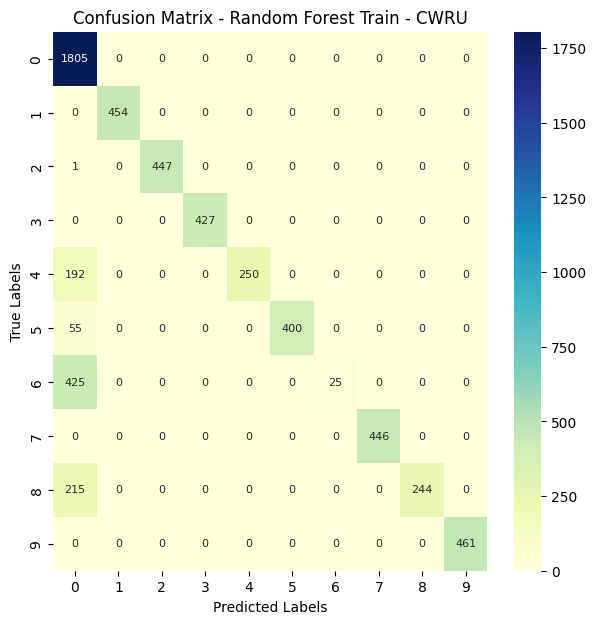

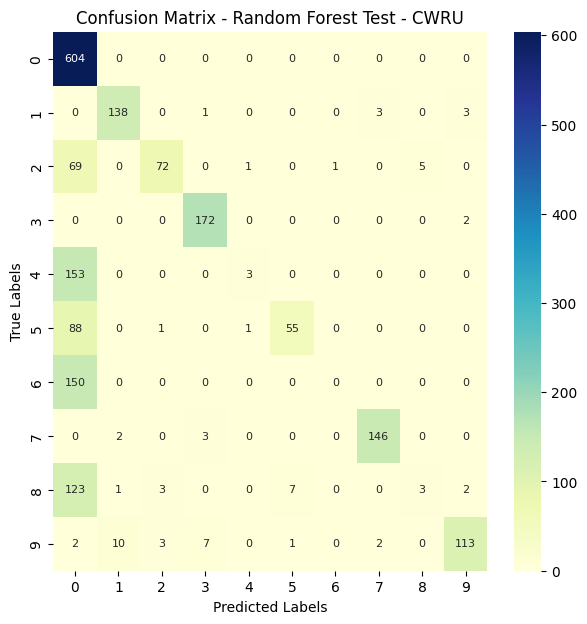

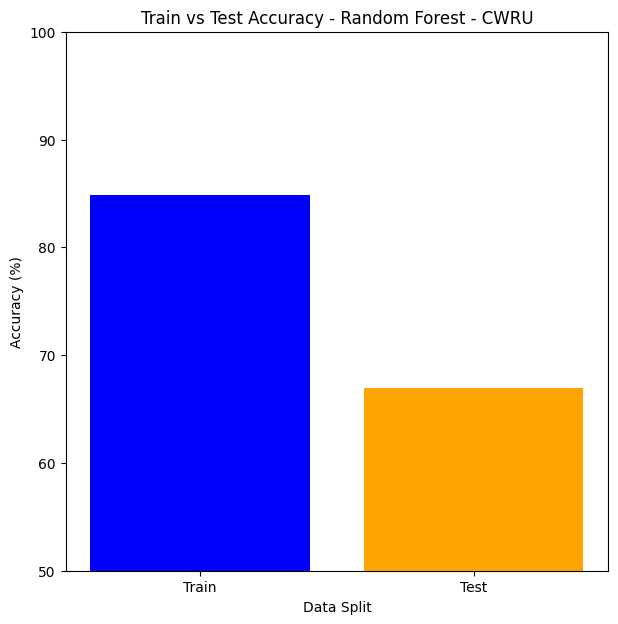

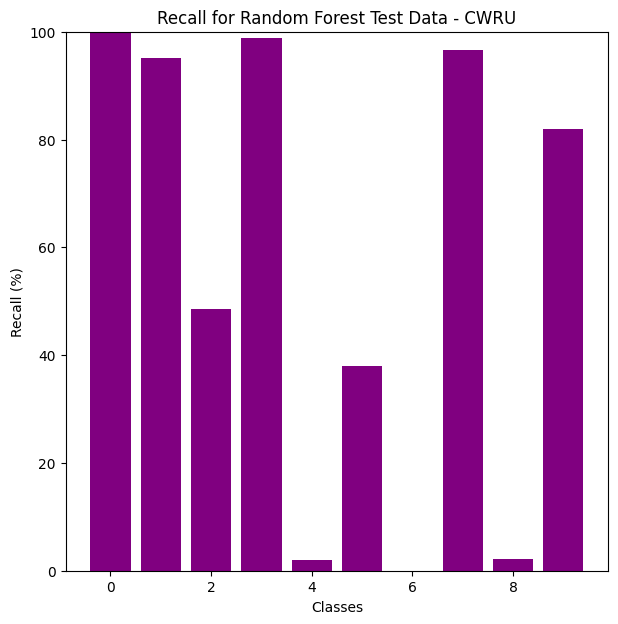

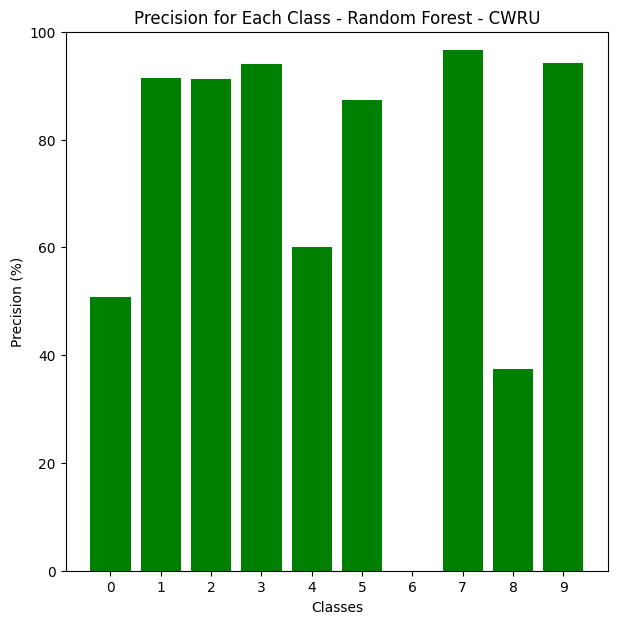

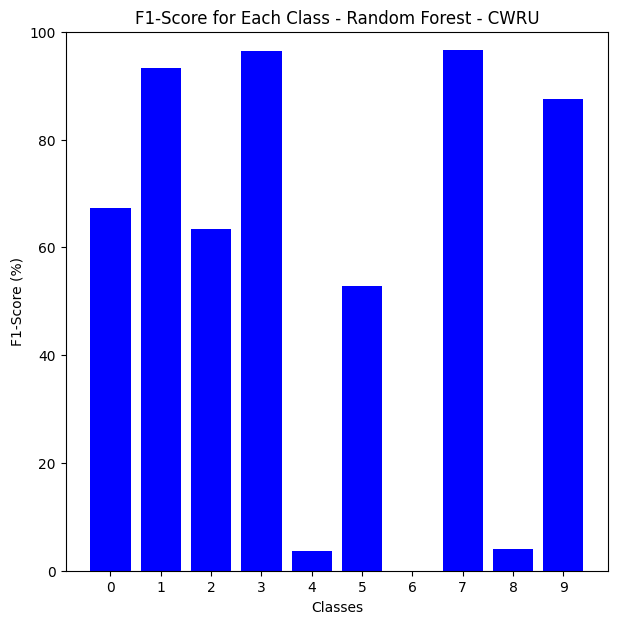

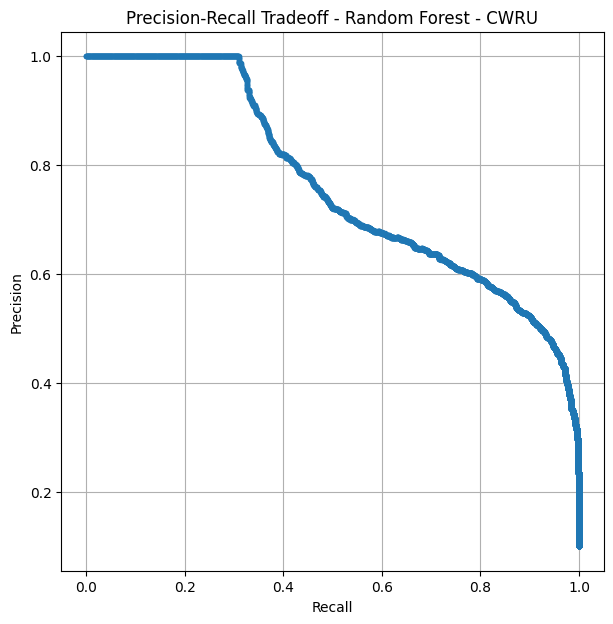

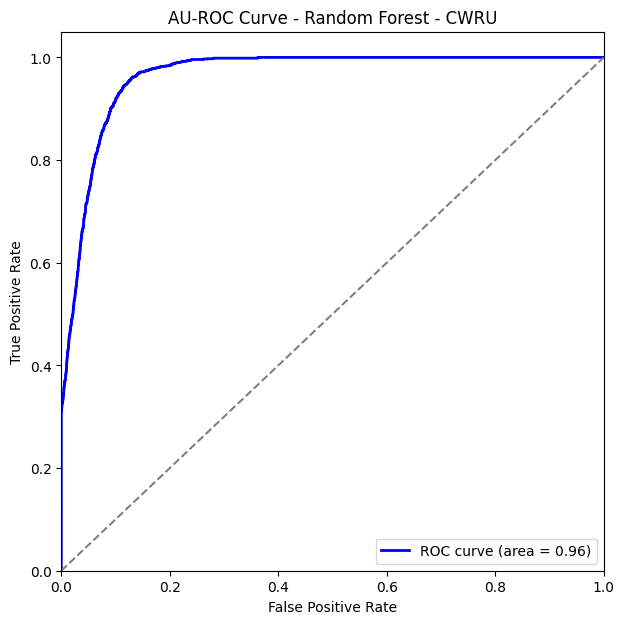

In [19]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - Random Forest Train - CWRU')
sns.heatmap(rf_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - Random Forest Test - CWRU')
sns.heatmap(rf_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - Random Forest'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - Random Forest - CWRU')
plt.bar([1, 2], [a_rf_train_accuracy, a_rf_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plotting 'Recall for Random Forest Test Data'
plt.figure(figsize=(7, 7))
plt.title('Recall for Random Forest Test Data - CWRU')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - Random Forest - CWRU')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - Random Forest - CWRU')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - Random Forest - CWRU')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - Random Forest - CWRU')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Gradient Boosting Classification Model**

In [20]:
start_time = time.time()
# Reshape the data - 1 dimensional feed
Input_1D = X.reshape([-1,2000,1])
# Gradient Boosting Classifier
a_gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
a_gb_model.fit(X_1D_train.reshape(len(X_1D_train), -1), np.argmax(y_1D_train, axis=1))

a_gb_train_accuracy = a_gb_model.score(X_1D_train.reshape(len(X_1D_train), -1), np.argmax(y_1D_train, axis=1)) * 100
a_gb_test_accuracy = a_gb_model.score(X_1D_test.reshape(len(X_1D_test), -1), np.argmax(y_1D_test, axis=1)) * 100

print('Gradient Boosting train accuracy - CWRU =', a_gb_train_accuracy)
print('Gradient Boosting test accuracy - CWRU =', a_gb_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(a_gb_model, open(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Models/a_gb_model', 'wb'))

Gradient Boosting train accuracy - CWRU = 100.0
Gradient Boosting test accuracy - CWRU = 92.0
Training time: 3194.92 seconds


**Calculation of Performance metrics**

In [21]:
# Predict on test data
y_pred = a_gb_model.predict(X_1D_test.reshape(len(X_1D_test), -1))
y_true = np.argmax(y_1D_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_pred_proba = a_gb_model.predict_proba(X_1D_test.reshape(len(X_1D_test), -1))
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
gb_train_pred = a_gb_model.predict(X_1D_train.reshape(len(X_1D_train), -1))
gb_train_cm = confusion_matrix(np.argmax(y_1D_train, axis=1), gb_train_pred)
gb_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for Gradient Boosting - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [a_gb_train_accuracy, a_gb_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
a_gb_train_accuracy = a_gb_train_accuracy
a_gb_test_accuracy = a_gb_test_accuracy
a_gb_recall_avg = recall_avg
a_gb_precision_avg = precision_avg
a_gb_f1_avg = f1_avg
a_gb_roc_auc = roc_auc

metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for Gradient Boosting - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

Class-wise Metrics for Gradient Boosting - CWRU:
Class Label     Recall  Precision   F1-Score
    Class 0 100.000000 100.000000 100.000000
    Class 1  97.241379  95.918367  96.575342
    Class 2  83.783784  77.987421  80.781759
    Class 3  81.609195  95.945946  88.198758
    Class 4  90.384615  88.125000  89.240506
    Class 5  92.413793  95.035461  93.706294
    Class 6  94.000000  89.808917  91.856678
    Class 7  96.688742  98.648649  97.658863
    Class 8  79.136691  76.923077  78.014184
    Class 9  80.434783  77.622378  79.003559
    Average  89.569298  89.601522  89.503594

Overall Performance Metrics for Gradient Boosting - CWRU:
           Metric      Value
   Train Accuracy 100.000000
    Test Accuracy  92.000000
   Average Recall  89.569298
Average Precision  89.601522
 Average F1-Score  89.503594
          ROC AUC   0.996150


**Plot results - GB Model**

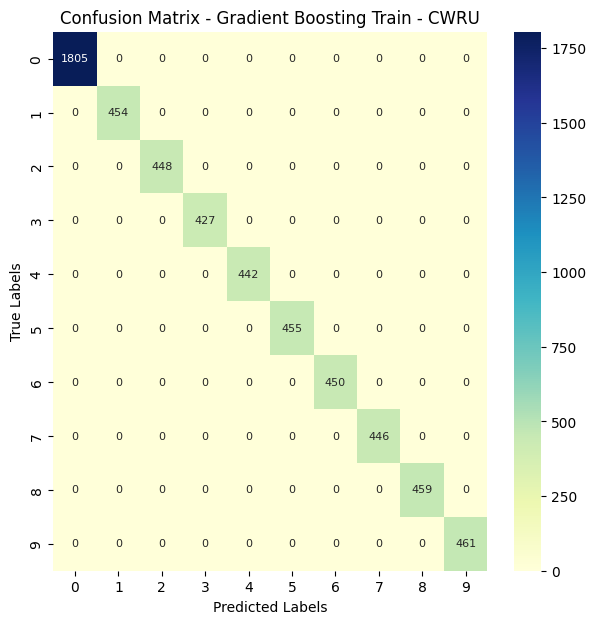

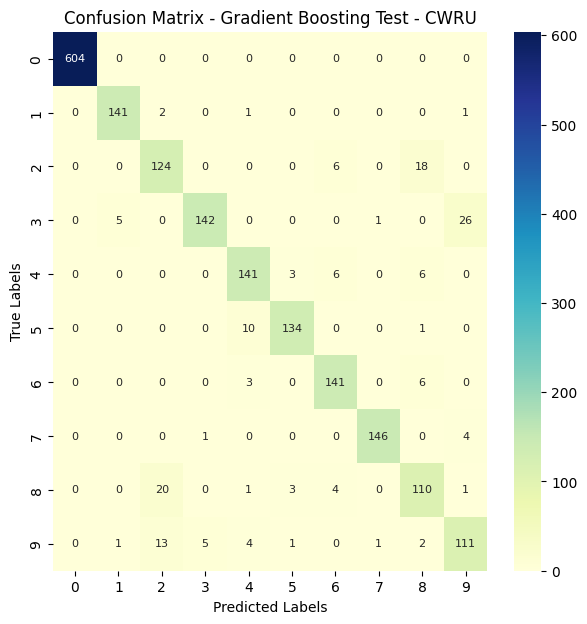

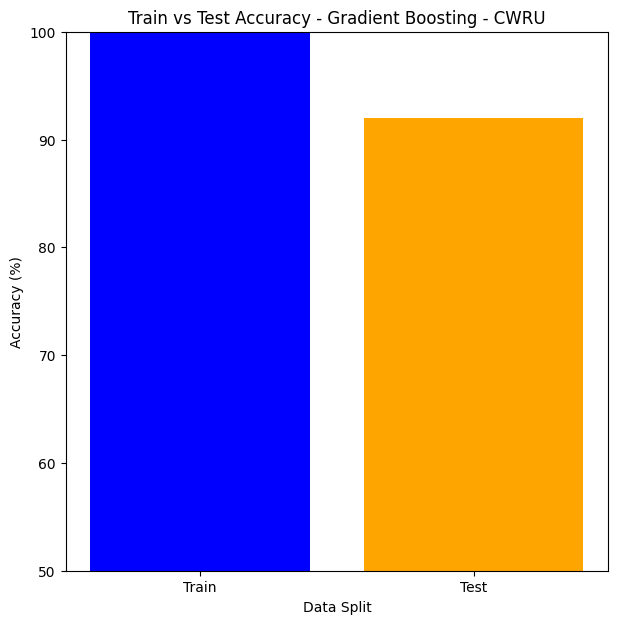

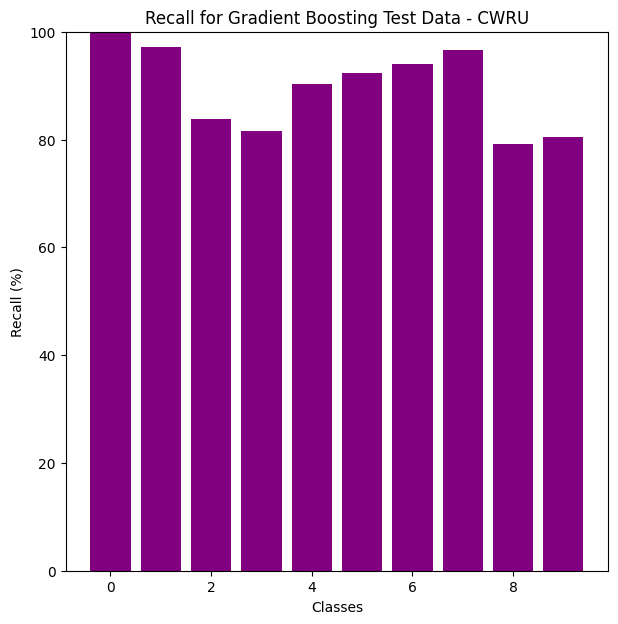

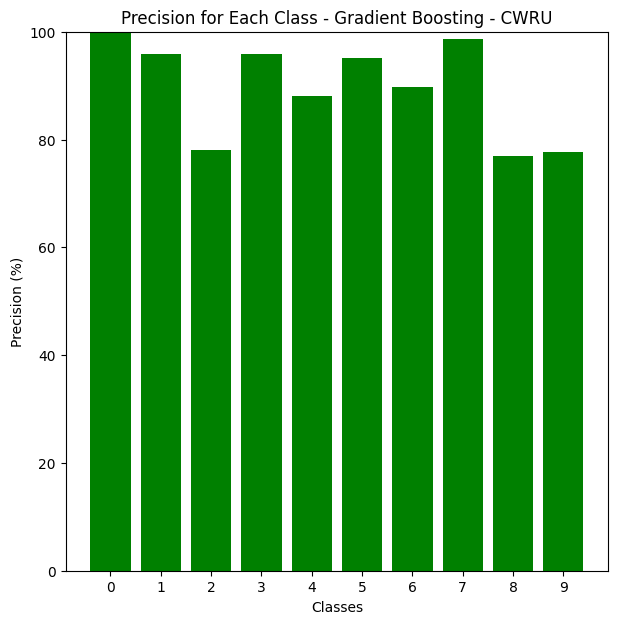

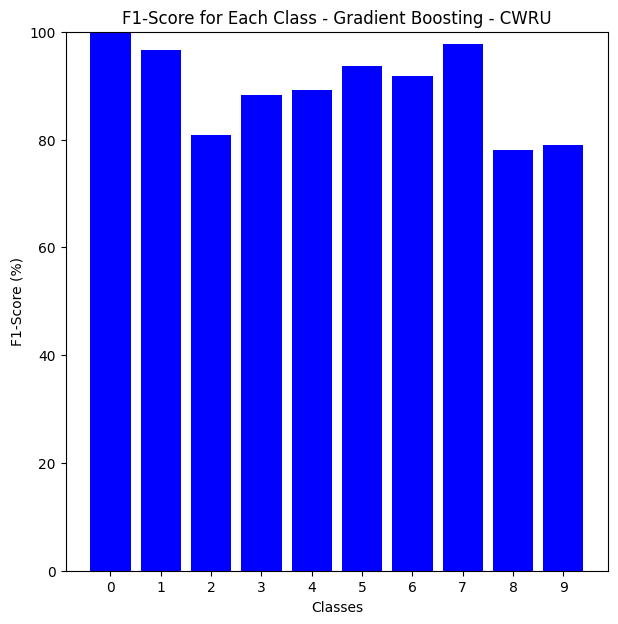

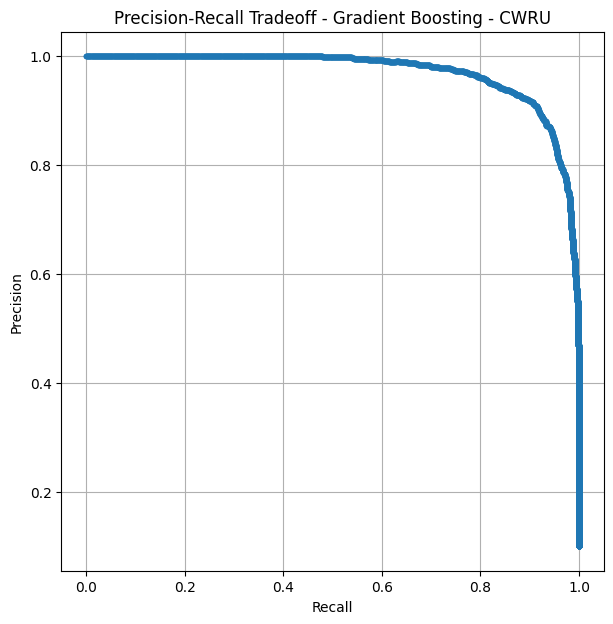

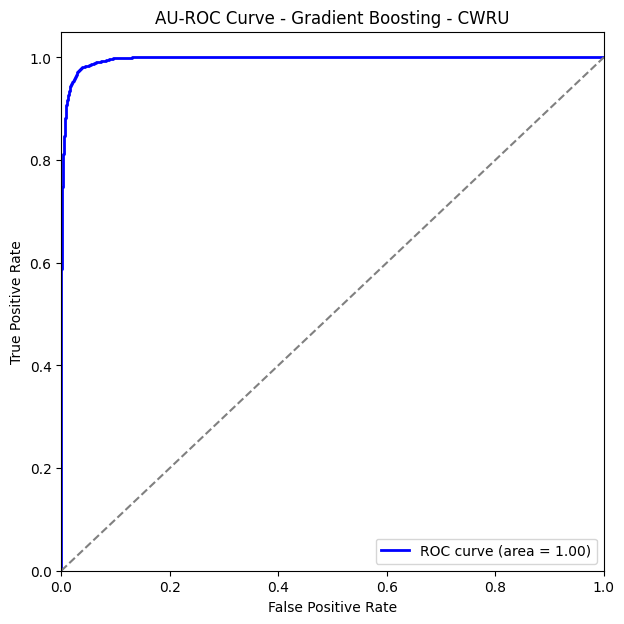

In [22]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - Gradient Boosting Train - CWRU')
sns.heatmap(gb_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - Gradient Boosting Test - CWRU')
sns.heatmap(gb_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - Gradient Boosting'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - Gradient Boosting - CWRU')
plt.bar([1, 2], [a_gb_train_accuracy, a_gb_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plotting 'Recall for Gradient Boosting Test Data'
plt.figure(figsize=(7, 7))
plt.title('Recall for Gradient Boosting Test Data - CWRU')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - Gradient Boosting - CWRU')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - Gradient Boosting - CWRU')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - Gradient Boosting - CWRU')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - Gradient Boosting - CWRU')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Recurrent Neural Network Classification Model**

In [23]:
start_time = time.time()
# Reshape the data - 1 dimensional feed
Input = X.reshape([-1,2000,1])

# Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(Input, Y_CNN, train_size=0.75, test_size=0.25, random_state=101)

# Define the RNN Classification model
class a_RNN_Model():
    def __init__(self):
        self.model = self.CreateModel()

    def CreateModel(self):
        model = models.Sequential([
            layers.SimpleRNN(32, return_sequences=True),
            layers.Flatten(),
            layers.Dense(10),
            layers.Softmax()
        ])
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model

# Initialize KFold for cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=101)
accuracy_rnn = []

# Train the RNN model
for train_idx, test_idx in kfold.split(X_train, y_train):
    Classification_a_rnn = a_RNN_Model()
    history = Classification_a_rnn.model.fit(X_train[train_idx], y_train[train_idx], verbose=1, epochs=10)

    # Evaluate the accuracy of the model on the validation set
    kf_loss, kf_accuracy = Classification_a_rnn.model.evaluate(X_train[test_idx], y_train[test_idx])
    accuracy_rnn.append(kf_accuracy)

# Train Accuracy
a_RNN_train_accuracy = np.average(accuracy_rnn) * 100
print('RNN train accuracy - CWRU =', a_RNN_train_accuracy)

# Evaluate the accuracy of the model on the test set
RNN_test_loss, a_RNN_test_accuracy = Classification_a_rnn.model.evaluate(X_test, y_test)
a_RNN_test_accuracy *= 100
print('RNN test accuracy - CWRU =', a_RNN_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(Classification_a_rnn.model, open(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Models/a_rnn_model', 'wb'))

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 256ms/step - accuracy: 0.5447 - loss: 2.0511
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 33s 227ms/step - accuracy: 0.7792 - loss: 0.7867
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 33s 225ms/step - accuracy: 0.8359 - loss: 0.5263
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 33s 222ms/step - accuracy: 0.8928 - loss: 0.3311
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - accuracy: 0.8850 - loss: 0.3581
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 231ms/step - accuracy: 0.9111 - loss: 0.2728
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.9062 - loss: 0.2956
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 234ms/step - accuracy: 0.9743 - loss: 0.0756
Epoch 9/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 234ms/step - accuracy: 0.9784 - loss: 0.0619
Epoch 10/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 234ms/step - accuracy: 0.9475 - loss: 0.1870
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8020 - loss: 1.0840
Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━

**Calculation of Performance metrics**

In [24]:
# Predict on test data
y_pred_proba = Classification_a_rnn.model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
y_pred_train = np.argmax(Classification_a_rnn.model.predict(X_train), axis=1)
rnn_train_cm = confusion_matrix(np.argmax(y_train, axis=1), y_pred_train)
rnn_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for RNN - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [a_RNN_train_accuracy, a_RNN_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
a_RNN_train_accuracy = a_RNN_train_accuracy
a_RNN_test_accuracy = a_RNN_test_accuracy
a_recall_RNN_avg = recall_avg
a_precision_RNN_avg = precision_avg
a_f1_RNN_avg = f1_avg
a_roc_auc_RNN = roc_auc

metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for RNN - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step
Class-wise Metrics for RNN - CWRU:
Class Label     Recall  Precision  F1-Score
    Class 0  99.668874  99.834163 99.751450
    Class 1  53.793103  52.348993 53.061224
    Class 2  75.675676  77.777778 76.712329
    Class 3  34.482759  45.112782 39.087948
    Class 4  98.076923  77.272727 86.440678
    Class 5 100.000000  96.666667 98.305085
    Class 6  97.333333  78.074866 86.646884
    Class 7  58.278146  54.320988 56.230032
    Class 8  64.028777  69.531250 66.666667
    Class 9  50.000000  71.875000 58.974359
    Average  73.133759  72.281521 72.187666

Overall Performance Metrics for RNN - CWRU:
           Metric     Value
   Train Accuracy 78.194484
    Test Accuracy 79.076922
   Average Recall 73.133759
Average Precision 72.281521
 Average F1-Score 72.187666
          ROC AUC  0.975035


**Plot results - RNN Model**

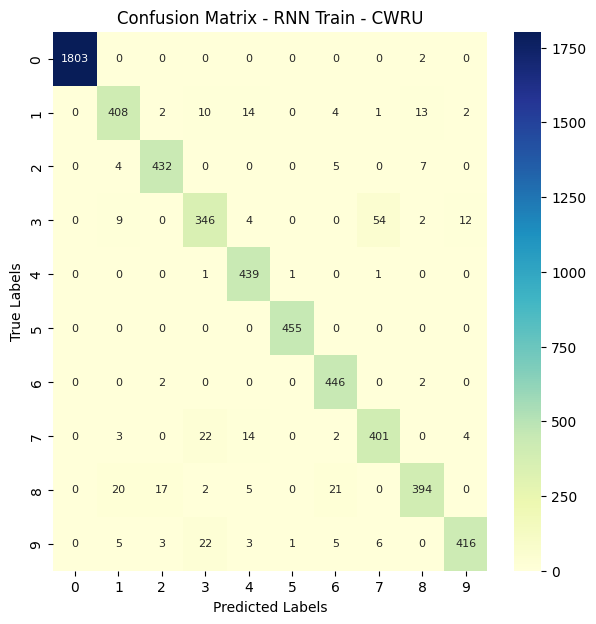

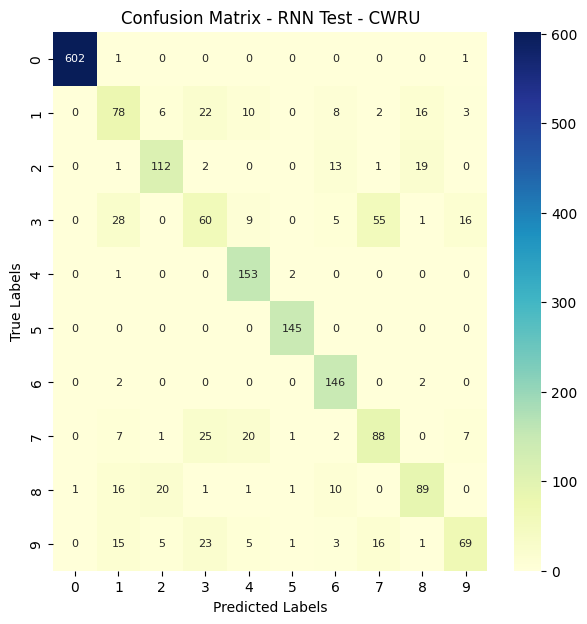

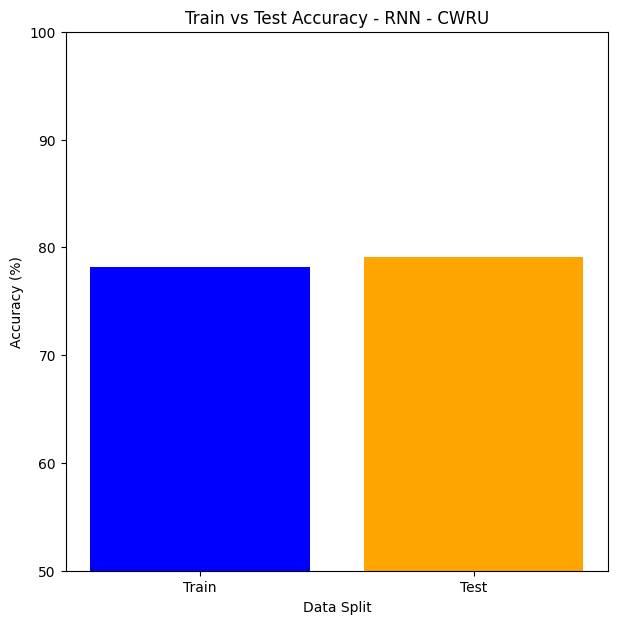

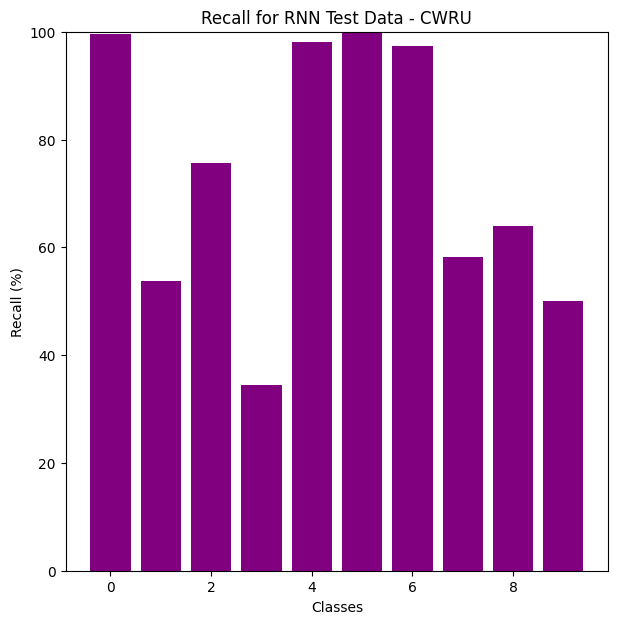

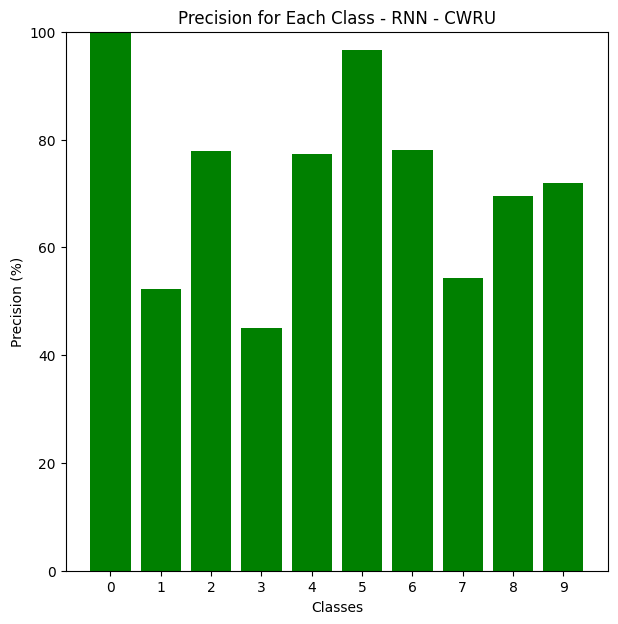

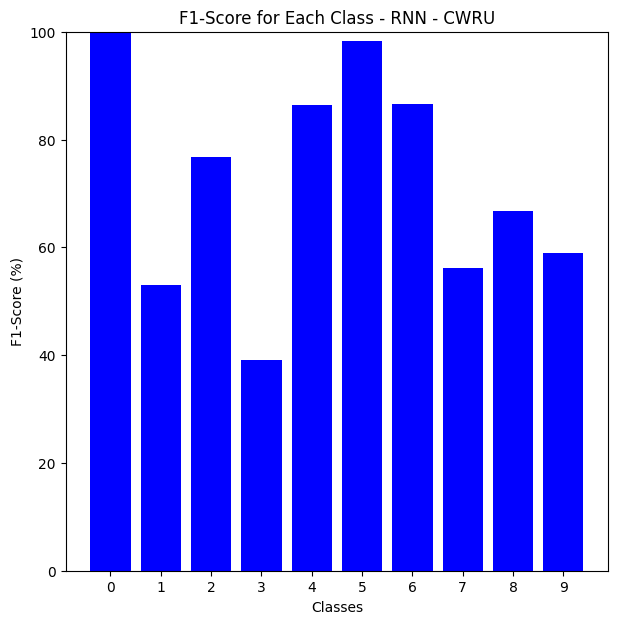

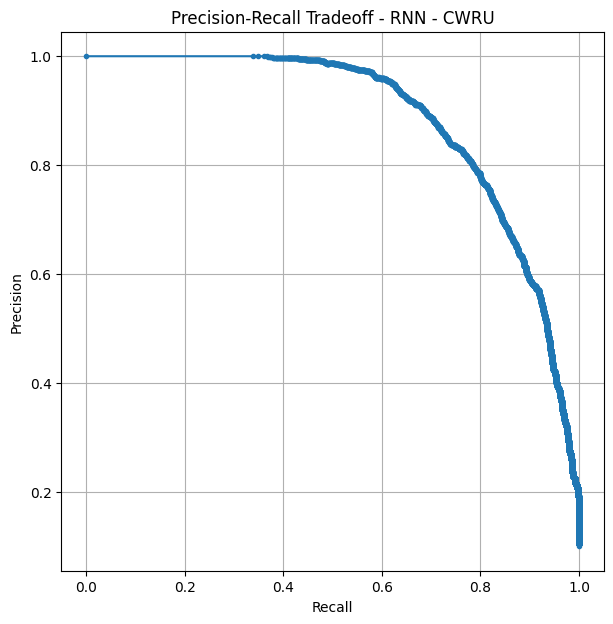

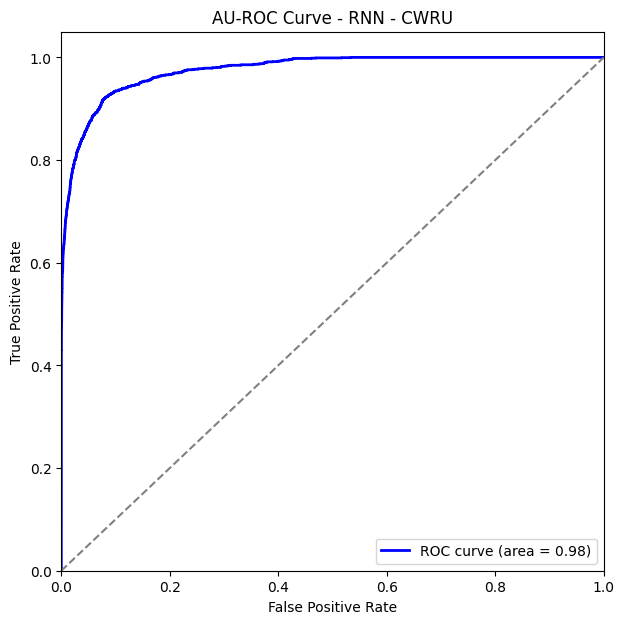

In [25]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - RNN Train - CWRU')
sns.heatmap(rnn_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - RNN Test - CWRU')
sns.heatmap(rnn_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - RNN'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - RNN - CWRU')
plt.bar([1, 2], [a_RNN_train_accuracy, a_RNN_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plotting 'Recall for RNN Test Data'
plt.figure(figsize=(7, 7))
plt.title('Recall for RNN Test Data - CWRU')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - RNN - CWRU')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - RNN - CWRU')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff
# Binarize labels for precision-recall curve
y_test_bin = label_binarize(y_true, classes=range(10))
# Flatten predicted probabilities and true labels
y_pred_proba_flat = y_pred_proba[:, 1]
# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - RNN - CWRU')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - RNN - CWRU')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**1-Dimensional Convolutional Neural Network Classification Model**

In [26]:
start_time = time.time()
# Reshape the data - 1 dimensional feed
Input_1D = X.reshape([-1,2000,1])

# Test-Train Split
X_1D_train, X_1D_test, y_1D_train, y_1D_test = train_test_split(Input_1D, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)

# Define the CNN Classification model
class a_CNN_1D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.Conv1D(filters=16, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=32, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Flatten(),
        #layers.InputLayer(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model


accuracy_1D = []

# Train the model
for train, test in kfold.split(X_1D_train,y_1D_train):
  Classification_a_1D = a_CNN_1D()
  history = Classification_a_1D.model.fit(X_1D_train[train], y_1D_train[train], verbose=1, epochs=12)

  # Evaluate the accuracy of the model on the training set
  kf_loss, kf_accuracy = Classification_a_1D.model.evaluate(X_1D_train[test], y_1D_train[test])
  accuracy_1D.append(kf_accuracy)

a_CNN_1D_train_accuracy = np.average(accuracy_1D)*100
print('CNN 1D train accuracy - CWRU =', a_CNN_1D_train_accuracy)


# Evaluate the accuracy of the model on the test set
CNN_1D_test_loss, a_CNN_1D_test_accuracy = Classification_a_1D.model.evaluate(X_1D_test, y_1D_test)
a_CNN_1D_test_accuracy*=100
print('CNN 1D test accuracy - CWRU =', a_CNN_1D_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(Classification_a_1D.model, open(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Models/a_cnn_1d_model', 'wb'))

Epoch 1/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4225 - loss: 1.6359
Epoch 2/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9018 - loss: 0.2857
Epoch 3/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9607 - loss: 0.1201
Epoch 4/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9578 - loss: 0.1216
Epoch 5/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9666 - loss: 0.0980
Epoch 6/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9855 - loss: 0.0460
Epoch 7/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9917 - loss: 0.0289
Epoch 8/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9482 - loss: 0.1804
Epoch 9/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9940 - loss: 0.0233
Epoch 10/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9911 - loss: 0.0240
Epoch 11/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9675 - loss: 0.1092
Epoch 12/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

**Calculation of Performance metrics**

In [27]:
# Predict on test data
y_pred_proba = Classification_a_1D.model.predict(X_1D_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_1D_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
y_pred_train = np.argmax(Classification_a_1D.model.predict(X_1D_train), axis=1)
cnn_1d_train_cm = confusion_matrix(np.argmax(y_1D_train, axis=1), y_pred_train)
cnn_1d_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for CNN 1D - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [a_CNN_1D_train_accuracy, a_CNN_1D_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
a_CNN_1D_train_accuracy = a_CNN_1D_train_accuracy
a_CNN_1D_test_accuracy = a_CNN_1D_test_accuracy
a_recall_CNN_1D_avg = recall_avg
a_precision_CNN_1D_avg = precision_avg
a_f1_CNN_1D_avg = f1_avg
a_roc_auc_CNN_1D = roc_auc

metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for CNN 1D - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Class-wise Metrics for CNN 1D - CWRU:
Class Label     Recall  Precision   F1-Score
    Class 0 100.000000 100.000000 100.000000
    Class 1 100.000000  98.639456  99.315068
    Class 2 100.000000 100.000000 100.000000
    Class 3 100.000000 100.000000 100.000000
    Class 4 100.000000  98.113208  99.047619
    Class 5  97.241379 100.000000  98.601399
    Class 6 100.000000  99.337748  99.667774
    Class 7 100.000000 100.000000 100.000000
    Class 8  97.122302  98.540146  97.826087
    Class 9 100.000000 100.000000 100.000000
    Average  99.436368  99.463056  99.445795

Overall Performance Metrics for CNN 1D - CWRU:
           Metric     Value
   Train Accuracy 99.264548
    Test Accuracy 99.589741
   Average Recall 99.436368
Average Precision 99.463056
 Average F1-Score 99.445795
          ROC AUC  0.999989


**Plot results - CNN-1D Model**

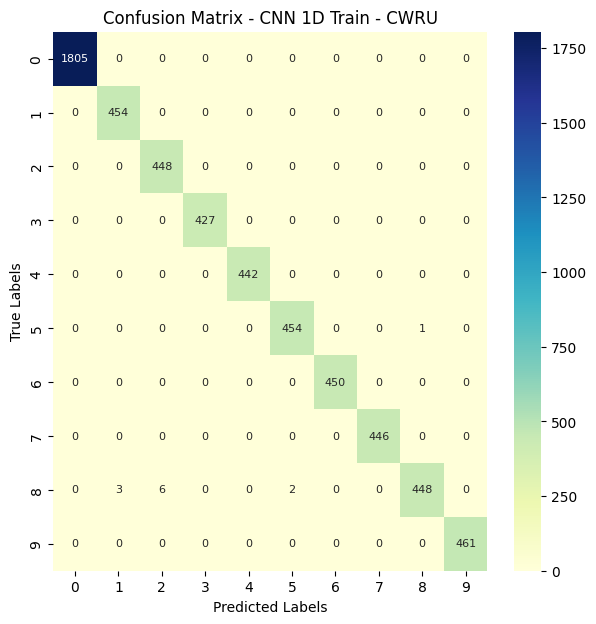

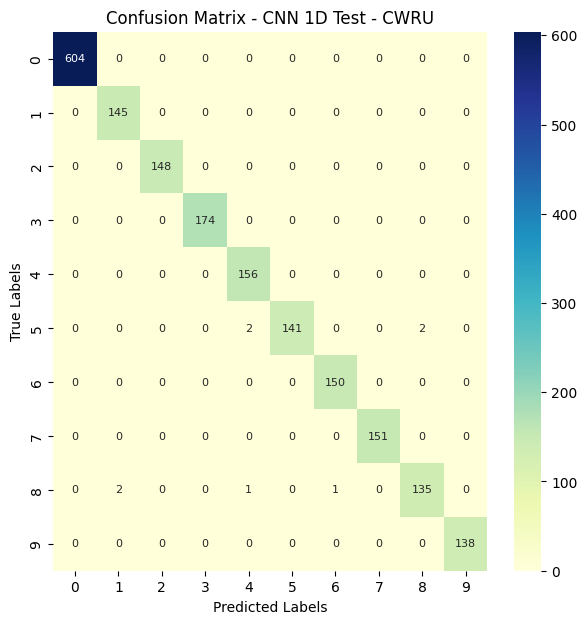

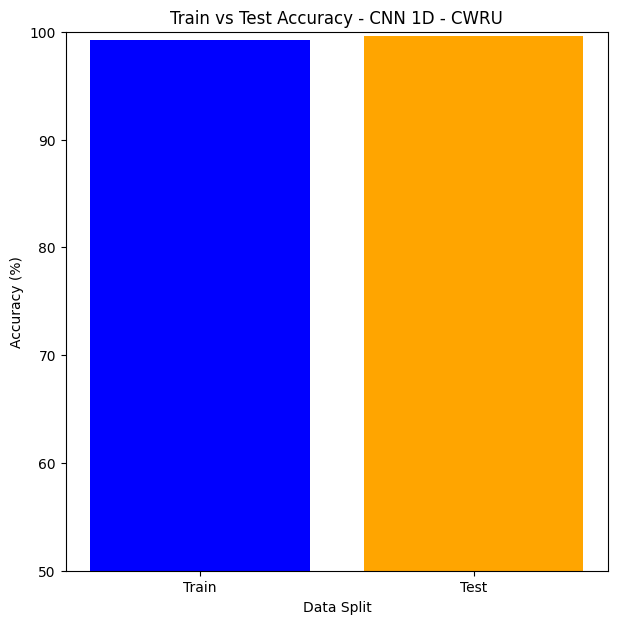

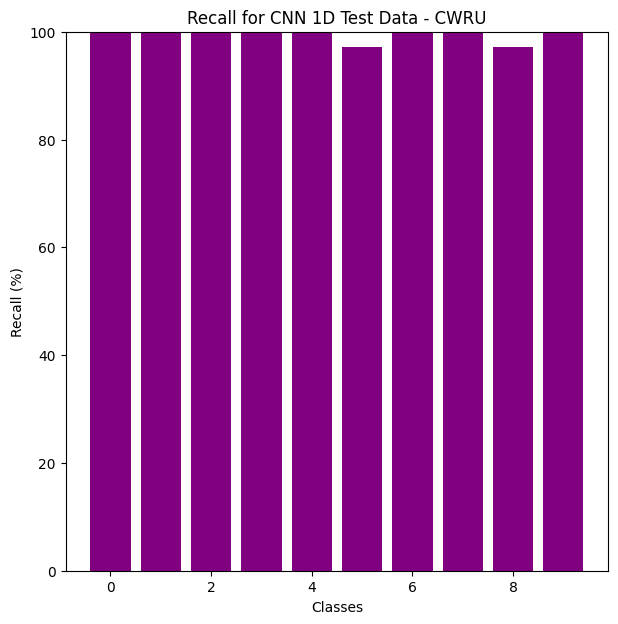

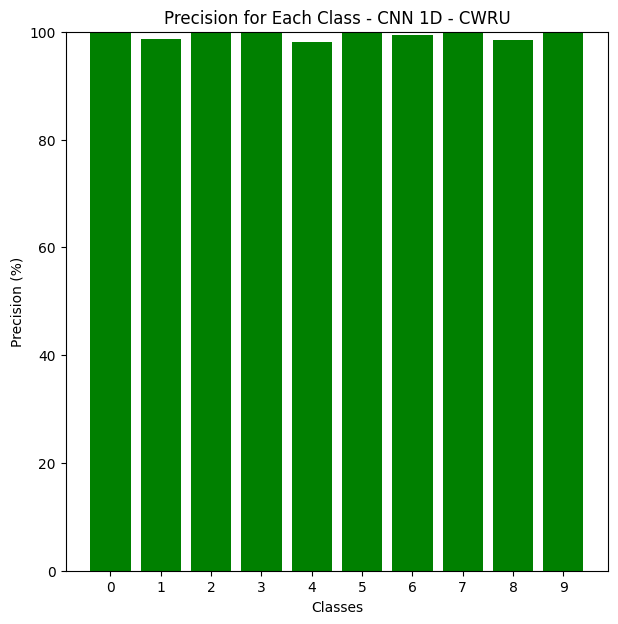

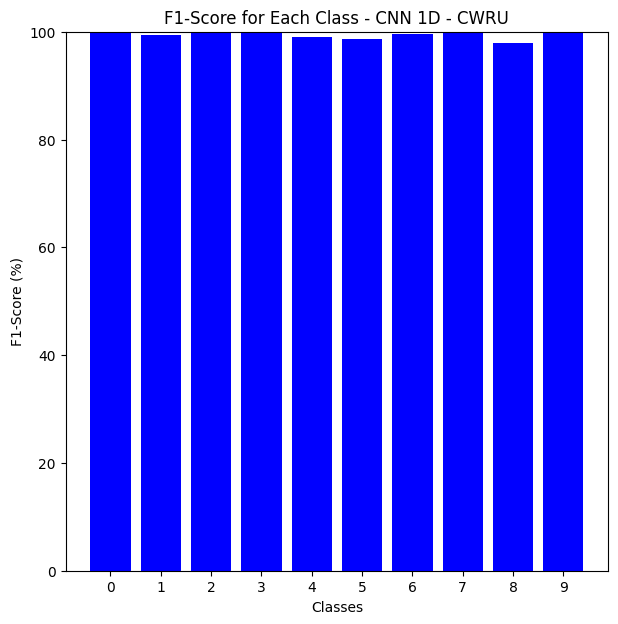

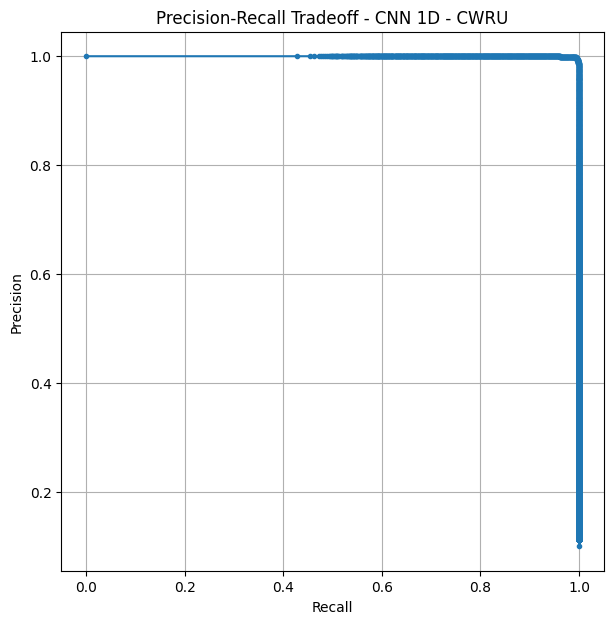

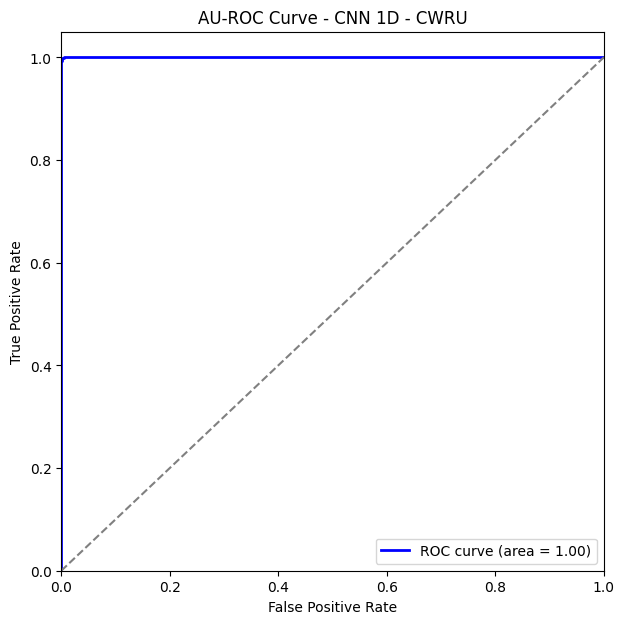

In [28]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - CNN 1D Train - CWRU')
sns.heatmap(cnn_1d_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - CNN 1D Test - CWRU')
sns.heatmap(cnn_1d_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - CNN 1D'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - CNN 1D - CWRU')
plt.bar([1, 2], [a_CNN_1D_train_accuracy, a_CNN_1D_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plotting 'Recall for CNN 1D Test Data'
plt.figure(figsize=(7, 7))
plt.title('Recall for CNN 1D Test Data - CWRU')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - CNN 1D - CWRU')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - CNN 1D - CWRU')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - CNN 1D - CWRU')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - CNN 1D - CWRU')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**2-Dimensional Convolutional Neural Network Classification Model**

In [79]:
start_time = time.time()
# Reshape the data - 2 dimensional feed
Input_2D = X.reshape([-1,40,50,1])

# Test-Train Split
X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(Input_2D, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)

# Define the CNN Classification model
class a_CNN_2D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3),strides=(2,2), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3),strides=(2,2),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3),strides=(2,2),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Flatten(),
        #layers.InputLayer(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model


accuracy_2D = []

# Train the model
for train, test in kfold.split(X_2D_train,y_2D_train):
  Classification_a_2D = a_CNN_2D()
  history = Classification_a_2D.model.fit(X_2D_train[train], y_2D_train[train], verbose=1, epochs=12)

  # Evaluate the accuracy of the model on the training set
  kf_loss, kf_accuracy = Classification_a_2D.model.evaluate(X_2D_train[test], y_2D_train[test])
  accuracy_2D.append(kf_accuracy)

a_CNN_2D_train_accuracy = np.average(accuracy_2D)*100
print('CNN 2D train accuracy - CWRU =', a_CNN_2D_train_accuracy)


# Evaluate the accuracy of the model on the test set
CNN_2D_test_loss, a_CNN_2D_test_accuracy = Classification_a_2D.model.evaluate(X_2D_test, y_2D_test)
a_CNN_2D_test_accuracy*=100
print('CNN 2D test accuracy - CWRU =', a_CNN_2D_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(Classification_a_2D.model, open(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Models/a_cnn_2d_model', 'wb'))

Epoch 1/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5326 - loss: 1.2978
Epoch 2/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8447 - loss: 0.3411
Epoch 3/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8869 - loss: 0.2575
Epoch 4/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8934 - loss: 0.2554
Epoch 5/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9224 - loss: 0.1865
Epoch 6/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9271 - loss: 0.1770
Epoch 7/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9332 - loss: 0.1689
Epoch 8/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9570 - loss: 0.1033
Epoch 9/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9677 - loss: 0.0802
Epoch 10/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9661 - loss: 0.0821
Epoch 11/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9762 - loss: 0.0649
Epoch 12/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/ste

**Calculation of Performance metrics**

In [83]:
# Predict on test data
y_pred_proba = Classification_a_2D.model.predict(X_2D_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_2D_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
y_pred_train = np.argmax(Classification_a_2D.model.predict(X_2D_train), axis=1)
cnn_2d_train_cm = confusion_matrix(np.argmax(y_2D_train, axis=1), y_pred_train)
cnn_2d_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for CNN 2D - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [a_CNN_2D_train_accuracy, a_CNN_2D_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
a_CNN_2D_train_accuracy = a_CNN_2D_train_accuracy
a_CNN_2D_test_accuracy = a_CNN_2D_test_accuracy
a_recall_CNN_2D_avg = recall_avg
a_precision_CNN_2D_avg = precision_avg
a_f1_CNN_2D_avg = f1_avg
a_roc_auc_CNN_2D = roc_auc

metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for CNN 2D - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Class-wise Metrics for CNN 2D - CWRU:
Class Label     Recall  Precision   F1-Score
    Class 0 100.000000  99.594046  99.796610
    Class 1  87.894737  95.428571  91.506849
    Class 2  95.505618  98.265896  96.866097
    Class 3  79.166667  77.551020  78.350515
    Class 4  95.348837  87.700535  91.364903
    Class 5  83.240223  84.180791  83.707865
    Class 6  83.333333  83.333333  83.333333
    Class 7 100.000000 100.000000 100.000000
    Class 8 100.000000 100.000000 100.000000
    Class 9 100.000000 100.000000 100.000000
    Average  92.448942  92.605419  92.492617

Overall Performance Metrics for CNN 2D - CWRU:
           Metric     Value
   Train Accuracy 96.184694
    Test Accuracy 95.914692
   Average Recall 92.448942
Average Precision 92.605419
 Average F1-Score 92.492617
          ROC AUC  0.999397


**Plot results - CNN-2D Model**

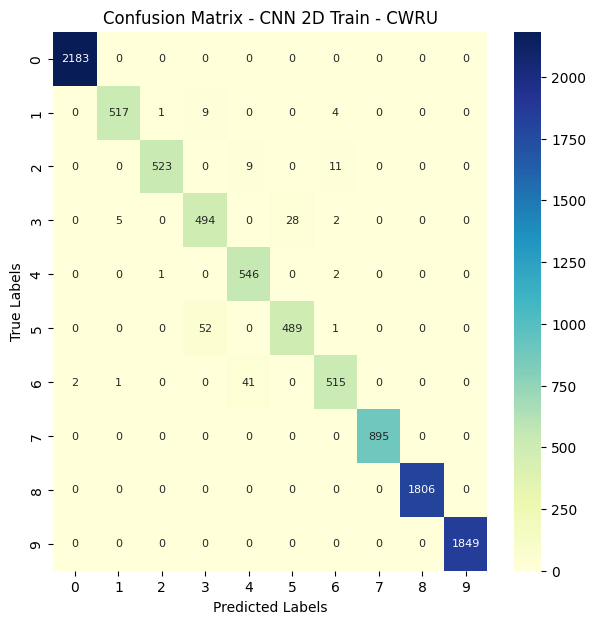

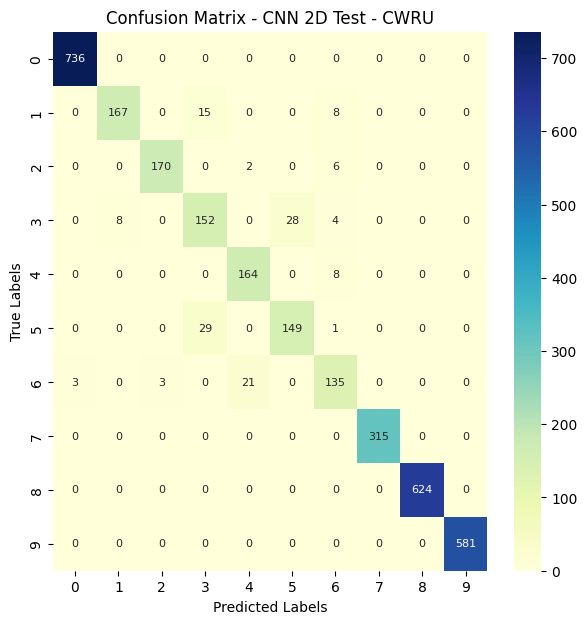

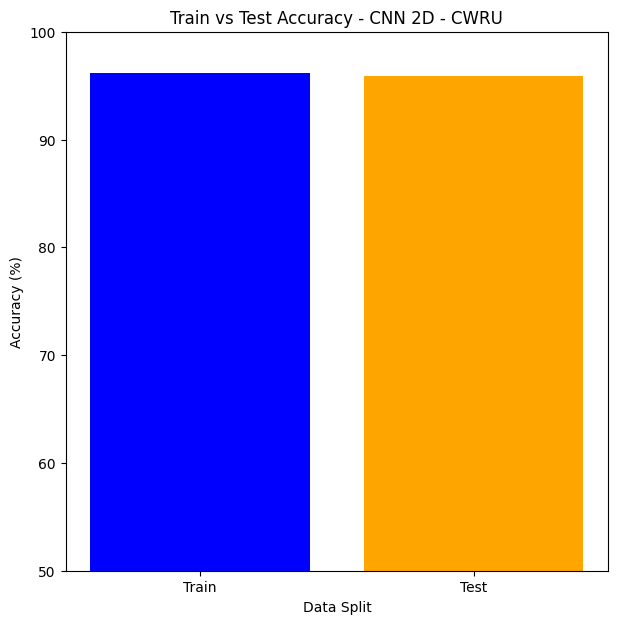

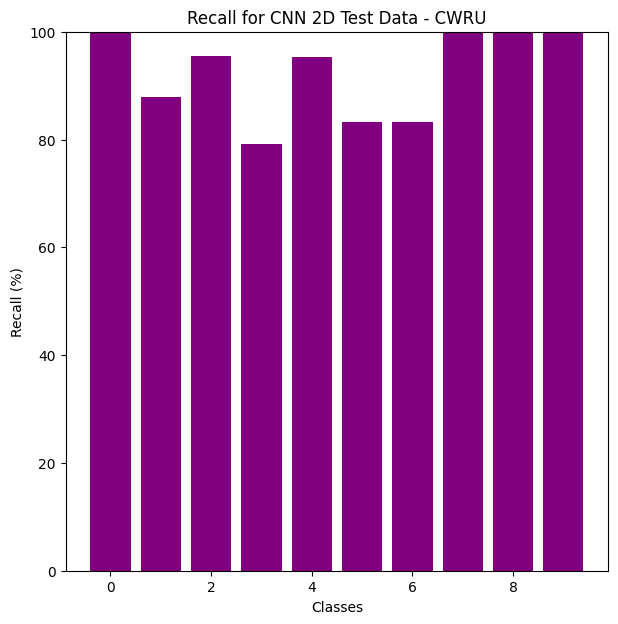

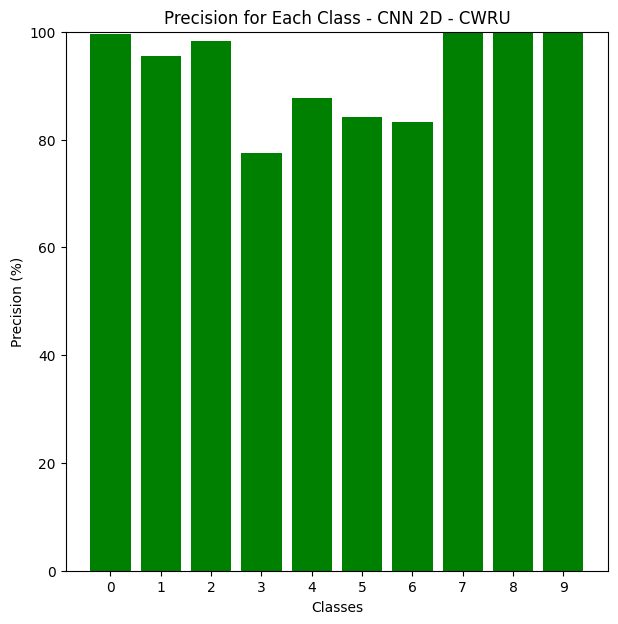

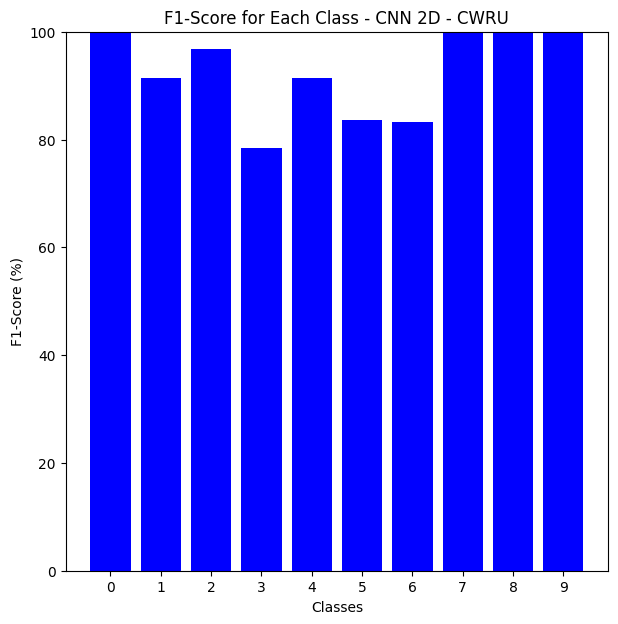

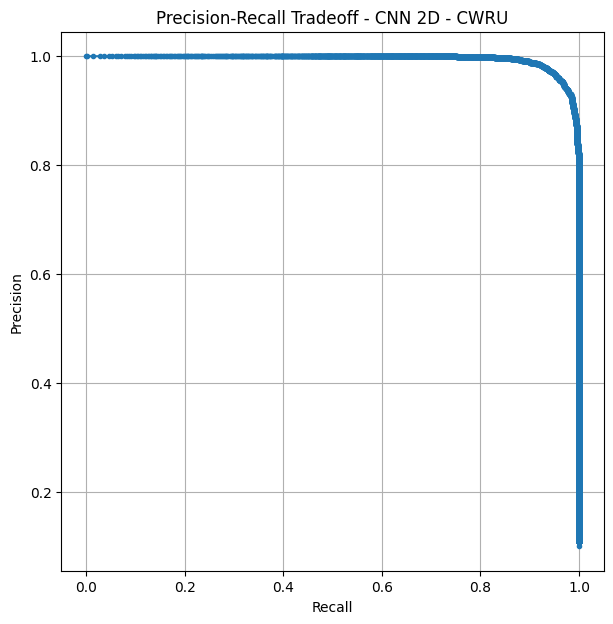

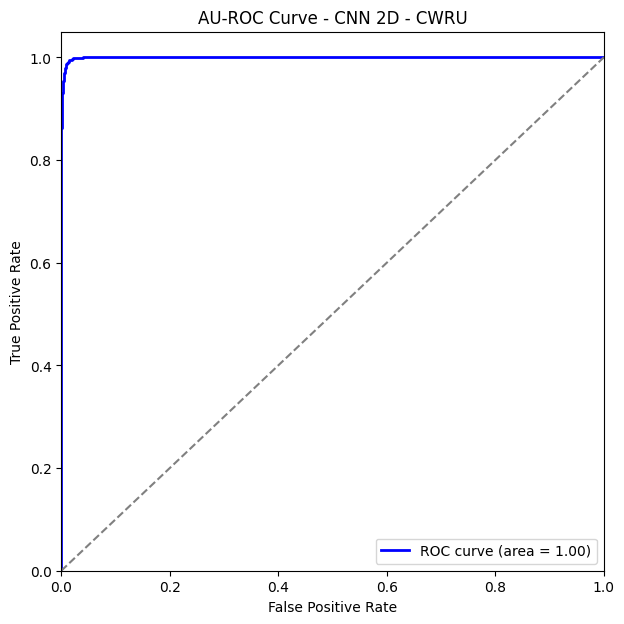

In [84]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - CNN 2D Train - CWRU')
sns.heatmap(cnn_2d_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - CNN 2D Test - CWRU')
sns.heatmap(cnn_2d_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - CNN 2D'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - CNN 2D - CWRU')
plt.bar([1, 2], [a_CNN_2D_train_accuracy, a_CNN_2D_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plotting 'Recall for CNN 2D Test Data'
plt.figure(figsize=(7, 7))
plt.title('Recall for CNN 2D Test Data - CWRU')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - CNN 2D - CWRU')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - CNN 2D - CWRU')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - CNN 2D - CWRU')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - CNN 2D - CWRU')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Long Short-Term Memory Recurrent Neural Network Classification Model**

In [32]:
start_time = time.time()
# Reshape the data - 1 dimensional feed
Input = X.reshape([-1,2000,1])

# Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(Input, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)

# Define the LSTM Classification model
class a_LSTM_Model():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.LSTM(32, return_sequences=True),
        layers.Flatten(),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model


accuracy = []

# Train the model
for train, test in kfold.split(X_train,y_train):
  a_Classification = a_LSTM_Model()
  history = a_Classification.model.fit(X_train[train], y_train[train], verbose=1, epochs=12)

  # Evaluate the accuracy of the model on the training set
  kf_loss, kf_accuracy = a_Classification.model.evaluate(X_train[test], y_train[test])
  accuracy.append(kf_accuracy)

a_LSTM_train_accuracy = np.average(accuracy)*100
print('LSTM train accuracy - CWRU =', a_LSTM_train_accuracy)


# Evaluate the accuracy of the model on the test set
LSTM_test_loss, a_LSTM_test_accuracy = a_Classification.model.evaluate(X_test, y_test)
a_LSTM_test_accuracy*=100
print('LSTM test accuracy - CWRU =', a_LSTM_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(a_Classification.model, open(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Models/a_lstm_model', 'wb'))

Epoch 1/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 44s 294ms/step - accuracy: 0.5716 - loss: 1.2567
Epoch 2/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 46s 313ms/step - accuracy: 0.9385 - loss: 0.1734
Epoch 3/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 286ms/step - accuracy: 0.9590 - loss: 0.1418
Epoch 4/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 285ms/step - accuracy: 0.9738 - loss: 0.0684
Epoch 5/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - accuracy: 0.9772 - loss: 0.0575
Epoch 6/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 287ms/step - accuracy: 0.9864 - loss: 0.0405
Epoch 7/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 287ms/step - accuracy: 0.9872 - loss: 0.0377
Epoch 8/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 287ms/step - accuracy: 0.9829 - loss: 0.0465
Epoch 9/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.9730 - loss: 0.0969
Epoch 10/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 324ms/step - accuracy: 0.8626 - loss: 1.0718
Epoch 11/12
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.9929 - loss: 0.0527
Epoch 12/12
147/147

**Calculation of Performance metrics**

In [33]:
# Predict on test data
y_pred_proba = a_Classification.model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
y_pred_train = np.argmax(a_Classification.model.predict(X_train), axis=1)
lstm_train_cm = confusion_matrix(np.argmax(y_train, axis=1), y_pred_train)
lstm_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for LSTM - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [a_LSTM_train_accuracy, a_LSTM_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
a_LSTM_train_accuracy = a_LSTM_train_accuracy
a_LSTM_test_accuracy = a_LSTM_test_accuracy
a_recall_LSTM_avg = recall_avg
a_precision_LSTM_avg = precision_avg
a_f1_LSTM_avg = f1_avg
a_roc_auc_LSTM = roc_auc

metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for LSTM - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step
Class-wise Metrics for LSTM - CWRU:
Class Label     Recall  Precision   F1-Score
    Class 0 100.000000 100.000000 100.000000
    Class 1 100.000000 100.000000 100.000000
    Class 2  80.405405  79.865772  80.134680
    Class 3 100.000000  99.428571  99.713467
    Class 4 100.000000  99.363057  99.680511
    Class 5 100.000000 100.000000 100.000000
    Class 6 100.000000  97.402597  98.684211
    Class 7 100.000000  98.692810  99.342105
    Class 8  74.820144  78.195489  76.470588
    Class 9  97.826087 100.000000  98.901099
    Average  95.305164  95.294830  95.292666

Overall Performance Metrics for LSTM - CWRU:
           Metric     Value
   Train Accuracy 94.989142
    Test Accuracy 96.564102
   Average Recall 95.305164
Average Precision 95.294830
 Average F1-Score 95.292666
          ROC AUC  0.999290


**Plot results - LSTM Model**

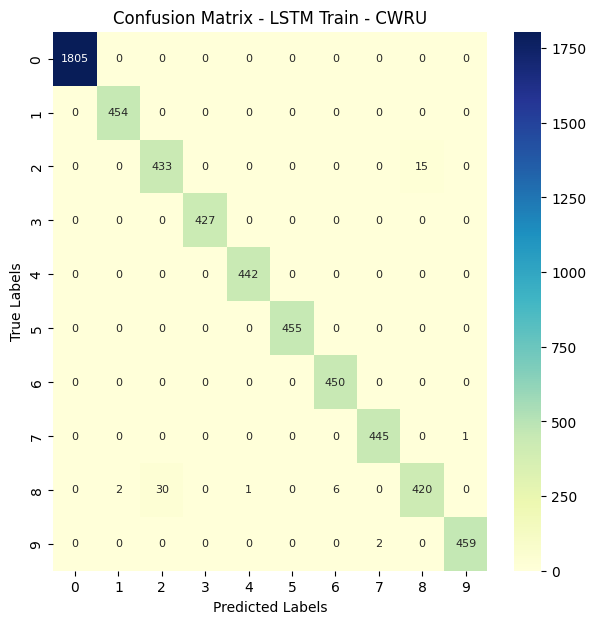

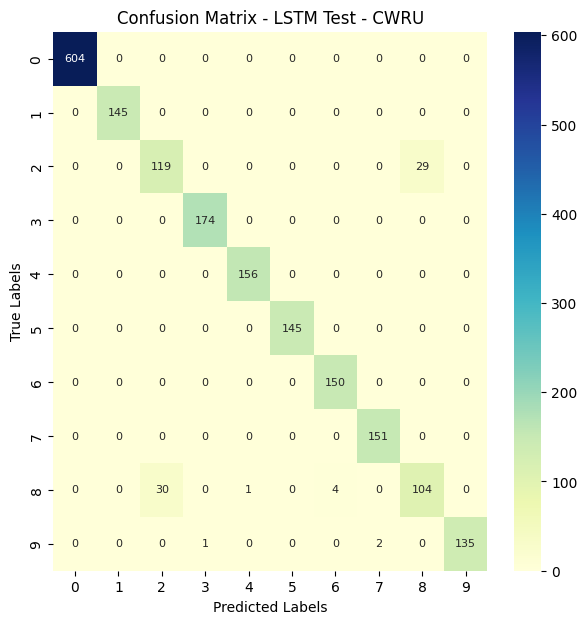

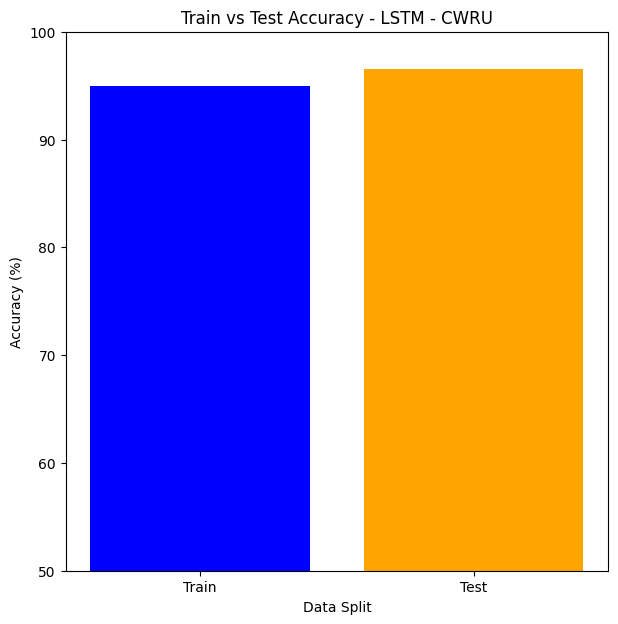

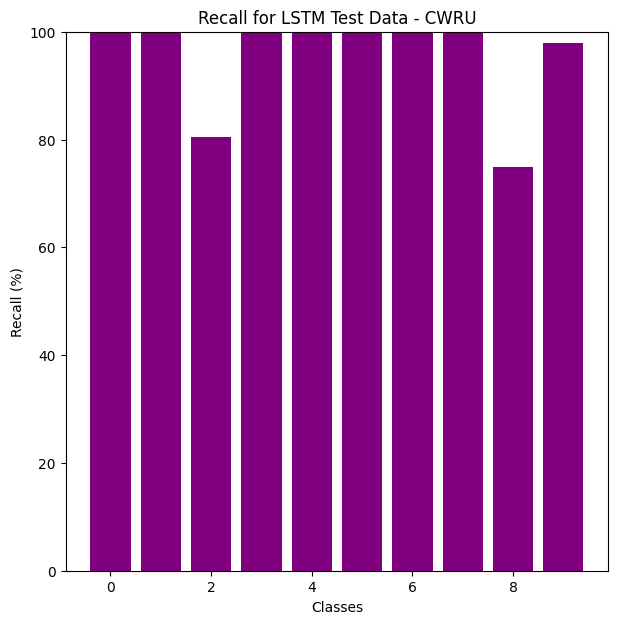

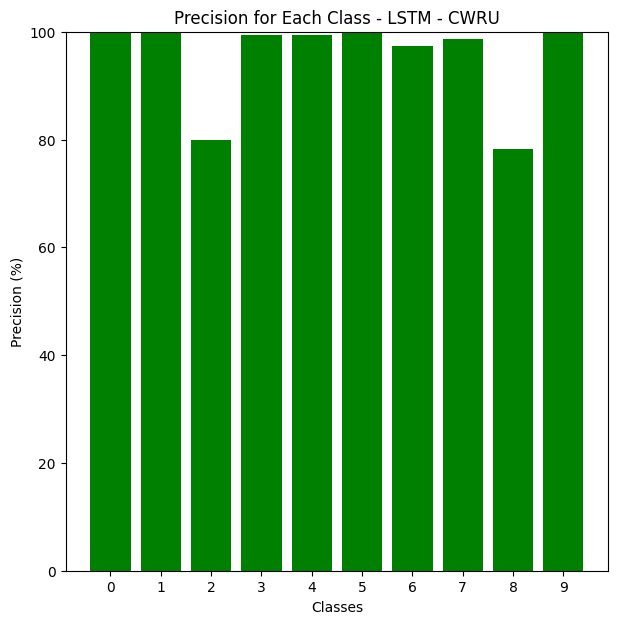

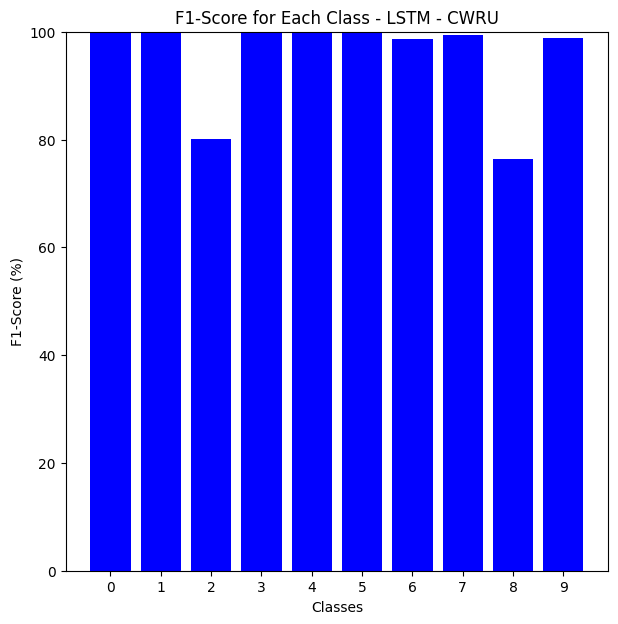

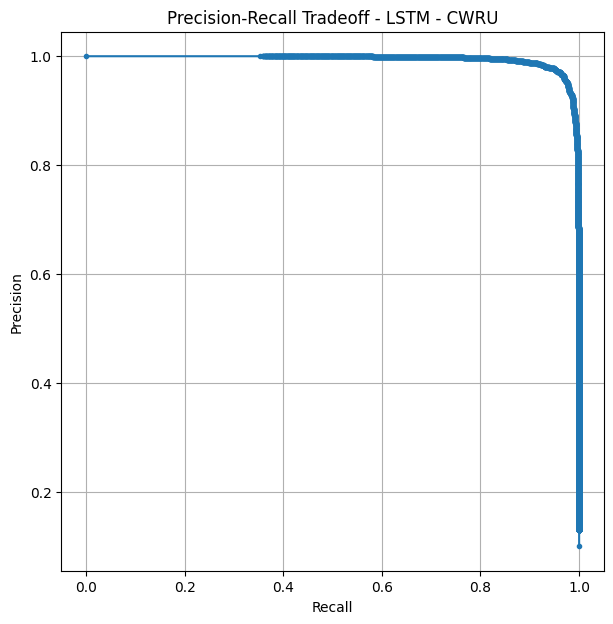

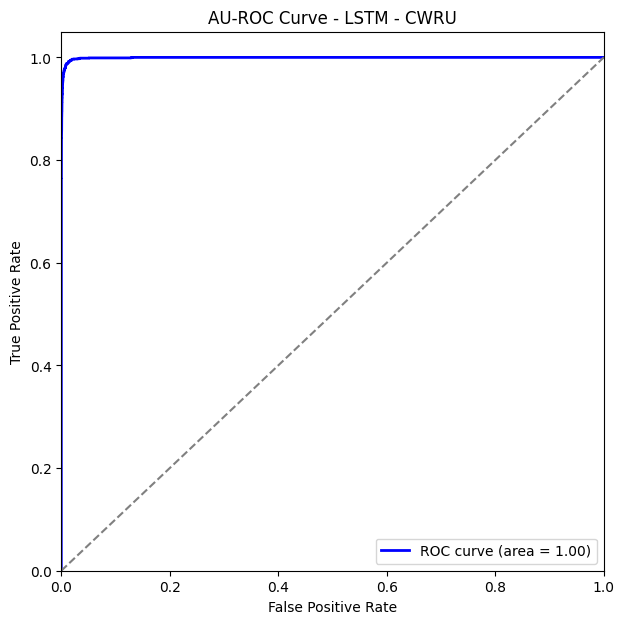

In [34]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - LSTM Train - CWRU')
sns.heatmap(lstm_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - LSTM Test - CWRU')
sns.heatmap(lstm_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - LSTM'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - LSTM - CWRU')
plt.bar([1, 2], [a_LSTM_train_accuracy, a_LSTM_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plotting 'Recall for LSTM Test Data'
plt.figure(figsize=(7, 7))
plt.title('Recall for LSTM Test Data - CWRU')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - LSTM - CWRU')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - LSTM - CWRU')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - LSTM - CWRU')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - LSTM - CWRU')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Support Vector Machine Classification Model**

In [35]:
start_time = time.time()
# Reshape the data - 1 dimensional feed
Input_1D = X.reshape([-1,2000,1])

# Test-Train Split
X_1D_train, X_1D_test, y_1D_train, y_1D_test = train_test_split(Input_1D, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# SVM Classifier
a_svm_model = SVC(kernel='linear', C=0.1, probability=True, random_state=42)
a_svm_model.fit(X_1D_train.reshape(len(X_1D_train), -1), np.argmax(y_1D_train, axis=1))

a_svm_train_accuracy = a_svm_model.score(X_1D_train.reshape(len(X_1D_train), -1), np.argmax(y_1D_train, axis=1)) * 100
a_svm_test_accuracy = a_svm_model.score(X_1D_test.reshape(len(X_1D_test), -1), np.argmax(y_1D_test, axis=1)) * 100

print('SVM train accuracy - CWRU =', a_svm_train_accuracy)
print('SVM test accuracy - CWRU =', a_svm_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(a_svm_model, open(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Models/a_svm_model', 'wb'))

SVM train accuracy - CWRU = 97.33196511031298
SVM test accuracy - CWRU = 69.6923076923077
Training time: 123.34 seconds


**Calculation of Performance metrics**

In [36]:
# Predict on test data
y_pred_proba = a_svm_model.predict_proba(X_1D_test.reshape(len(X_1D_test), -1))
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_1D_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
svm_train_pred = a_svm_model.predict(X_1D_train.reshape(len(X_1D_train), -1))
svm_train_cm = confusion_matrix(np.argmax(y_1D_train, axis=1), svm_train_pred)
svm_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for SVM - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [a_svm_train_accuracy, a_svm_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
a_svm_train_accuracy = a_svm_train_accuracy
a_svm_test_accuracy = a_svm_test_accuracy
a_svm_recall_avg = recall_avg
a_svm_precision_avg = precision_avg
a_svm_f1_avg = f1_avg
a_svm_roc_auc = roc_auc
metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for SVM - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

Class-wise Metrics for SVM - CWRU:
Class Label    Recall  Precision  F1-Score
    Class 0 99.172185  97.557003 98.357964
    Class 1 21.379310  23.134328 22.222222
    Class 2 81.081081  59.701493 68.767908
    Class 3  3.448276  37.500000  6.315789
    Class 4 95.512821  66.816143 78.627968
    Class 5 98.620690 100.000000 99.305556
    Class 6 95.333333  79.005525 86.404834
    Class 7 28.476821  24.855491 26.543210
    Class 8 41.726619  39.189189 40.418118
    Class 9 26.086957  30.769231 28.235294
    Average 59.083809  55.852840 55.519886

Overall Performance Metrics for SVM - CWRU:
           Metric     Value
   Train Accuracy 97.331965
    Test Accuracy 69.692308
   Average Recall 59.083809
Average Precision 55.852840
 Average F1-Score 55.519886
          ROC AUC  0.945204


**Plot results - SVM Model**

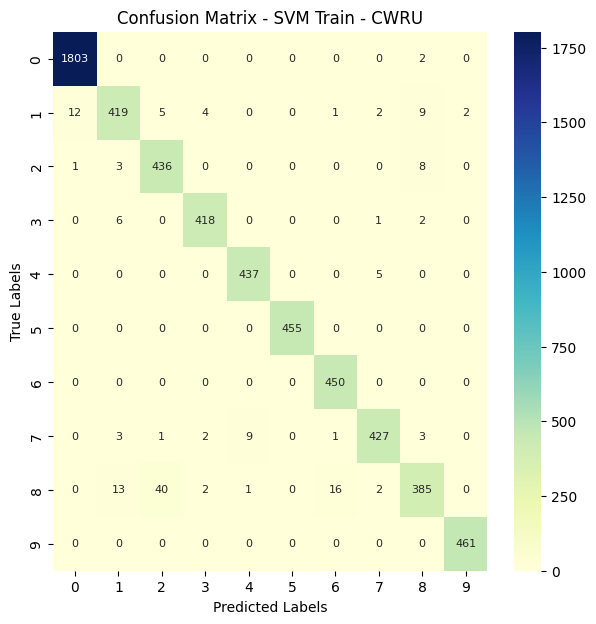

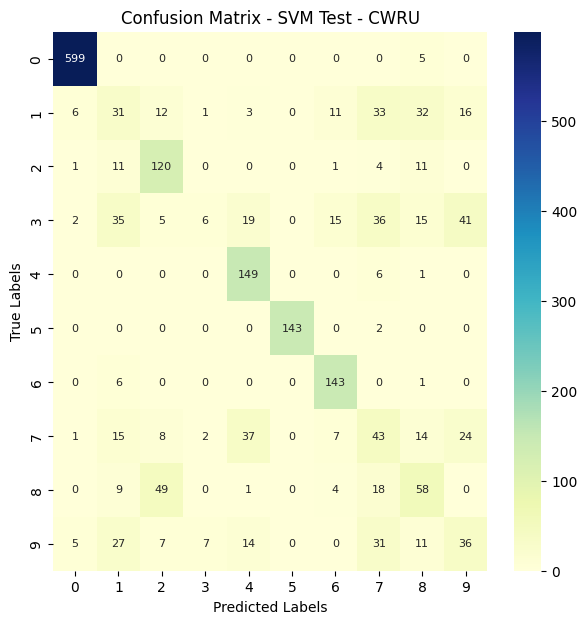

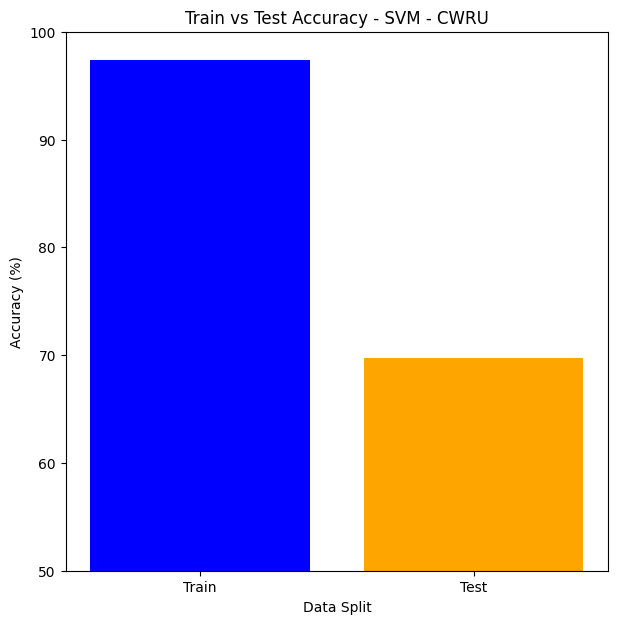

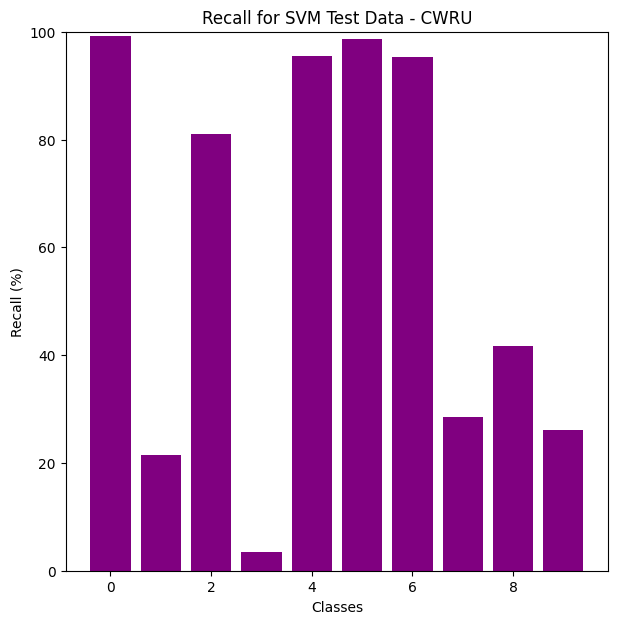

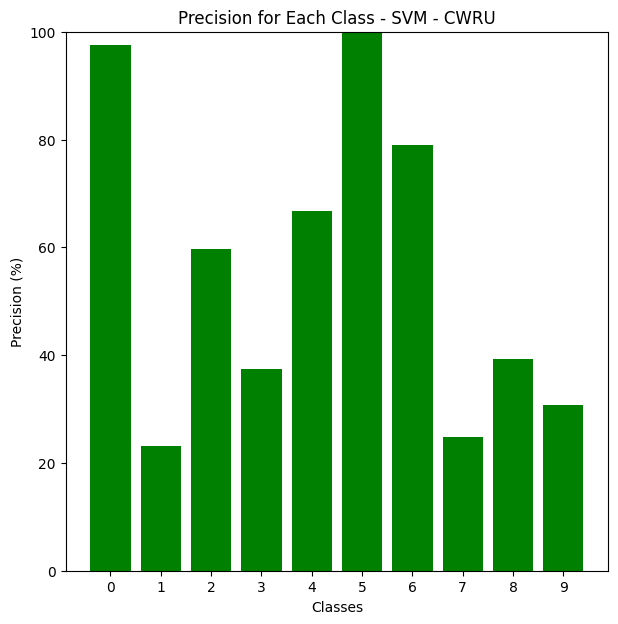

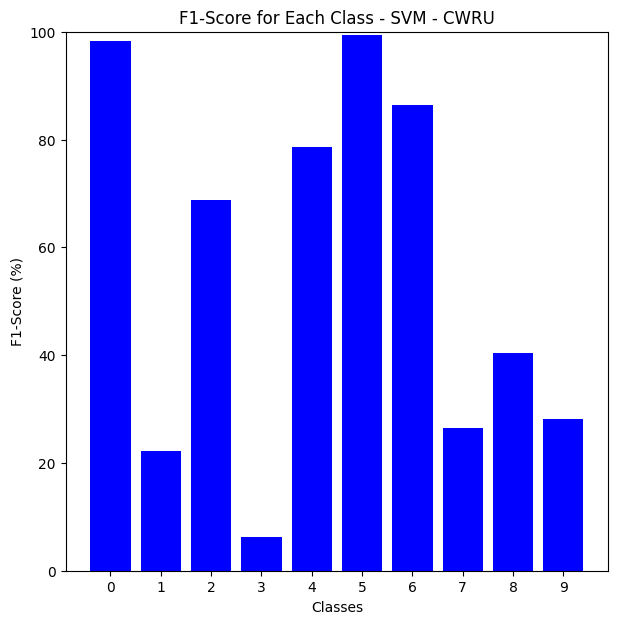

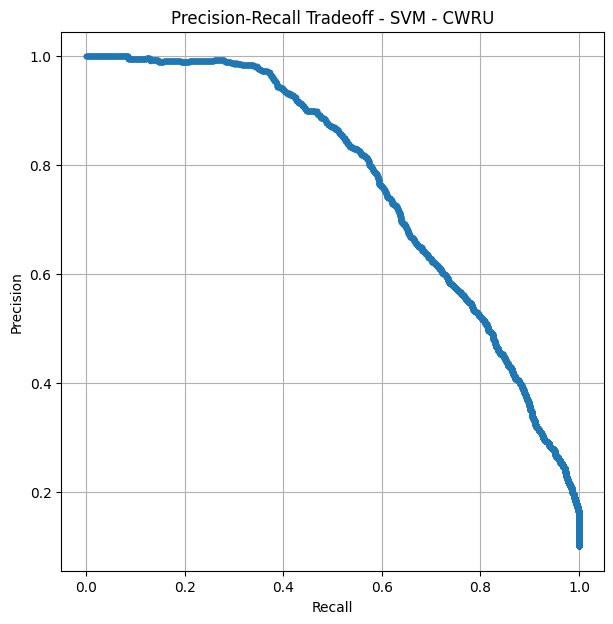

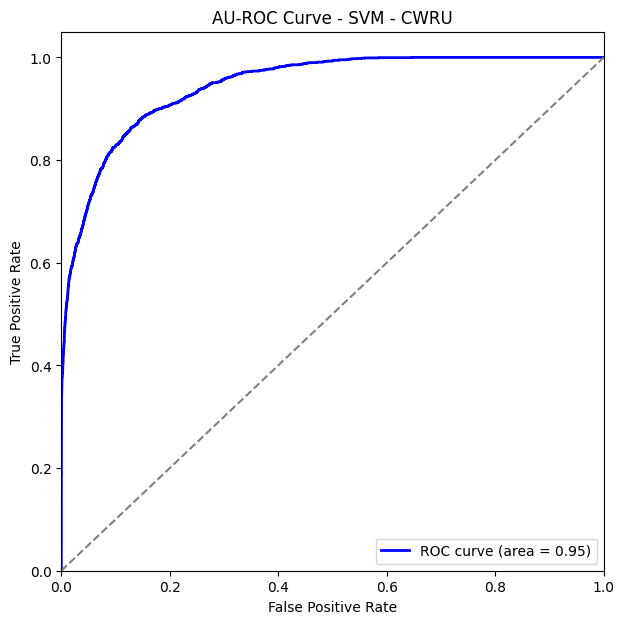

In [37]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - SVM Train - CWRU')
sns.heatmap(svm_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - SVM Test - CWRU')
sns.heatmap(svm_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - SVM'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - SVM - CWRU')
plt.bar([1, 2], [a_svm_train_accuracy, a_svm_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plot Recall for each class
plt.figure(figsize=(7, 7))
plt.title('Recall for SVM Test Data - CWRU')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - SVM - CWRU')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - SVM - CWRU')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - SVM - CWRU')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - SVM - CWRU')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Voting** **Classifier**

In [38]:
# Define a custom Keras wrapper class for scikit-learn
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, keras_model, num_classes):
        self.keras_model = keras_model
        self.num_classes = num_classes

    def fit(self, X, y):
        y_one_hot = np.eye(self.num_classes)[y]
        self.keras_model.fit(X, y_one_hot, epochs=10, batch_size=32, verbose=1)
        return self

    def predict(self, X):
        return np.argmax(self.keras_model.predict(X), axis=1)

    def predict_proba(self, X):
        return self.keras_model.predict(X)

# Assuming your Keras models are defined and compiled
a_rnn_wrapper = KerasClassifierWrapper(keras_model=Classification_a_rnn.model, num_classes=10)
a_lstm_wrapper = KerasClassifierWrapper(keras_model=a_Classification.model, num_classes=10)

# Initialize the Voting Classifier
start_time = time.time()
# Reshape and split your data
Input_1D = X.reshape([-1, 2000, 1])
X_train, X_test, y_train, y_test = train_test_split(Input_1D, Y_CNN, train_size=0.75, test_size=0.25, random_state=101)

# Flatten the data for traditional classifiers
X_train_flattened = X_train.reshape(len(X_train), -1)
X_test_flattened = X_test.reshape(len(X_test), -1)

# Ensure y_train and y_test are in the correct format (class indices)
y_train_indices = np.argmax(y_train, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

# Create the Voting Classifier
a_voting_clf = VotingClassifier(
    estimators=[
        ('rf', a_rf_model),
        ('gb', a_gb_model),
        ('rnn', a_rnn_wrapper),
        ('lstm', a_lstm_wrapper)
    ],
    voting='soft'  # Use 'soft' voting to average class probabilities
)

# Fit the Voting Classifier
a_voting_clf.fit(X_train_flattened, y_train_indices)

# Evaluate the Voting Classifier
a_voting_train_accuracy = a_voting_clf.score(X_train_flattened, y_train_indices) * 100
a_voting_test_accuracy = a_voting_clf.score(X_test_flattened, y_test_indices) * 100

print('Voting Classifier train accuracy - CWRU =', a_voting_train_accuracy)
print('Voting Classifier test accuracy - CWRU =', a_voting_test_accuracy)

end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")

pickle.dump(a_voting_clf, open(r'C:\Users\ariad\Downloads\Fault Classification\CWRU/Models/a_voting_model', 'wb'))


Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 46s 245ms/step - accuracy: 0.9024 - loss: 0.4178
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 45s 247ms/step - accuracy: 0.9147 - loss: 0.2914
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.9655 - loss: 0.1064
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 45s 243ms/step - accuracy: 0.9749 - loss: 0.0739
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 45s 247ms/step - accuracy: 0.9774 - loss: 0.0753
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 45s 247ms/step - accuracy: 0.9832 - loss: 0.0502
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 45s 246ms/step - accuracy: 0.9468 - loss: 0.1829
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 45s 247ms/step - accuracy: 0.9596 - loss: 0.1606
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 45s 247ms/step - accuracy: 0.9509 - loss: 0.1723
Epoch 10/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 45s 248ms/step - accuracy: 0.9665 - loss: 0.1169
Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 116s 624ms/step - accuracy: 0.9834 - loss: 0.0612
Epoch 2/10
183/183 

**Calculation of Performance metrics**

In [39]:
# Predict on test data with Voting Classifier
y_pred_proba = a_voting_clf.predict_proba(X_test_flattened)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
voting_train_pred = a_voting_clf.predict(X_train_flattened)
voting_train_cm = confusion_matrix(np.argmax(y_1D_train, axis=1), voting_train_pred)
voting_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for Voting Classifier - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [a_voting_train_accuracy,
              a_voting_test_accuracy,
              recall_avg, precision_avg, f1_avg, roc_auc]
}
a_v_train_accuracy = a_voting_train_accuracy
a_v_test_accuracy = a_voting_test_accuracy
a_v_recall_avg = recall_avg
a_v_precision_avg = precision_avg
a_v_f1_avg = f1_avg
a_v_roc_auc = roc_auc
metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for Voting Classifier - CWRU:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step
Class-wise Metrics for Voting Classifier - CWRU:
Class Label     Recall  Precision   F1-Score
    Class 0 100.000000 100.000000 100.000000
    Class 1 100.000000  97.972973  98.976109
    Class 2  81.756757  90.298507  85.815603
    Class 3  98.275862  99.418605  98.843931
    Class 4  99.358974 100.000000  99.678457
    Class 5 100.000000 100.000000 100.000000
    Class 6 100.000000  94.936709  97.402597
    Class 7  99.337748 100.000000  99.667774
    Class 8  85.611511  82.068966  83.802817
    Class 9  99.275362  98.561151  98.916968
    Average  96.361621  96.325691  96.310426

Overall Performance Metrics for Voting Classifier - CWRU:
           Metric      Value
   Train Accuracy 100.000000
    Test Accuracy  97.282051
   Average Recall  96.361621
Average Precision  96.325691
 Average F1-Score  96.310426
         

**Plot results-Voting classifier**

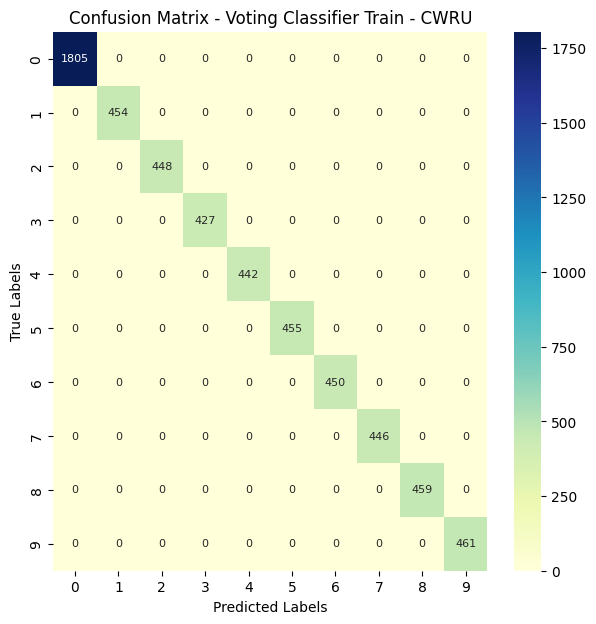

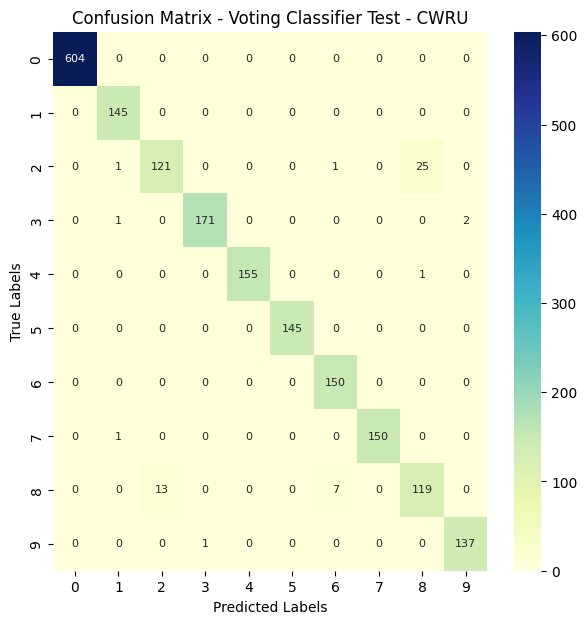

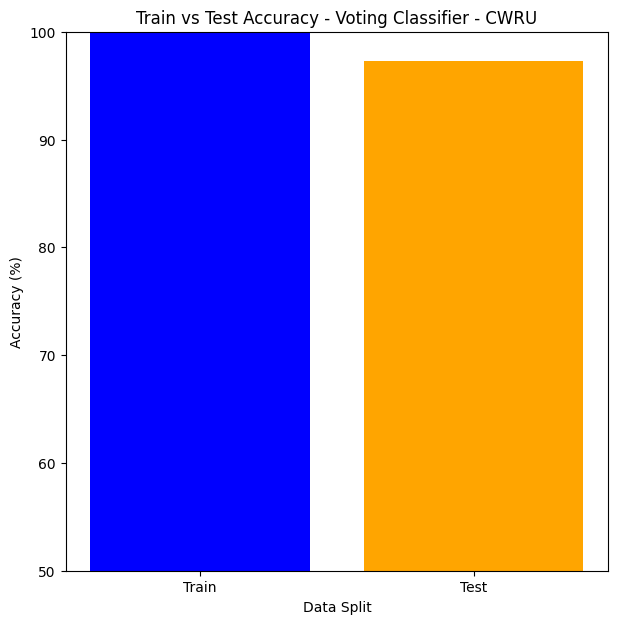

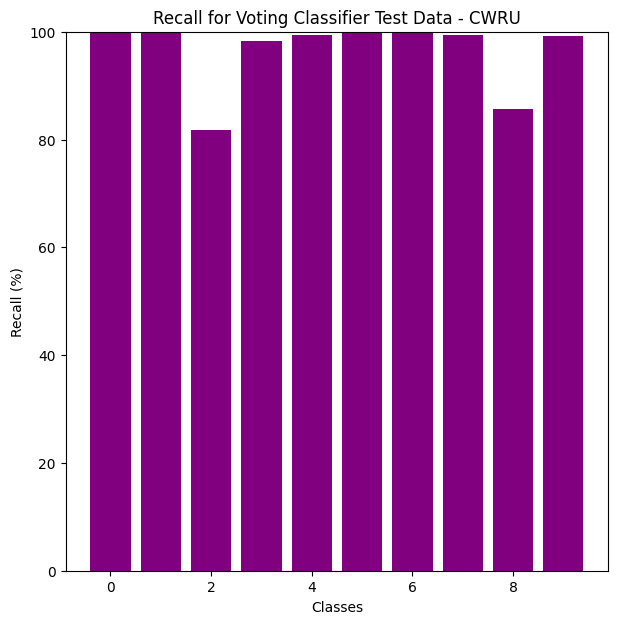

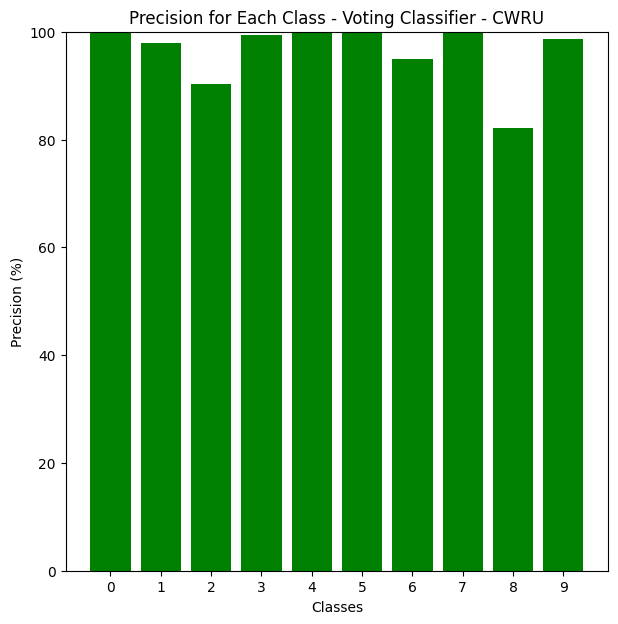

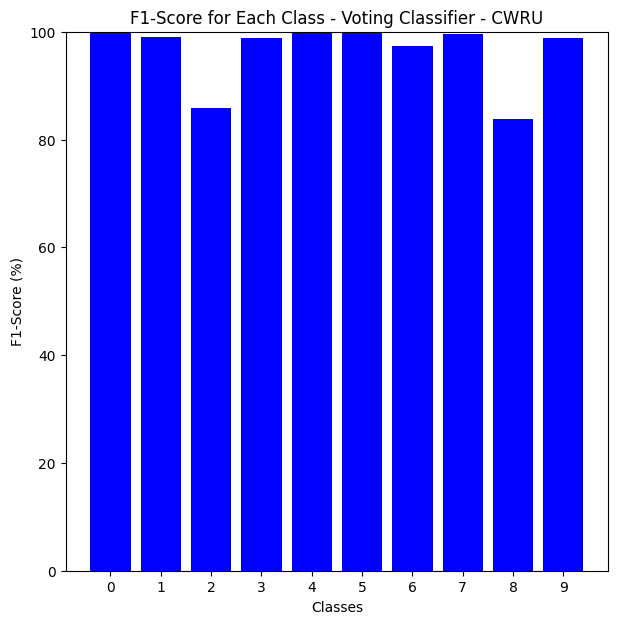

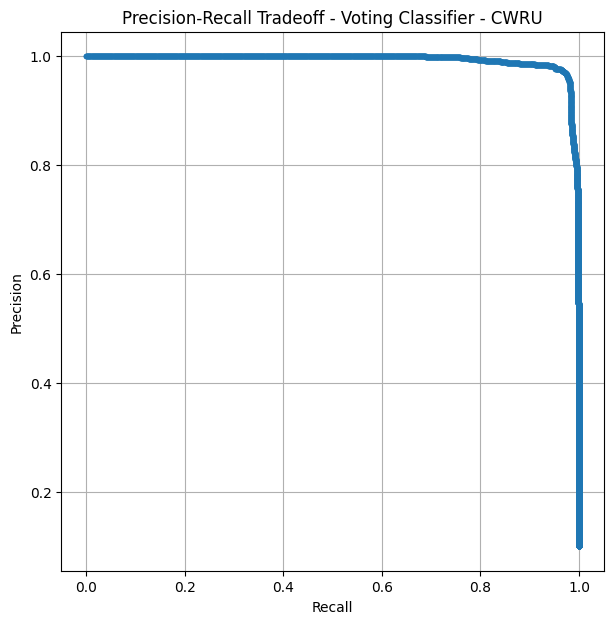

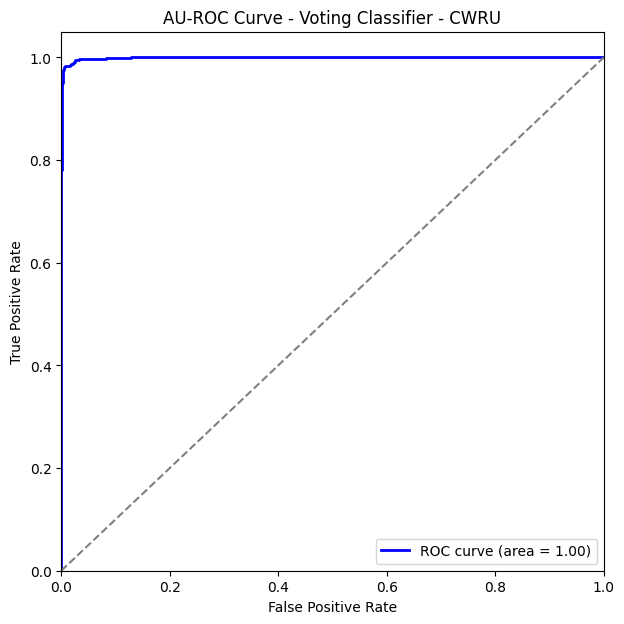

In [40]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - Voting Classifier Train - CWRU')
sns.heatmap(voting_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - Voting Classifier Test - CWRU')
sns.heatmap(voting_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - Voting Classifier'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - Voting Classifier - CWRU')
plt.bar([1, 2], [a_voting_train_accuracy, a_voting_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plot Recall for each class
plt.figure(figsize=(7, 7))
plt.title('Recall for Voting Classifier Test Data - CWRU')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - Voting Classifier - CWRU')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - Voting Classifier - CWRU')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - Voting Classifier - CWRU')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - Voting Classifier - CWRU')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**COMPARISON OF MODELS**

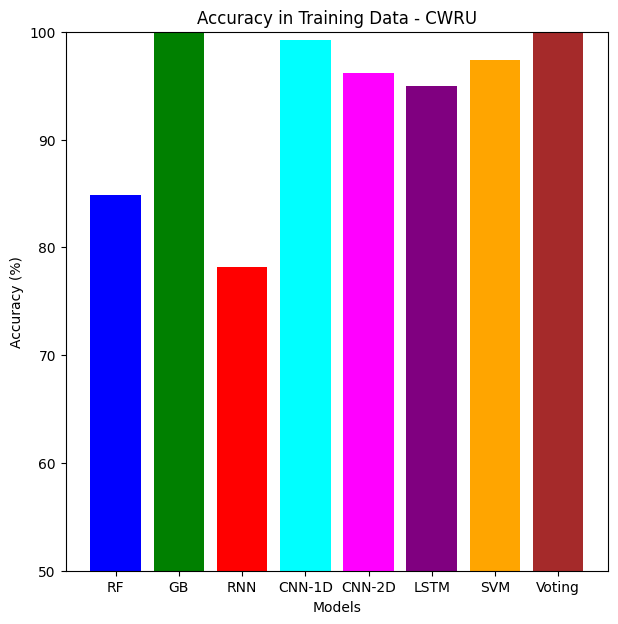

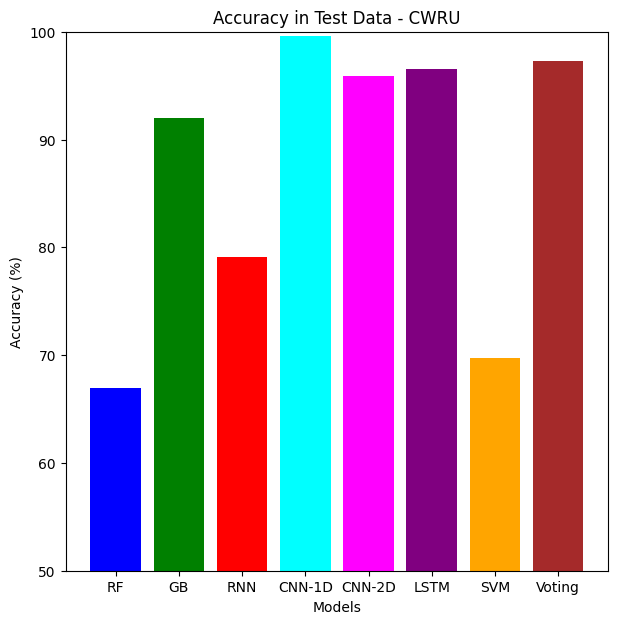

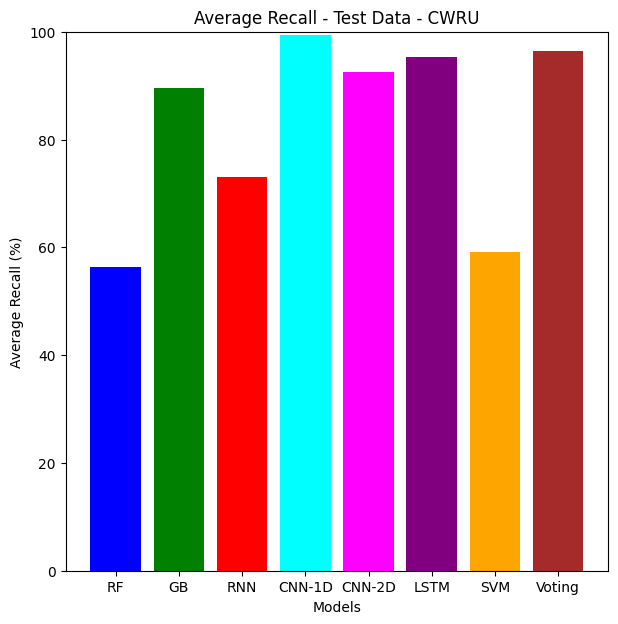

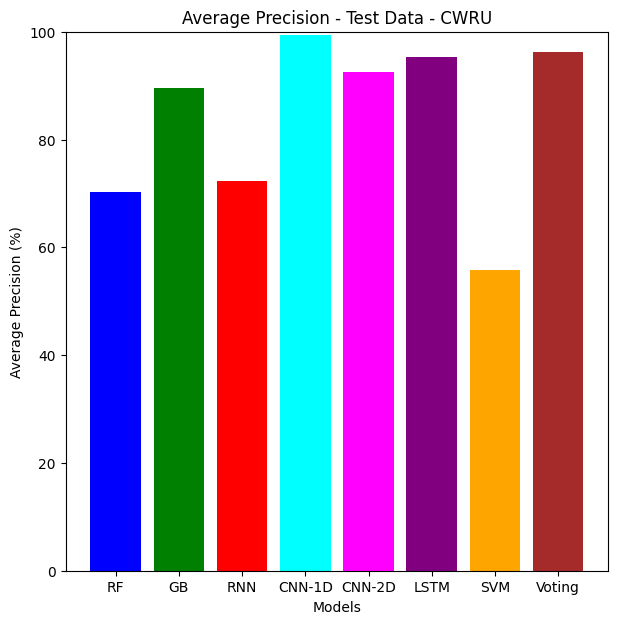

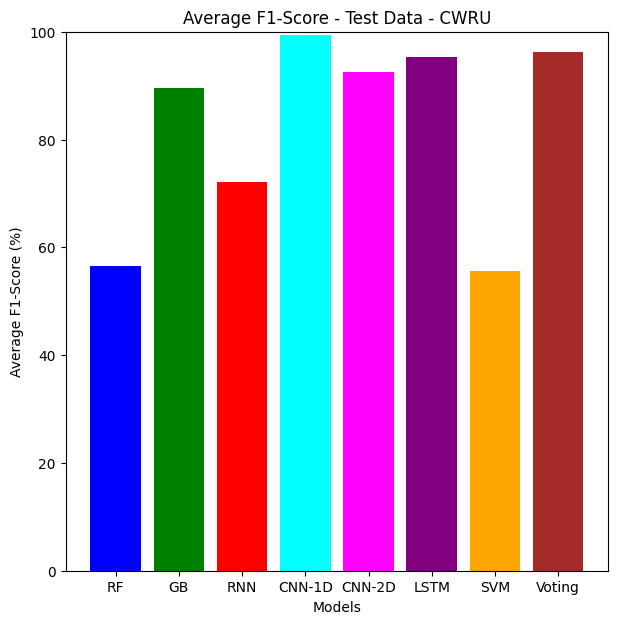

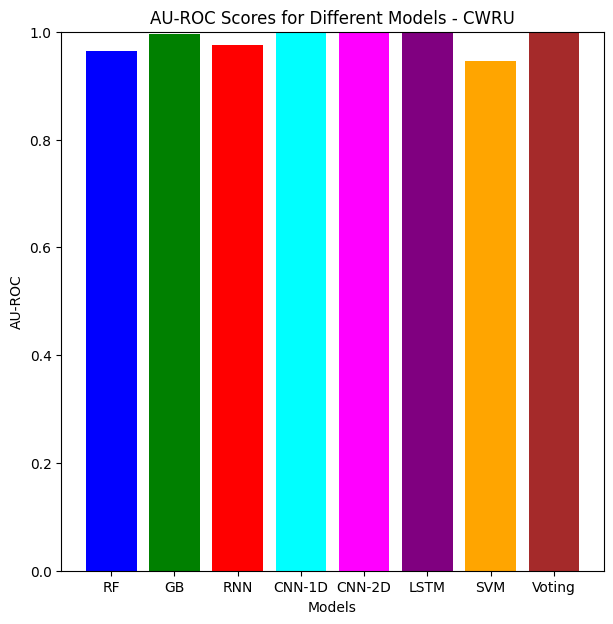

In [85]:
# Define the metrics for each model including Voting Classifier
metrics_cwru = {
    'RF': {
        'Train Accuracy': a_rf_train_accuracy,
        'Test Accuracy': a_rf_test_accuracy,
        'Average Recall': a_rf_recall_avg,
        'Average Precision': a_rf_precision_avg,
        'Average F1-Score': a_rf_f1_avg,
        'AU-ROC': a_rf_roc_auc
    },
    'GB': {
        'Train Accuracy': a_gb_train_accuracy,
        'Test Accuracy': a_gb_test_accuracy,
        'Average Recall': a_gb_recall_avg,
        'Average Precision': a_gb_precision_avg,
        'Average F1-Score': a_gb_f1_avg,
        'AU-ROC': a_gb_roc_auc
    },
    'RNN': {
        'Train Accuracy': a_RNN_train_accuracy,
        'Test Accuracy': a_RNN_test_accuracy,
        'Average Recall': a_recall_RNN_avg,
        'Average Precision': a_precision_RNN_avg,
        'Average F1-Score': a_f1_RNN_avg,
        'AU-ROC': a_roc_auc_RNN
    },
    'CNN-1D': {
        'Train Accuracy': a_CNN_1D_train_accuracy,
        'Test Accuracy': a_CNN_1D_test_accuracy,
        'Average Recall': a_recall_CNN_1D_avg,
        'Average Precision': a_precision_CNN_1D_avg,
        'Average F1-Score': a_f1_CNN_1D_avg,
        'AU-ROC': a_roc_auc_CNN_1D
    },
    'CNN-2D': {
        'Train Accuracy': a_CNN_2D_train_accuracy,
        'Test Accuracy': a_CNN_2D_test_accuracy,
        'Average Recall': a_recall_CNN_2D_avg,
        'Average Precision': a_precision_CNN_2D_avg,
        'Average F1-Score': a_f1_CNN_2D_avg,
        'AU-ROC': a_roc_auc_CNN_2D
    },
    'LSTM': {
        'Train Accuracy': a_LSTM_train_accuracy,
        'Test Accuracy': a_LSTM_test_accuracy,
        'Average Recall': a_recall_LSTM_avg,
        'Average Precision': a_precision_LSTM_avg,
        'Average F1-Score': a_f1_LSTM_avg,
        'AU-ROC': a_roc_auc_LSTM
    },
    'SVM': {
        'Train Accuracy': a_svm_train_accuracy,
        'Test Accuracy': a_svm_test_accuracy,
        'Average Recall': a_svm_recall_avg,
        'Average Precision': a_svm_precision_avg,
        'Average F1-Score': a_svm_f1_avg,
        'AU-ROC': a_svm_roc_auc
    },
    'Voting': {
        'Train Accuracy': a_voting_train_accuracy,
        'Test Accuracy': a_voting_test_accuracy,
        'Average Recall': a_v_recall_avg,
        'Average Precision': a_v_precision_avg,
        'Average F1-Score': a_v_f1_avg,
        'AU-ROC': a_v_roc_auc
    }
}

# Plot Accuracy in Training Data
plt.figure(figsize=(7, 7))
plt.title('Accuracy in Training Data - CWRU')
plt.bar(metrics_cwru.keys(), [metrics_cwru[model]['Train Accuracy'] for model in metrics_cwru], color=['blue', 'green', 'red', 'cyan', 'magenta', 'purple', 'orange', 'brown'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Models')
plt.ylim([50, 100])
plt.show()

# Plot Accuracy in Test Data
plt.figure(figsize=(7, 7))
plt.title('Accuracy in Test Data - CWRU')
plt.bar(metrics_cwru.keys(), [metrics_cwru[model]['Test Accuracy'] for model in metrics_cwru], color=['blue', 'green', 'red', 'cyan', 'magenta', 'purple', 'orange', 'brown'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Models')
plt.ylim([50, 100])
plt.show()

# Plot Average Recall - Test Data
plt.figure(figsize=(7, 7))
plt.title('Average Recall - Test Data - CWRU')
plt.bar(metrics_cwru.keys(), [metrics_cwru[model]['Average Recall'] for model in metrics_cwru], color=['blue', 'green', 'red', 'cyan', 'magenta', 'purple', 'orange', 'brown'])
plt.ylabel('Average Recall (%)')
plt.xlabel('Models')
plt.ylim([0, 100])
plt.show()

# Plot Average Precision - Test Data
plt.figure(figsize=(7, 7))
plt.title('Average Precision - Test Data - CWRU')
plt.bar(metrics_cwru.keys(), [metrics_cwru[model]['Average Precision'] for model in metrics_cwru], color=['blue', 'green', 'red', 'cyan', 'magenta', 'purple', 'orange', 'brown'])
plt.ylabel('Average Precision (%)')
plt.xlabel('Models')
plt.ylim([0, 100])
plt.show()

# Plot Average F1-Score - Test Data
plt.figure(figsize=(7, 7))
plt.title('Average F1-Score - Test Data - CWRU')
plt.bar(metrics_cwru.keys(), [metrics_cwru[model]['Average F1-Score'] for model in metrics_cwru], color=['blue', 'green', 'red', 'cyan', 'magenta', 'purple', 'orange', 'brown'])
plt.ylabel('Average F1-Score (%)')
plt.xlabel('Models')
plt.ylim([0, 100])
plt.show()

# Plot AU-ROC Scores
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Scores for Different Models - CWRU')
plt.bar(metrics_cwru.keys(), [metrics_cwru[model]['AU-ROC'] for model in metrics_cwru], color=['blue', 'green', 'red', 'cyan', 'magenta', 'purple', 'orange', 'brown'])
plt.ylabel('AU-ROC')
plt.xlabel('Models')
plt.ylim([0, 1])
plt.show()

**MFPT Dataset Information**

Baseline condition: 270 lbs of load, input shaft rate of 25 Hz, sample rate of 97,656 sps for 6 seconds

Outer race fault conditions: 270 lbs of load, input shaft rate of 25 Hz, sample rate of 97,656 sps for 6 seconds

Outer race fault conditions: 25, 100, 200 and 300 lbs of load, input shaft rate 25 Hz, sample rate of 48,828 sps for 3 seconds

Inner race fault conditions: 0, 100, 200  and 300 lbs of load, input shaft rate of 25 Hz, sample rate of 48,828 sps for 3 seconds

Three real world example: an intermediate shaft bearing from a wind turbine, an oil pump
shaft bearing from a wind turbine, and a real world planet bearing fault.



**File Name - Fault type - Load (lbs) - Class**

normal.mat - Normal baseline data - 270 - Class 0

ir_0.mat - Inner race - 0 - Class 1

or_25.mat - Outer race - 25 - Class 2

ir_100.mat - Inner race - 100 - Class 3

or_100.mat - Outer race - 100 - Class 4

ir_200.mat - Inner race - 200 - Class 5

or_200.mat - Outer race - 200 - Class 6

planet.mat - Planet bearing fault - 0 - Class 7

speed.mat - Intermediate shaft
bearing fault - 300 - Class 8

oil.mat - Pump shaft bearing fault - 300 - Class 9

**Import Data**

In [42]:
def ImportData():
  X_normal = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Data/normal.mat')['normal']
  X_InnerRace_0 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Data/ir_0.mat')['ir_0']
  X_OuterRace_25 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Data/or_25.mat')['or_25']
  X_InnerRace_100 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Data/ir_100.mat')['ir_100']
  X_OuterRace_100 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Data/or_100.mat')['or_100']
  X_InnerRace_200 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Data/ir_200.mat')['ir_200']
  X_OuterRace_200 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Data/or_200.mat')['or_200']
  X_Planet_0 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Data/planet.mat')['planet']
  X_Speed_300 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Data/speed.mat')['speed']
  X_Oil_300 = scipy.io.loadmat(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Data/oil.mat')['oil']
  return [X_normal,X_InnerRace_0,X_OuterRace_25,X_InnerRace_100,X_OuterRace_100,X_InnerRace_200,X_OuterRace_200,X_Planet_0,X_Speed_300,X_Oil_300]

def Sampling(Data, interval_length, samples_per_block):
  # Calculate the number of blocks that can be sampled based on the interval length
  No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length)-1)
  SplitData = np.zeros([No_of_blocks, samples_per_block])
  for i in range(No_of_blocks):
    SplitData[i,:] = (Data[i*interval_length:(i*interval_length)+samples_per_block]).T
  return SplitData


def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block)
    y = np.zeros([len(SplitData),10])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1])
    y1[:,0] = count
    # Stack up and label the data
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  return X, LabelPositional, Label


Data = ImportData()
interval_length = 200
samples_per_block = 2000


# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs,
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block)


print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

Shape of Input Data = (13315, 2000)
Shape of Label Y_CNN = (13315, 10)
Shape of Label Y = (13315, 1)


**K-Fold Cross Validation**

In [43]:
# k-fold cross validation
kSplits = 5
kfold = KFold(n_splits=kSplits, random_state=32, shuffle=True)

**Random Forest Classification Model**

In [44]:
start_time = time.time()
# Reshape the data - 1 dimensional feed
Input_1D = X.reshape([-1,2000,1])

# Test-Train Split
X_1D_train, X_1D_test, y_1D_train, y_1D_test = train_test_split(Input_1D, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)
# Random Forest Classifier
b_rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
b_rf_model.fit(X_1D_train.reshape(len(X_1D_train), -1), np.argmax(y_1D_train, axis=1))

b_rf_train_accuracy = b_rf_model.score(X_1D_train.reshape(len(X_1D_train), -1), np.argmax(y_1D_train, axis=1)) * 100
b_rf_test_accuracy = b_rf_model.score(X_1D_test.reshape(len(X_1D_test), -1), np.argmax(y_1D_test, axis=1)) * 100

print('Random Forest train accuracy - MFPT =', b_rf_train_accuracy)
print('Random Forest test accuracy - MFPT =', b_rf_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(b_rf_model, open(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Models/b_rf_model', 'wb'))

Random Forest train accuracy - MFPT = 78.80032044862809
Random Forest test accuracy - MFPT = 67.76809852808651
Training time: 31.17 seconds


**Calculation of Performance metrics**

In [45]:
# Predict on test data
y_pred = b_rf_model.predict(X_1D_test.reshape(len(X_1D_test), -1))
y_true = np.argmax(y_1D_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_pred_proba = b_rf_model.predict_proba(X_1D_test.reshape(len(X_1D_test), -1))
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
rf_train_pred = b_rf_model.predict(X_1D_train.reshape(len(X_1D_train), -1))
rf_train_cm = confusion_matrix(np.argmax(y_1D_train, axis=1), rf_train_pred)
rf_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for Random Forest - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [b_rf_train_accuracy, b_rf_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
b_rf_train_accuracy = b_rf_train_accuracy
b_rf_test_accuracy = b_rf_test_accuracy
b_rf_recall_avg = recall_avg
b_rf_precision_avg = precision_avg
b_rf_f1_avg = f1_avg
b_rf_roc_auc = roc_auc

metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for Random Forest - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

Class-wise Metrics for Random Forest - MFPT:
Class Label     Recall  Precision   F1-Score
    Class 0 100.000000  40.685462  57.838900
    Class 1   0.000000   0.000000   0.000000
    Class 2   0.000000   0.000000   0.000000
    Class 3   0.000000   0.000000   0.000000
    Class 4   0.000000   0.000000   0.000000
    Class 5   0.000000   0.000000   0.000000
    Class 6   0.000000   0.000000   0.000000
    Class 7 100.000000 100.000000 100.000000
    Class 8 100.000000 100.000000 100.000000
    Class 9 100.000000 100.000000 100.000000
    Average  40.000000  34.068546  35.783890

Overall Performance Metrics for Random Forest - MFPT:
           Metric     Value
   Train Accuracy 78.800320
    Test Accuracy 67.768099
   Average Recall 40.000000
Average Precision 34.068546
 Average F1-Score 35.783890
          ROC AUC  0.953478


**Plot results - RF Model**

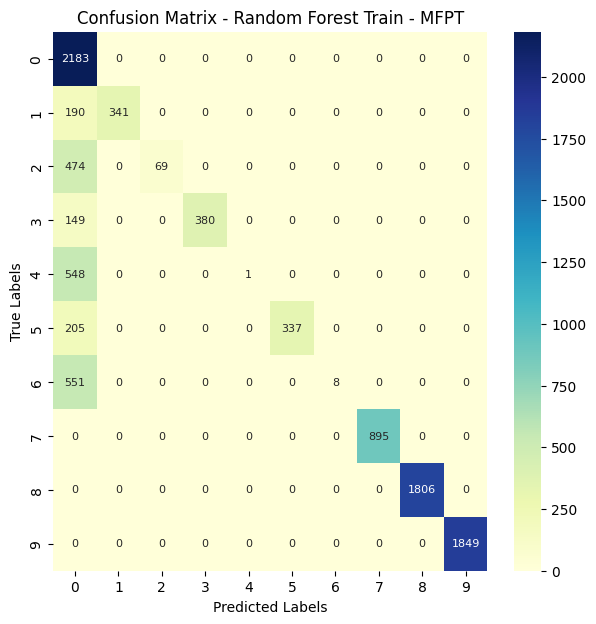

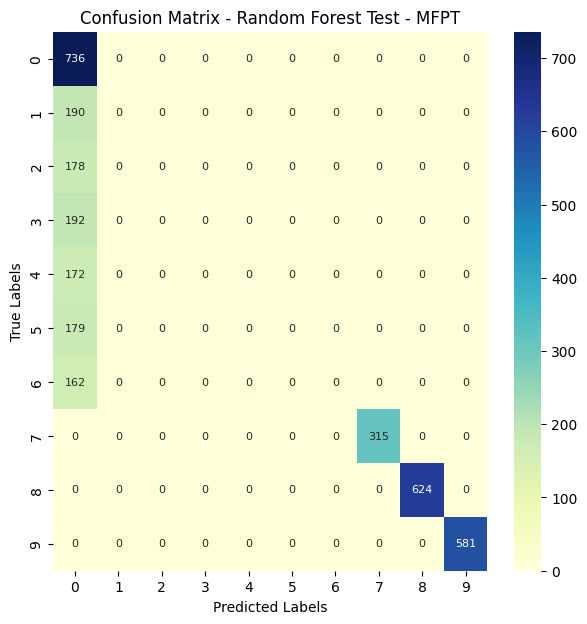

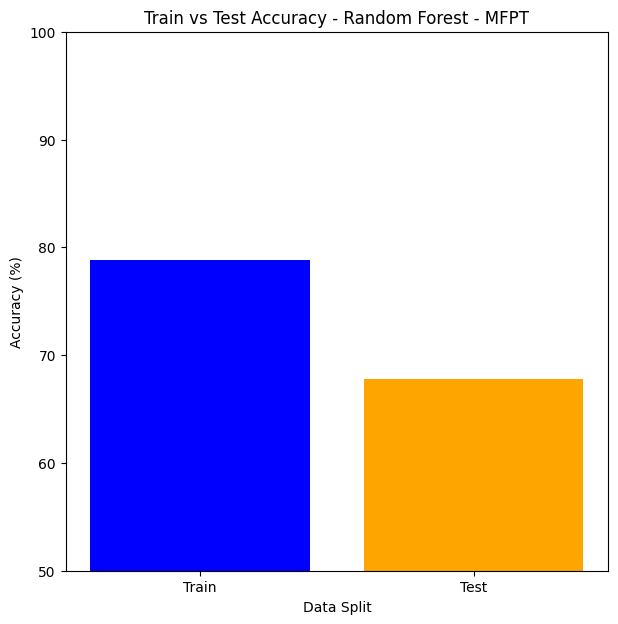

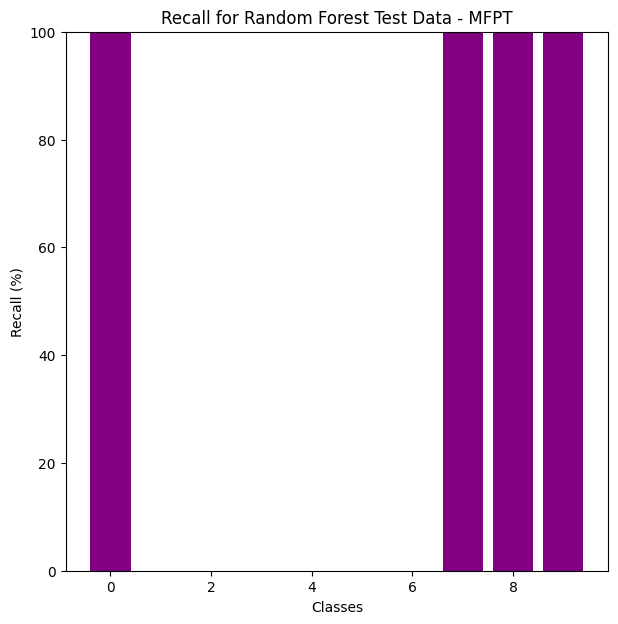

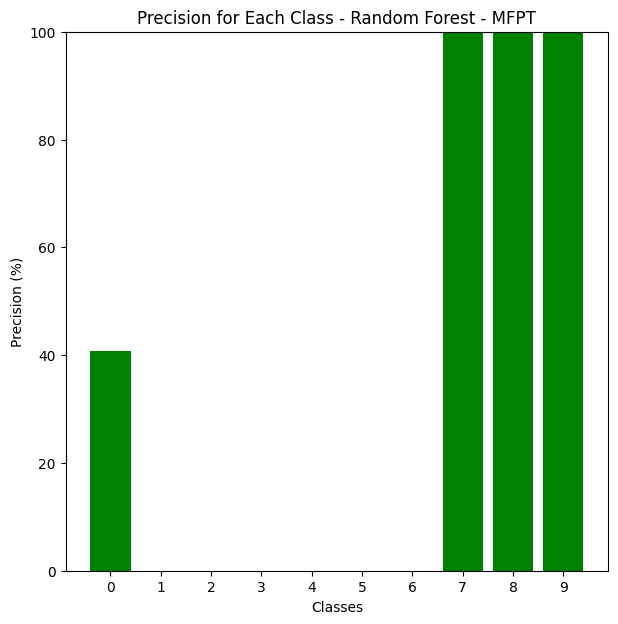

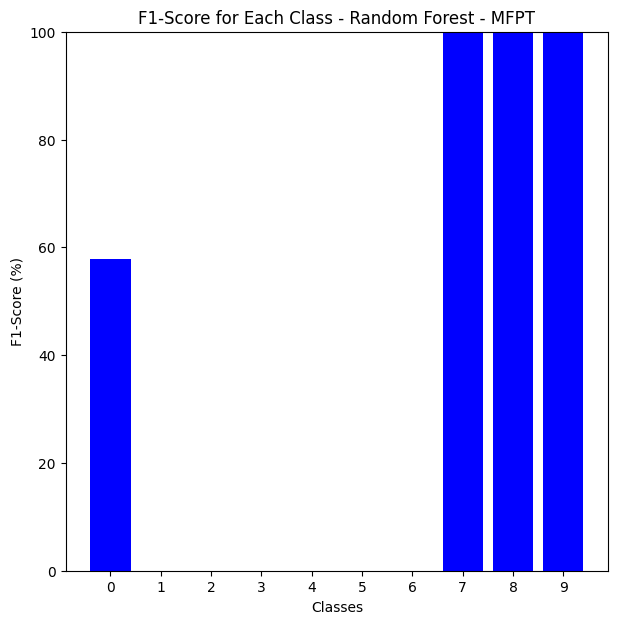

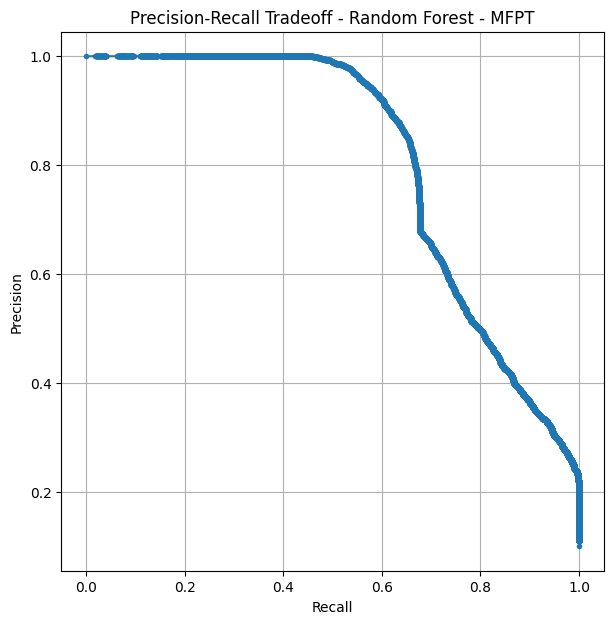

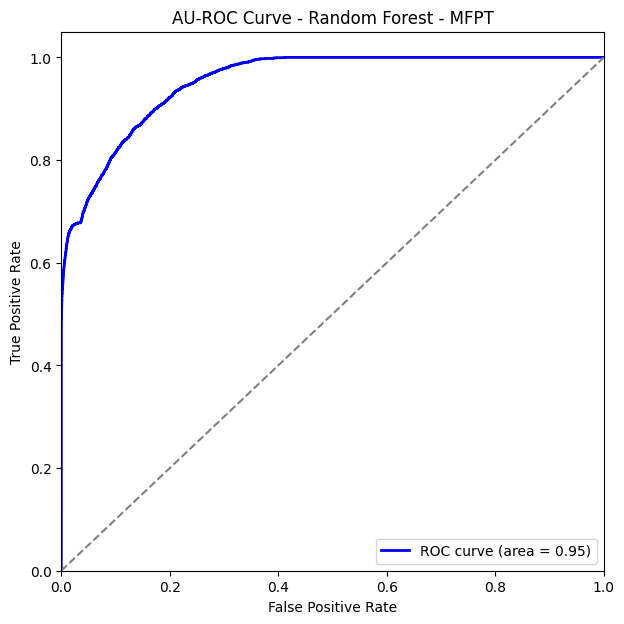

In [46]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - Random Forest Train - MFPT')
sns.heatmap(rf_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - Random Forest Test - MFPT')
sns.heatmap(rf_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - Random Forest'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - Random Forest - MFPT')
plt.bar([1, 2], [b_rf_train_accuracy, b_rf_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plotting 'Recall for Random Forest Test Data'
plt.figure(figsize=(7, 7))
plt.title('Recall for Random Forest Test Data - MFPT')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - Random Forest - MFPT')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - Random Forest - MFPT')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - Random Forest - MFPT')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - Random Forest - MFPT')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Gradient Boosting Classification Model**

In [47]:
start_time = time.time()
# Reshape the data - 1 dimensional feed
Input_1D = X.reshape([-1,2000,1])
# Gradient Boosting Classifier
b_gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
b_gb_model.fit(X_1D_train.reshape(len(X_1D_train), -1), np.argmax(y_1D_train, axis=1))

b_gb_train_accuracy = b_gb_model.score(X_1D_train.reshape(len(X_1D_train), -1), np.argmax(y_1D_train, axis=1)) * 100
b_gb_test_accuracy = b_gb_model.score(X_1D_test.reshape(len(X_1D_test), -1), np.argmax(y_1D_test, axis=1)) * 100

print('Gradient Boosting train accuracy - MFPT =', b_gb_train_accuracy)
print('Gradient Boosting test accuracy - MFPT =', b_gb_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(b_gb_model, open(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Models/b_gb_model', 'wb'))

Gradient Boosting train accuracy - MFPT = 96.26477067895053
Gradient Boosting test accuracy - MFPT = 72.72454190447581
Training time: 6358.36 seconds


**Calculation of Performance metrics**

In [48]:
# Predict on test data
y_pred = b_gb_model.predict(X_1D_test.reshape(len(X_1D_test), -1))
y_true = np.argmax(y_1D_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_pred_proba = b_gb_model.predict_proba(X_1D_test.reshape(len(X_1D_test), -1))
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
gb_train_pred = b_gb_model.predict(X_1D_train.reshape(len(X_1D_train), -1))
gb_train_cm = confusion_matrix(np.argmax(y_1D_train, axis=1), gb_train_pred)
gb_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for Gradient Boosting - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [b_gb_train_accuracy, b_gb_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
b_gb_train_accuracy = b_gb_train_accuracy
b_gb_test_accuracy = b_gb_test_accuracy
b_gb_recall_avg = recall_avg
b_gb_precision_avg = precision_avg
b_gb_f1_avg = f1_avg
b_gb_roc_auc = roc_auc

metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for Gradient Boosting - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

Class-wise Metrics for Gradient Boosting - MFPT:
Class Label     Recall  Precision   F1-Score
    Class 0  99.728261  55.563967  71.366067
    Class 1  25.263158  42.857143  31.788079
    Class 2   7.303371  34.210526  12.037037
    Class 3  27.083333  37.142857  31.325301
    Class 4   1.162791  11.764706   2.116402
    Class 5  26.256983  35.338346  30.128205
    Class 6   3.086420  10.416667   4.761905
    Class 7 100.000000 100.000000 100.000000
    Class 8 100.000000 100.000000 100.000000
    Class 9 100.000000 100.000000 100.000000
    Average  48.988432  52.729421  48.352300

Overall Performance Metrics for Gradient Boosting - MFPT:
           Metric     Value
   Train Accuracy 96.264771
    Test Accuracy 72.724542
   Average Recall 48.988432
Average Precision 52.729421
 Average F1-Score 48.352300
          ROC AUC  0.971062


**Plot results - GB Model**

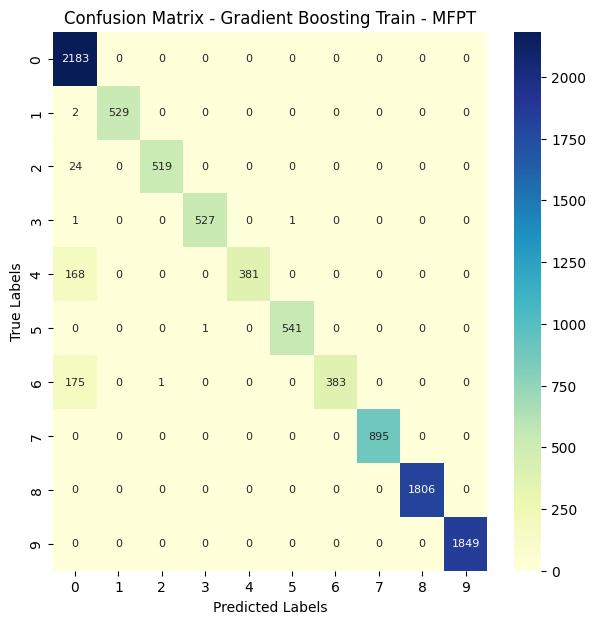

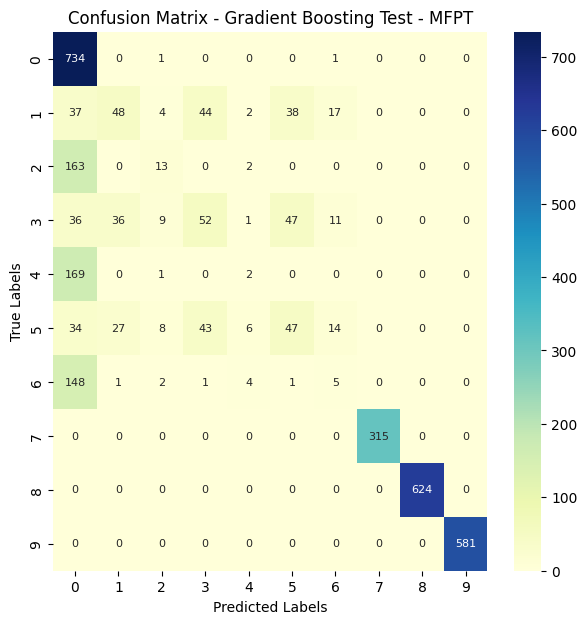

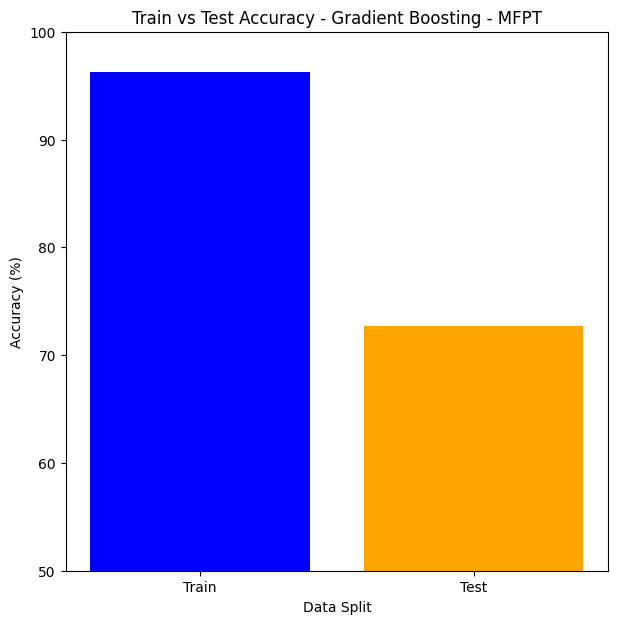

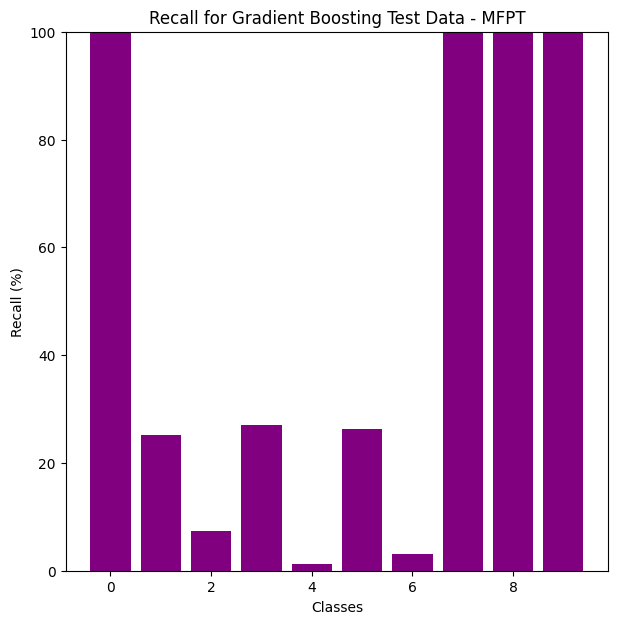

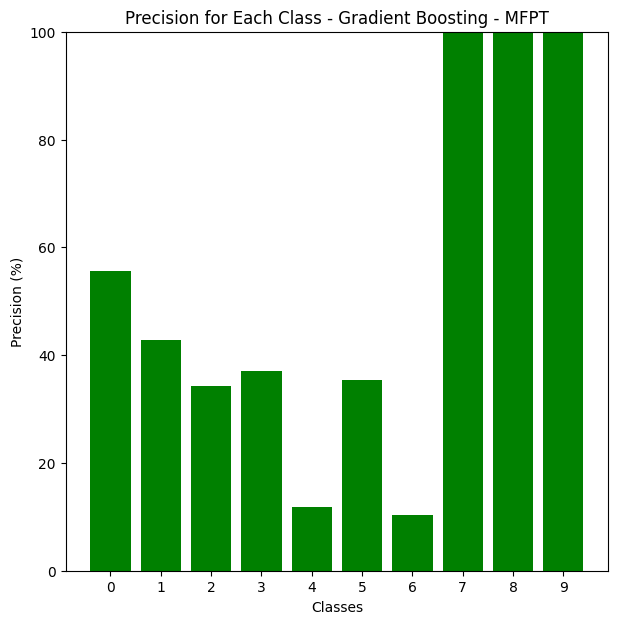

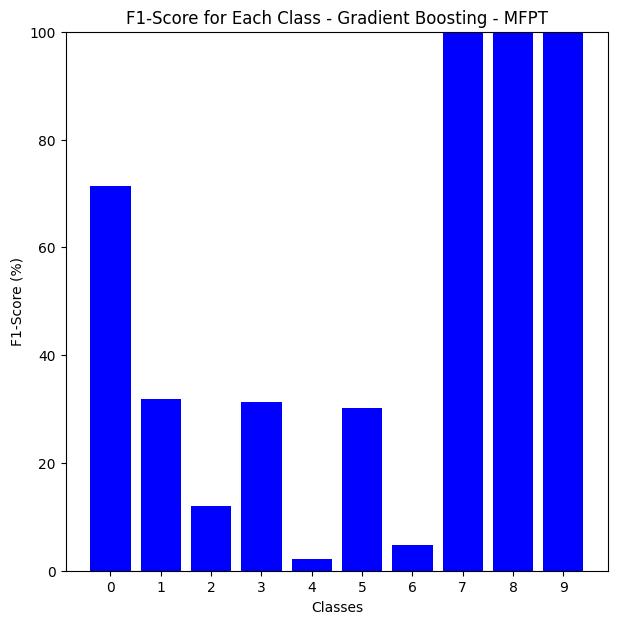

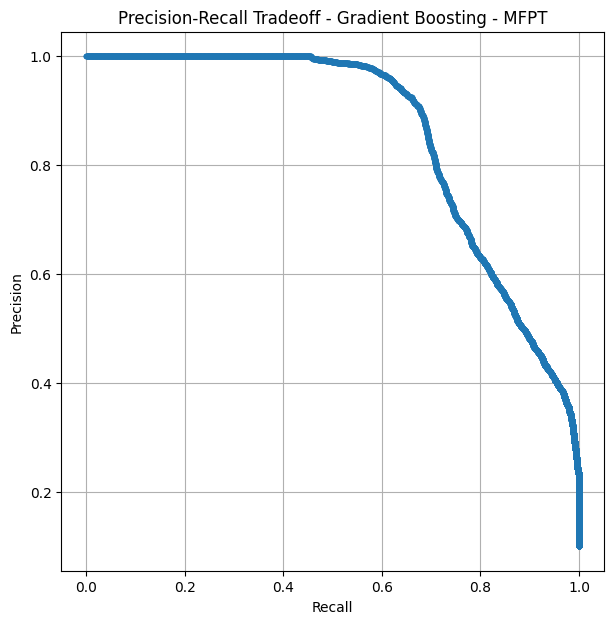

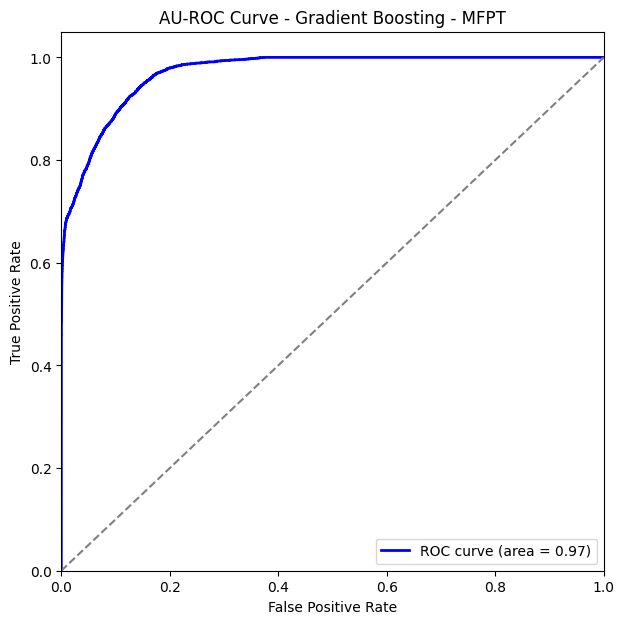

In [49]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - Gradient Boosting Train - MFPT')
sns.heatmap(gb_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - Gradient Boosting Test - MFPT')
sns.heatmap(gb_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - Gradient Boosting'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - Gradient Boosting - MFPT')
plt.bar([1, 2], [b_gb_train_accuracy, b_gb_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plotting 'Recall for Gradient Boosting Test Data'
plt.figure(figsize=(7, 7))
plt.title('Recall for Gradient Boosting Test Data - MFPT')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - Gradient Boosting - MFPT')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - Gradient Boosting - MFPT')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - Gradient Boosting - MFPT')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - Gradient Boosting - MFPT')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Recurrent Neural Network Classification Model**

In [50]:
start_time = time.time()
# Reshape the data - 1 dimensional feed
Input = X.reshape([-1,2000,1])

# Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(Input, Y_CNN, train_size=0.75, test_size=0.25, random_state=101)

# Define the RNN Classification model
class b_RNN_Model():
    def __init__(self):
        self.model = self.CreateModel()

    def CreateModel(self):
        model = models.Sequential([
            layers.SimpleRNN(32, return_sequences=True),
            layers.Flatten(),
            layers.Dense(10),
            layers.Softmax()
        ])
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model

# Initialize KFold for cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=101)
accuracy_rnn = []

# Train the RNN model
for train_idx, test_idx in kfold.split(X_train, y_train):
    Classification_b_RNN = b_RNN_Model()
    history = Classification_b_RNN.model.fit(X_train[train_idx], y_train[train_idx], verbose=1, epochs=10)

    # Evaluate the accuracy of the model on the validation set
    kf_loss, kf_accuracy = Classification_b_RNN.model.evaluate(X_train[test_idx], y_train[test_idx])
    accuracy_rnn.append(kf_accuracy)

# Train Accuracy
b_RNN_train_accuracy = np.average(accuracy_rnn) * 100
print('RNN train accuracy - MFPT =', b_RNN_train_accuracy)

# Evaluate the accuracy of the model on the test set
RNN_test_loss, b_RNN_test_accuracy = Classification_b_RNN.model.evaluate(X_test, y_test)
b_RNN_test_accuracy *= 100
print('RNN test accuracy - MFPT =', b_RNN_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(Classification_b_RNN.model, open(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Models/b_RNN_model', 'wb'))

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 235ms/step - accuracy: 0.6530 - loss: 1.5096
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 231ms/step - accuracy: 0.8784 - loss: 0.4364
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 233ms/step - accuracy: 0.9312 - loss: 0.2293
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 233ms/step - accuracy: 0.9469 - loss: 0.1700
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 233ms/step - accuracy: 0.9567 - loss: 0.1316
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 234ms/step - accuracy: 0.9408 - loss: 0.1963
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 232ms/step - accuracy: 0.9614 - loss: 0.1147
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 233ms/step - accuracy: 0.9425 - loss: 0.2235
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 233ms/step - accuracy: 0.9722 - loss: 0.1004
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 233ms/step - accuracy: 0.9809 - loss: 0.0590
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.7467 - loss: 3.9198
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━

**Calculation of Performance metrics**

In [51]:
# Predict on test data
y_pred_proba = Classification_b_RNN.model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
y_pred_train = np.argmax(Classification_b_RNN.model.predict(X_train), axis=1)
rnn_train_cm = confusion_matrix(np.argmax(y_train, axis=1), y_pred_train)
rnn_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for RNN - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [b_RNN_train_accuracy, b_RNN_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
b_RNN_train_accuracy = b_RNN_train_accuracy
b_RNN_test_accuracy = b_RNN_test_accuracy
b_recall_RNN_avg = recall_avg
b_precision_RNN_avg = precision_avg
b_f1_RNN_avg = f1_avg
b_roc_auc_RNN = roc_auc

metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for RNN - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step
Class-wise Metrics for RNN - MFPT:
Class Label     Recall  Precision   F1-Score
    Class 0  98.641304  97.580645  98.108108
    Class 1  48.947368  44.285714  46.500000
    Class 2  33.146067  33.333333  33.239437
    Class 3  48.437500  36.328125  41.517857
    Class 4  30.232558  26.943005  28.493151
    Class 5  26.256983  44.339623  32.982456
    Class 6  17.283951  25.454545  20.588235
    Class 7 100.000000  98.746082  99.369085
    Class 8 100.000000 100.000000 100.000000
    Class 9 100.000000  98.474576  99.231426
    Average  60.294573  60.548565  60.002976

Overall Performance Metrics for RNN - MFPT:
           Metric     Value
   Train Accuracy 75.896466
    Test Accuracy 78.642237
   Average Recall 60.294573
Average Precision 60.548565
 Average F1-Score 60.002976
          ROC AUC  0.977369


**Plot results - RNN Model**

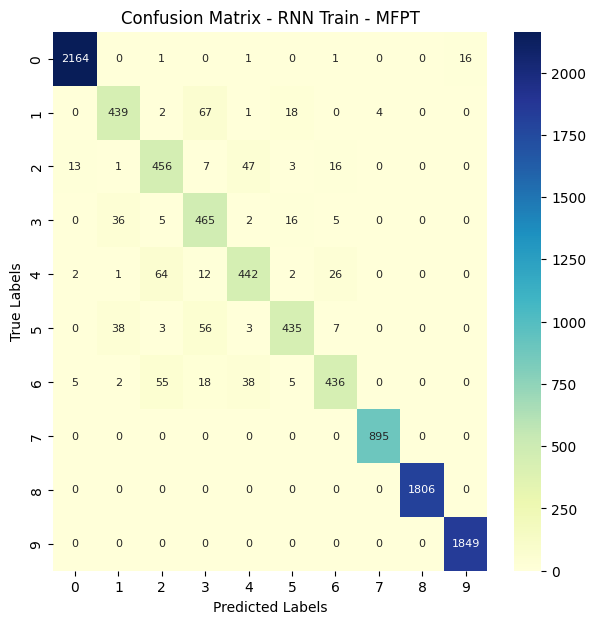

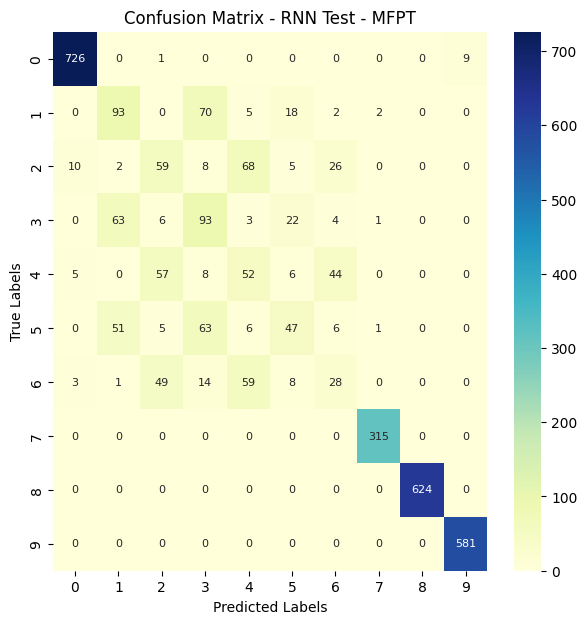

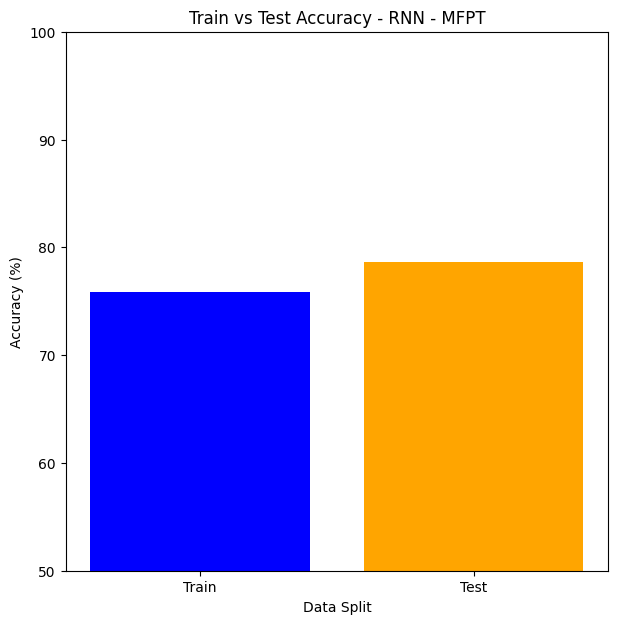

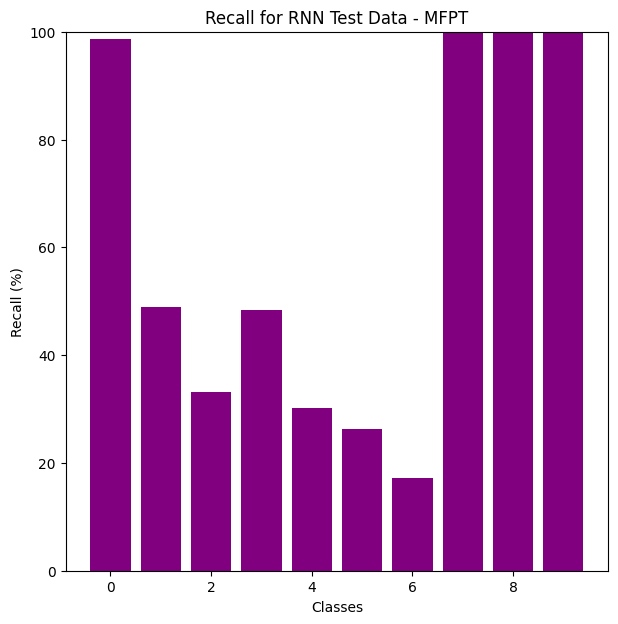

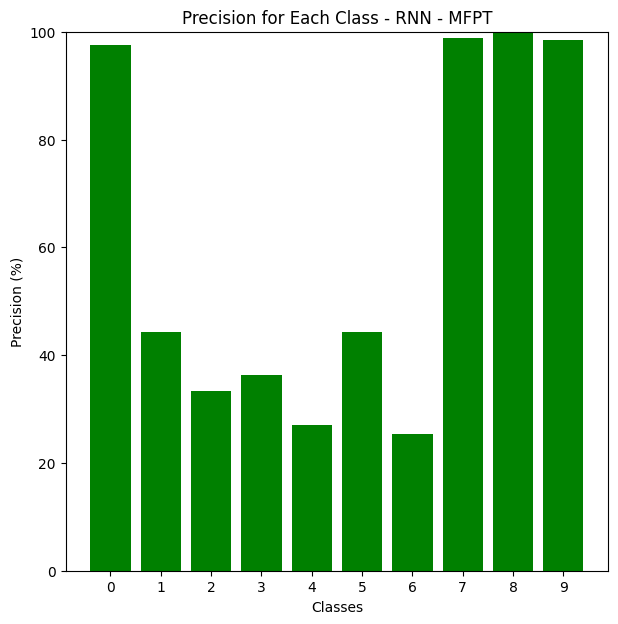

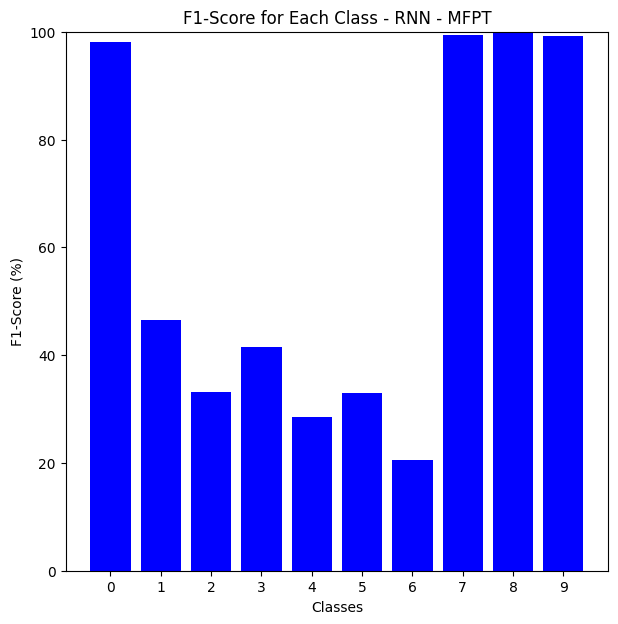

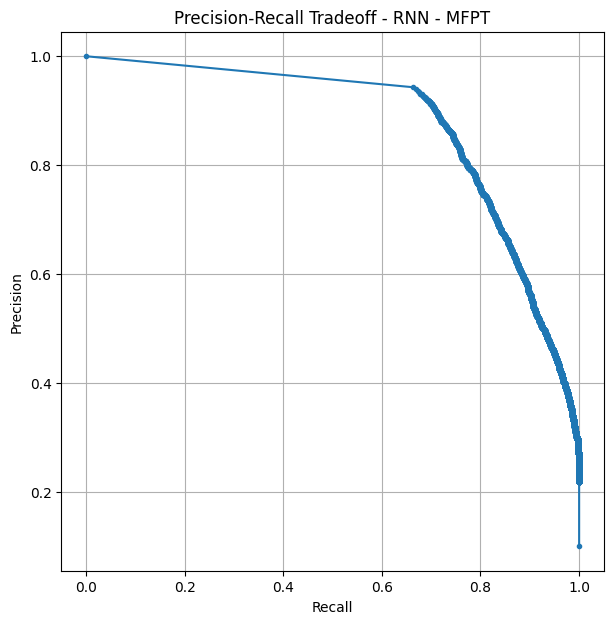

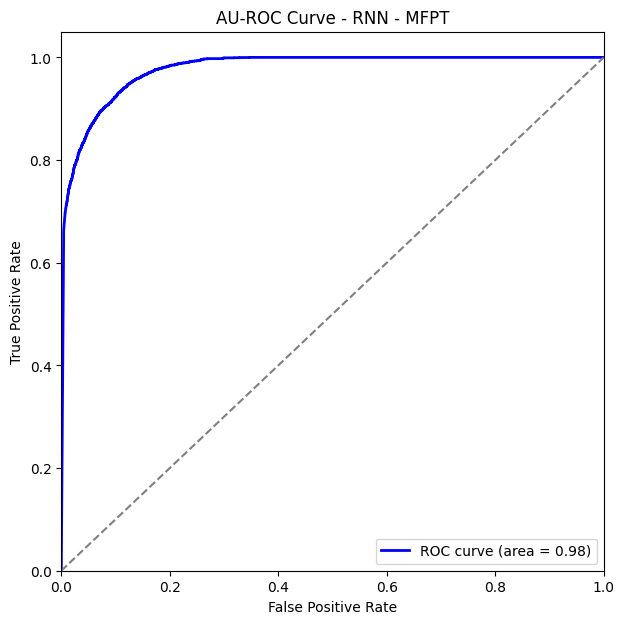

In [52]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - RNN Train - MFPT')
sns.heatmap(rnn_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - RNN Test - MFPT')
sns.heatmap(rnn_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - RNN'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - RNN - MFPT')
plt.bar([1, 2], [b_RNN_train_accuracy, b_RNN_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plotting 'Recall for RNN Test Data'
plt.figure(figsize=(7, 7))
plt.title('Recall for RNN Test Data - MFPT')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - RNN - MFPT')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - RNN - MFPT')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff
# Binarize labels for precision-recall curve
y_test_bin = label_binarize(y_true, classes=range(10))
# Flatten predicted probabilities and true labels
y_pred_proba_flat = y_pred_proba[:, 1]
# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - RNN - MFPT')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - RNN - MFPT')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**1-Dimensional Convolutional Neural Network Classification Model**

In [80]:
start_time = time.time()
# Reshape the data - 1 dimensional feed
Input_1D = X.reshape([-1,2000,1])

# Test-Train Split
X_1D_train, X_1D_test, y_1D_train, y_1D_test = train_test_split(Input_1D, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)

# Define the CNN Classification model
class b_CNN_1D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.Conv1D(filters=16, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=32, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Flatten(),
        #layers.InputLayer(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model


accuracy_1D = []

# Train the model
for train, test in kfold.split(X_1D_train,y_1D_train):
  Classification_b_1D = b_CNN_1D()
  history = Classification_b_1D.model.fit(X_1D_train[train], y_1D_train[train], verbose=1, epochs=12)

  # Evaluate the accuracy of the model on the training set
  kf_loss, kf_accuracy = Classification_b_1D.model.evaluate(X_1D_train[test], y_1D_train[test])
  accuracy_1D.append(kf_accuracy)

b_CNN_1D_train_accuracy = np.average(accuracy_1D)*100
print('CNN 1D train accuracy - MFPT =', b_CNN_1D_train_accuracy)


# Evaluate the accuracy of the model on the test set
CNN_1D_test_loss, b_CNN_1D_test_accuracy = Classification_b_1D.model.evaluate(X_1D_test, y_1D_test)
b_CNN_1D_test_accuracy*=100
print('CNN 1D test accuracy - MFPT =', b_CNN_1D_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(Classification_b_1D.model, open(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Models/b_CNN_1D_model', 'wb'))

Epoch 1/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6384 - loss: 1.0838
Epoch 2/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9092 - loss: 0.2256
Epoch 3/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9405 - loss: 0.1454
Epoch 4/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9555 - loss: 0.1032
Epoch 5/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9657 - loss: 0.0850
Epoch 6/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9781 - loss: 0.0801
Epoch 7/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9859 - loss: 0.0471
Epoch 8/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9867 - loss: 0.0335
Epoch 9/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9930 - loss: 0.0270
Epoch 10/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9954 - loss: 0.0163
Epoch 11/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9966 - loss: 0.0107
Epoch 12/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/s

**Calculation of Performance metrics**

In [81]:
# Predict on test data
y_pred_proba = Classification_b_1D.model.predict(X_1D_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_1D_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
y_pred_train = np.argmax(Classification_b_1D.model.predict(X_1D_train), axis=1)
cnn_1d_train_cm = confusion_matrix(np.argmax(y_1D_train, axis=1), y_pred_train)
cnn_1d_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for CNN 1D - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [b_CNN_1D_train_accuracy, b_CNN_1D_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
b_CNN_1D_train_accuracy = b_CNN_1D_train_accuracy
b_CNN_1D_test_accuracy = b_CNN_1D_test_accuracy
b_recall_CNN_1D_avg = recall_avg
b_precision_CNN_1D_avg = precision_avg
b_f1_CNN_1D_avg = f1_avg
b_roc_auc_CNN_1D = roc_auc

metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for CNN 1D - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Class-wise Metrics for CNN 1D - MFPT:
Class Label     Recall  Precision   F1-Score
    Class 0 100.000000 100.000000 100.000000
    Class 1  99.473684  95.454545  97.422680
    Class 2 100.000000  98.888889  99.441341
    Class 3  90.625000  95.081967  92.800000
    Class 4  98.255814  94.413408  96.296296
    Class 5  95.530726  95.000000  95.264624
    Class 6  93.827160  99.346405  96.507937
    Class 7 100.000000 100.000000 100.000000
    Class 8 100.000000 100.000000 100.000000
    Class 9 100.000000 100.000000 100.000000
    Average  97.771238  97.818521  97.773288

Overall Performance Metrics for CNN 1D - MFPT:
           Metric     Value
   Train Accuracy 98.778276
    Test Accuracy 98.798436
   Average Recall 97.771238
Average Precision 97.818521
 Average F1-Score 97.773288
          ROC AUC  0.999938


**Plot results - CNN-1D Model**

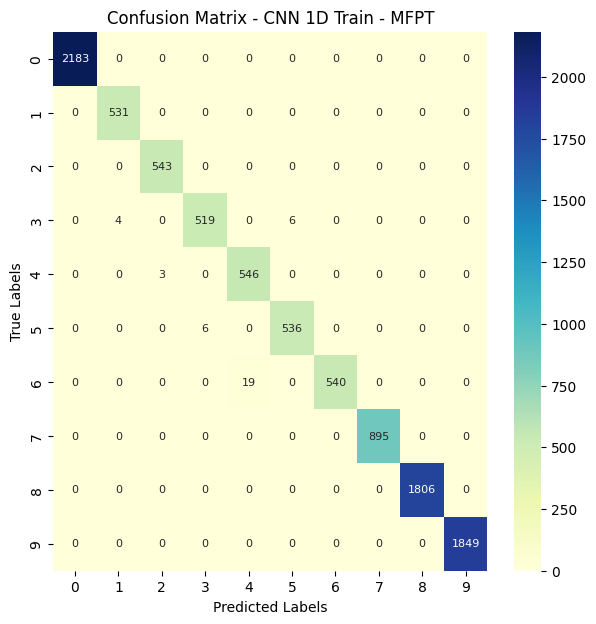

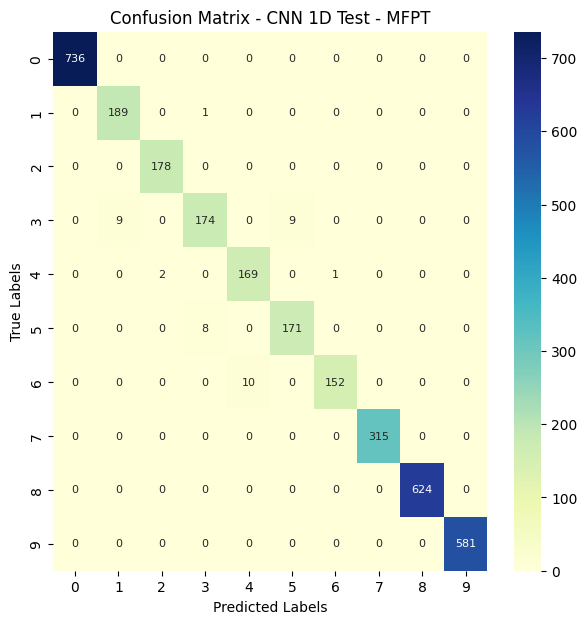

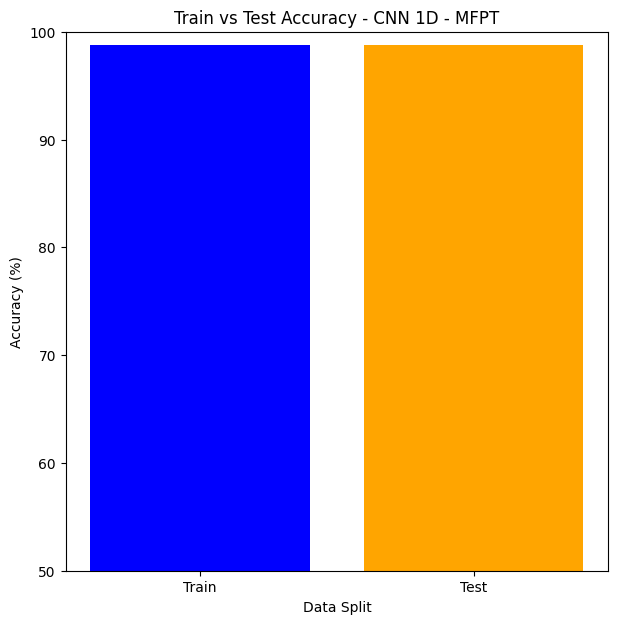

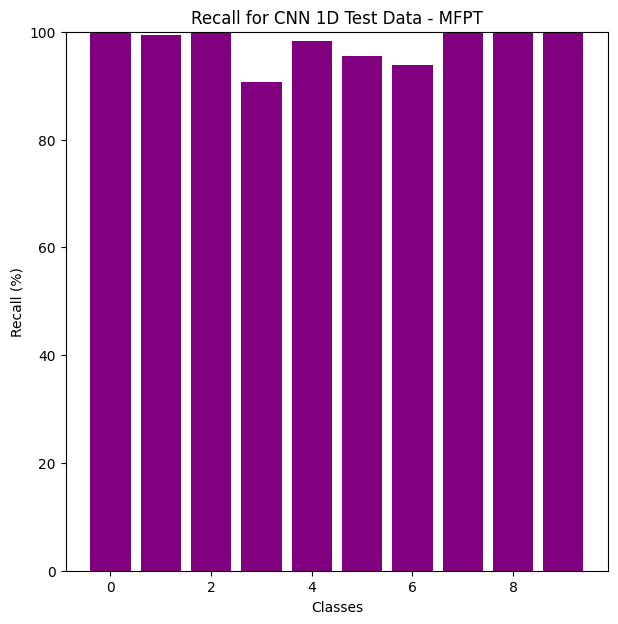

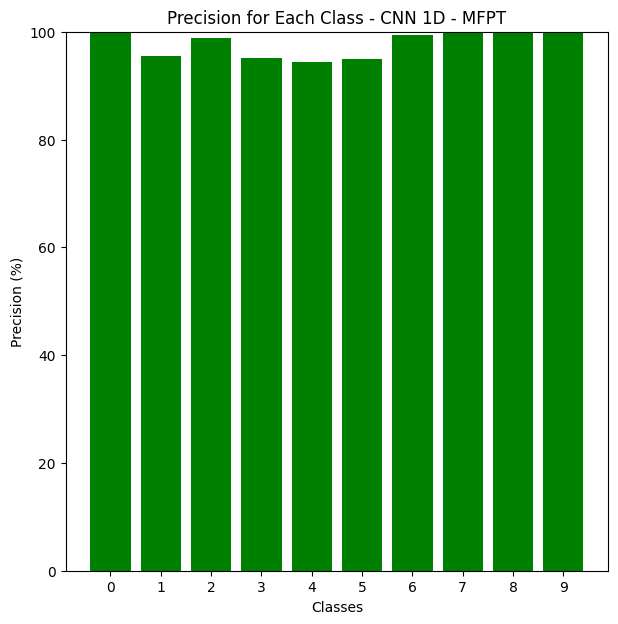

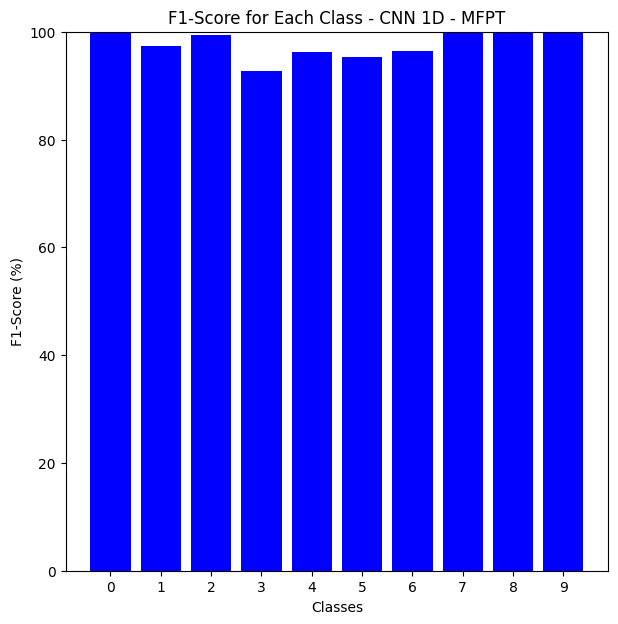

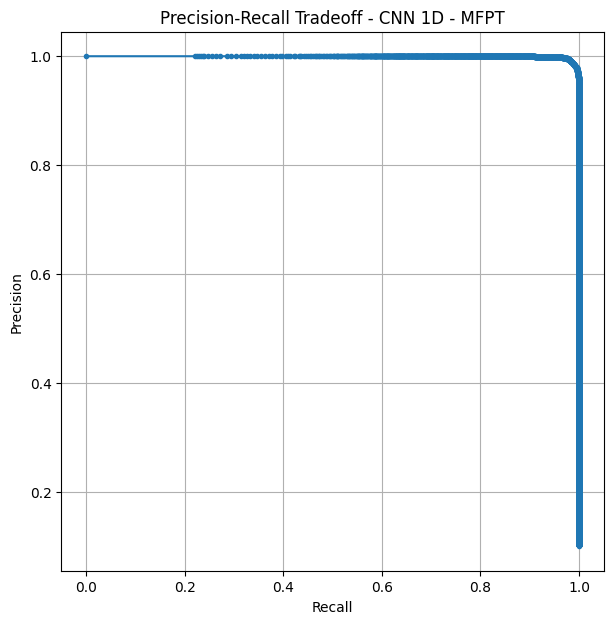

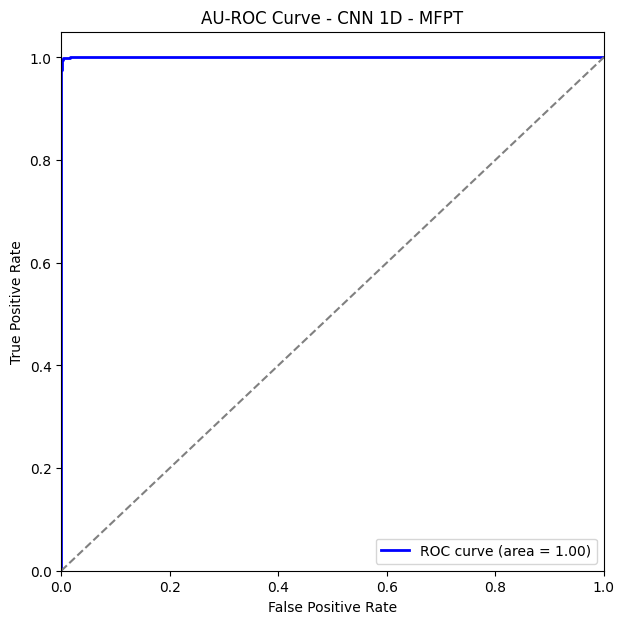

In [82]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - CNN 1D Train - MFPT')
sns.heatmap(cnn_1d_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - CNN 1D Test - MFPT')
sns.heatmap(cnn_1d_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - CNN 1D'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - CNN 1D - MFPT')
plt.bar([1, 2], [b_CNN_1D_train_accuracy, b_CNN_1D_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plotting 'Recall for CNN 1D Test Data'
plt.figure(figsize=(7, 7))
plt.title('Recall for CNN 1D Test Data - MFPT')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - CNN 1D - MFPT')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - CNN 1D - MFPT')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - CNN 1D - MFPT')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - CNN 1D - MFPT')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**2-Dimensional Convolutional Neural Network Classification Model**

In [56]:
start_time = time.time()
# Reshape the data - 2 dimensional feed
Input_2D = X.reshape([-1,40,50,1])

# Test-Train Split
X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(Input_2D, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)

# Define the CNN Classification model
class b_CNN_2D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3),strides=(2,2), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3),strides=(2,2),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3),strides=(2,2),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Flatten(),
        #layers.InputLayer(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model


accuracy_2D = []

# Train the model
for train, test in kfold.split(X_2D_train,y_2D_train):
  Classification_b_2D = b_CNN_2D()
  history = Classification_b_2D.model.fit(X_2D_train[train], y_2D_train[train], verbose=1, epochs=12)

  # Evaluate the accuracy of the model on the training set
  kf_loss, kf_accuracy = Classification_b_2D.model.evaluate(X_2D_train[test], y_2D_train[test])
  accuracy_2D.append(kf_accuracy)

b_CNN_2D_train_accuracy = np.average(accuracy_2D)*100
print('CNN 2D train accuracy - MFPT =', b_CNN_2D_train_accuracy)


# Evaluate the accuracy of the model on the test set
CNN_2D_test_loss, b_CNN_2D_test_accuracy = Classification_b_2D.model.evaluate(X_2D_test, y_2D_test)
b_CNN_2D_test_accuracy*=100
print('CNN 2D test accuracy - MFPT =', b_CNN_2D_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(Classification_b_2D.model, open(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Models/b_CNN_2D_model', 'wb'))

Epoch 1/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5690 - loss: 1.2991
Epoch 2/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8300 - loss: 0.4200
Epoch 3/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8789 - loss: 0.2686
Epoch 4/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9090 - loss: 0.2142
Epoch 5/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9170 - loss: 0.1941
Epoch 6/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9354 - loss: 0.1466
Epoch 7/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9427 - loss: 0.1301
Epoch 8/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9471 - loss: 0.1318
Epoch 9/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9620 - loss: 0.0872
Epoch 10/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9651 - loss: 0.0774
Epoch 11/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9668 - loss: 0.0797
Epoch 12/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

**Calculation of Performance metrics**

In [57]:
# Predict on test data
y_pred_proba = Classification_b_2D.model.predict(X_2D_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_2D_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
y_pred_train = np.argmax(Classification_b_2D.model.predict(X_2D_train), axis=1)
cnn_2d_train_cm = confusion_matrix(np.argmax(y_2D_train, axis=1), y_pred_train)
cnn_2d_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for CNN 2D - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [b_CNN_2D_train_accuracy, b_CNN_2D_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
b_CNN_2D_train_accuracy = b_CNN_2D_train_accuracy
b_CNN_2D_test_accuracy = b_CNN_2D_test_accuracy
b_recall_CNN_2D_avg = recall_avg
b_precision_CNN_2D_avg = precision_avg
b_f1_CNN_2D_avg = f1_avg
b_roc_auc_CNN_2D = roc_auc

metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for CNN 2D - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Class-wise Metrics for CNN 2D - MFPT:
Class Label     Recall  Precision   F1-Score
    Class 0  99.728261 100.000000  99.863946
    Class 1  95.789474  95.789474  95.789474
    Class 2  98.314607  96.685083  97.493036
    Class 3  80.208333  71.962617  75.862069
    Class 4 100.000000  83.091787  90.765172
    Class 5  67.039106  81.632653  73.619632
    Class 6  77.160494  91.911765  83.892617
    Class 7 100.000000 100.000000 100.000000
    Class 8 100.000000 100.000000 100.000000
    Class 9 100.000000 100.000000 100.000000
    Average  91.824027  92.107338  91.728595

Overall Performance Metrics for CNN 2D - MFPT:
           Metric     Value
   Train Accuracy 95.493666
    Test Accuracy 95.584261
   Average Recall 91.824027
Average Precision 92.107338
 Average F1-Score 91.728595
          ROC AUC  0.999273


**Plot results - CNN-2D Model**

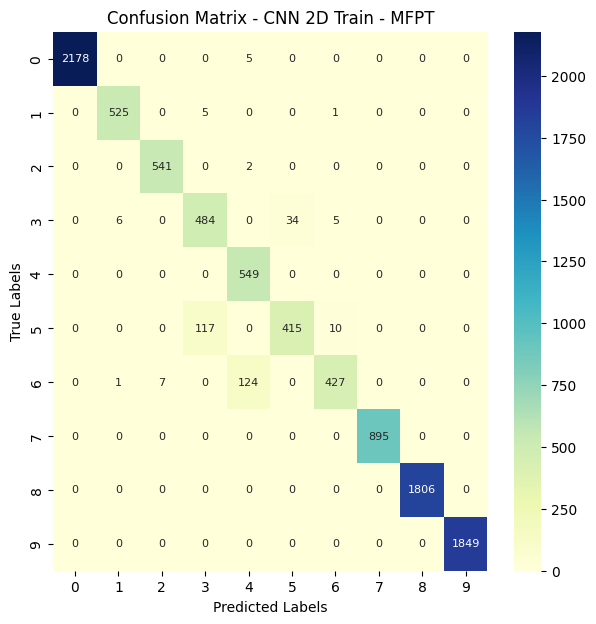

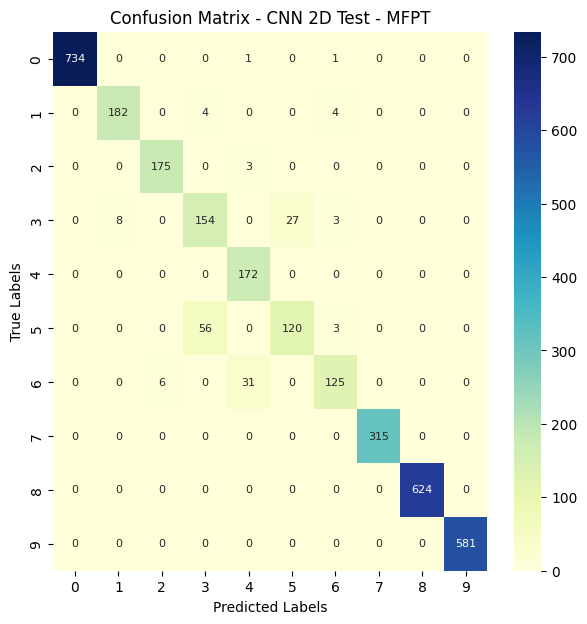

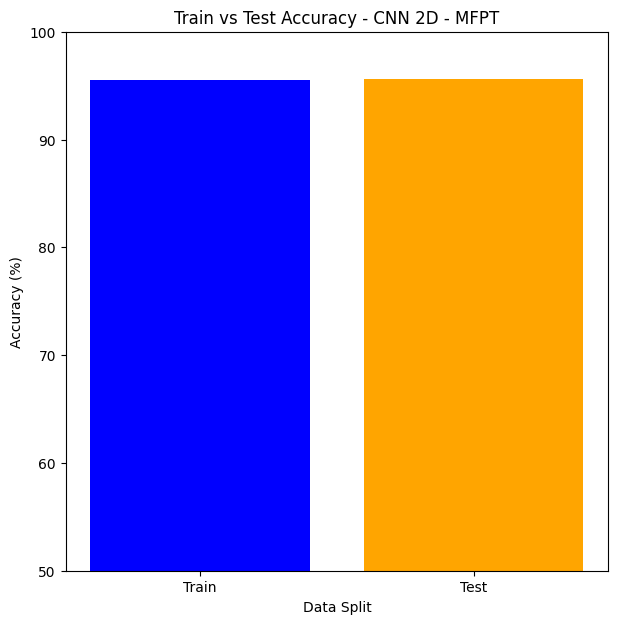

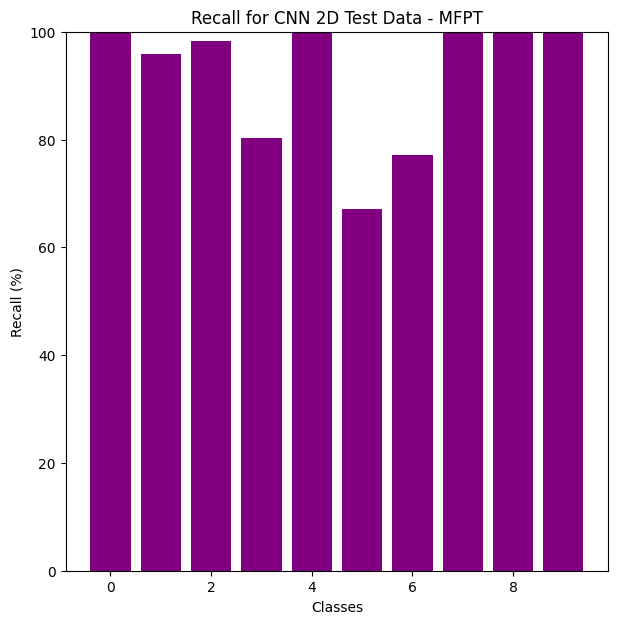

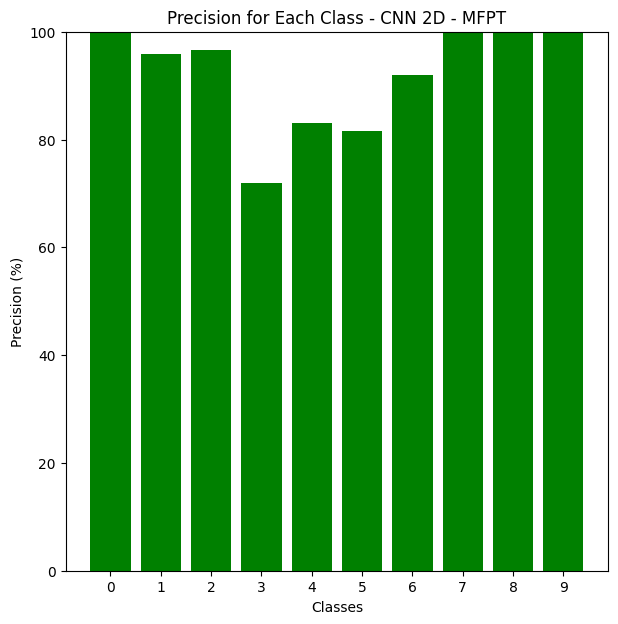

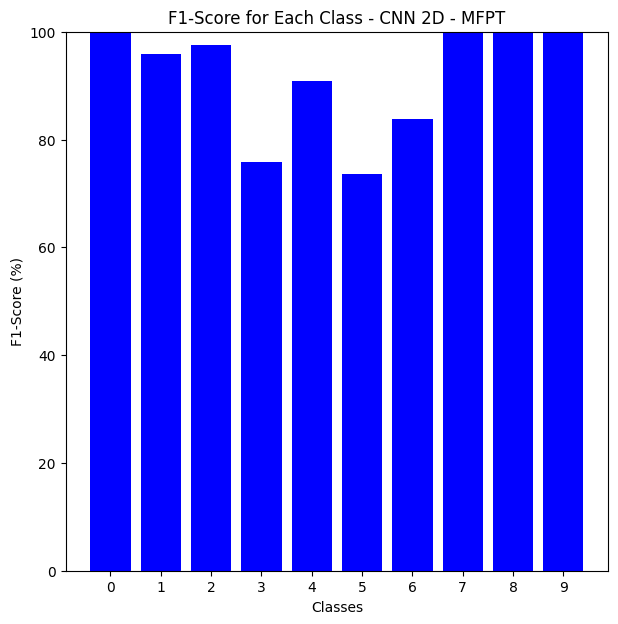

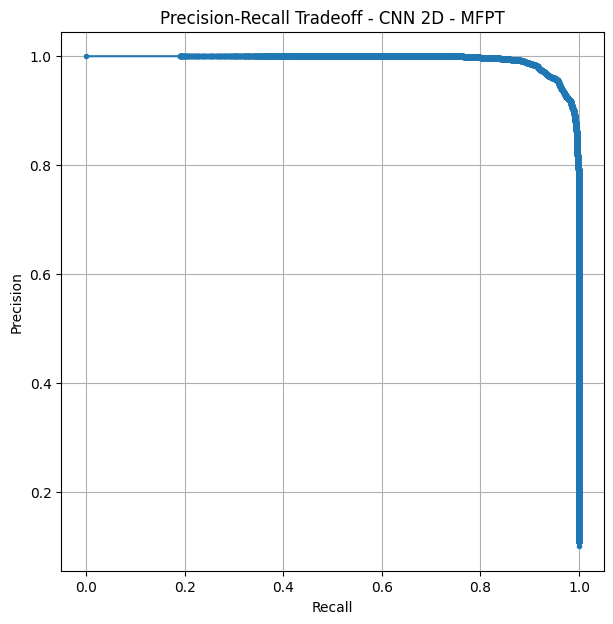

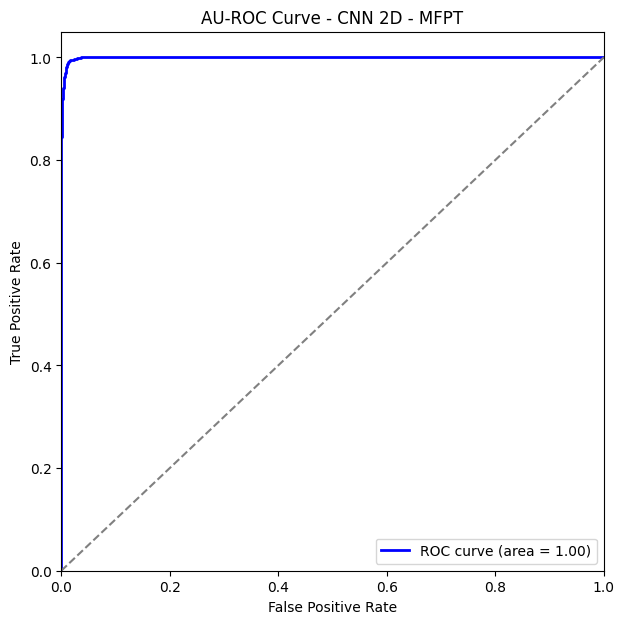

In [58]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - CNN 2D Train - MFPT')
sns.heatmap(cnn_2d_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - CNN 2D Test - MFPT')
sns.heatmap(cnn_2d_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - CNN 2D'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - CNN 2D - MFPT')
plt.bar([1, 2], [b_CNN_2D_train_accuracy, b_CNN_2D_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plotting 'Recall for CNN 2D Test Data'
plt.figure(figsize=(7, 7))
plt.title('Recall for CNN 2D Test Data - MFPT')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - CNN 2D - MFPT')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - CNN 2D - MFPT')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - CNN 2D - MFPT')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - CNN 2D - MFPT')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Long Short-Term Memory Recurrent Neural Network Classification Model**

In [59]:
start_time = time.time()
# Reshape the data - 1 dimensional feed
Input = X.reshape([-1,2000,1])

# Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(Input, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)

# Define the LSTM Classification model
class b_LSTM_Model():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.LSTM(32, return_sequences=True),
        layers.Flatten(),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model


accuracy = []

# Train the model
for train, test in kfold.split(X_train,y_train):
  b_Classification = b_LSTM_Model()
  history = b_Classification.model.fit(X_train[train], y_train[train], verbose=1, epochs=12)

  # Evaluate the accuracy of the model on the training set
  kf_loss, kf_accuracy = b_Classification.model.evaluate(X_train[test], y_train[test])
  accuracy.append(kf_accuracy)

b_LSTM_train_accuracy = np.average(accuracy)*100
print('LSTM train accuracy - MFPT =', b_LSTM_train_accuracy)


# Evaluate the accuracy of the model on the test set
LSTM_test_loss, b_LSTM_test_accuracy = b_Classification.model.evaluate(X_test, y_test)
b_LSTM_test_accuracy*=100
print('LSTM test accuracy - MFPT =', b_LSTM_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(b_Classification.model, open(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Models/b_LSTM_model', 'wb'))

Epoch 1/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 256ms/step - accuracy: 0.6716 - loss: 0.9377
Epoch 2/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 253ms/step - accuracy: 0.9172 - loss: 0.2365
Epoch 3/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 255ms/step - accuracy: 0.9680 - loss: 0.1201
Epoch 4/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 255ms/step - accuracy: 0.9799 - loss: 0.0638
Epoch 5/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 256ms/step - accuracy: 0.9876 - loss: 0.0324
Epoch 6/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 257ms/step - accuracy: 0.9937 - loss: 0.0204
Epoch 7/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 256ms/step - accuracy: 0.9925 - loss: 0.0213
Epoch 8/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 255ms/step - accuracy: 0.9997 - loss: 0.0035
Epoch 9/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 255ms/step - accuracy: 0.9990 - loss: 0.0037
Epoch 10/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 255ms/step - accuracy: 0.9999 - loss: 0.0019
Epoch 11/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 257ms/step - accuracy: 1.0000 - loss: 2.8028e-04
Epoch 12/12
250

**Calculation of Performance metrics**

In [60]:
# Predict on test data
y_pred_proba = b_Classification.model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
y_pred_train = np.argmax(b_Classification.model.predict(X_train), axis=1)
lstm_train_cm = confusion_matrix(np.argmax(y_train, axis=1), y_pred_train)
lstm_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for LSTM - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [b_LSTM_train_accuracy, b_LSTM_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
b_LSTM_train_accuracy = b_LSTM_train_accuracy
b_LSTM_test_accuracy = b_LSTM_test_accuracy
b_recall_LSTM_avg = recall_avg
b_precision_LSTM_avg = precision_avg
b_f1_LSTM_avg = f1_avg
b_roc_auc_LSTM = roc_auc

metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for LSTM - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step
Class-wise Metrics for LSTM - MFPT:
Class Label     Recall  Precision   F1-Score
    Class 0  99.728261  99.592944  99.660557
    Class 1  97.894737  78.813559  87.323944
    Class 2  94.943820  87.564767  91.105121
    Class 3  46.354167  54.268293  50.000000
    Class 4  88.953488  85.474860  87.179487
    Class 5  59.776536  61.494253  60.623229
    Class 6  71.604938  92.063492  80.555556
    Class 7 100.000000 100.000000 100.000000
    Class 8 100.000000 100.000000 100.000000
    Class 9 100.000000 100.000000 100.000000
    Average  85.925595  85.927217  85.644789

Overall Performance Metrics for LSTM - MFPT:
           Metric     Value
   Train Accuracy 93.671048
    Test Accuracy 92.340040
   Average Recall 85.925595
Average Precision 85.927217
 Average F1-Score 85.644789
          ROC AUC  0.995255


**Plot results - LSTM Model**

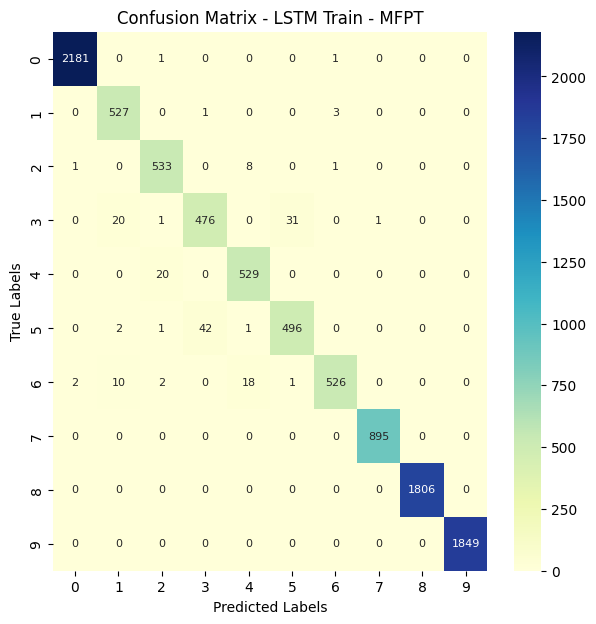

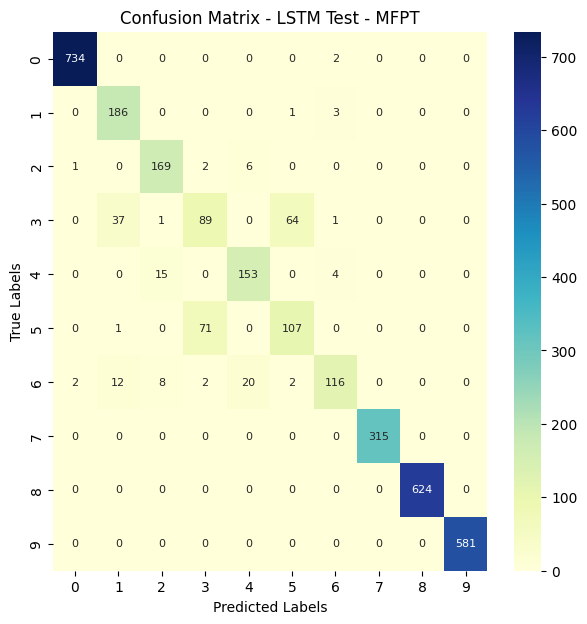

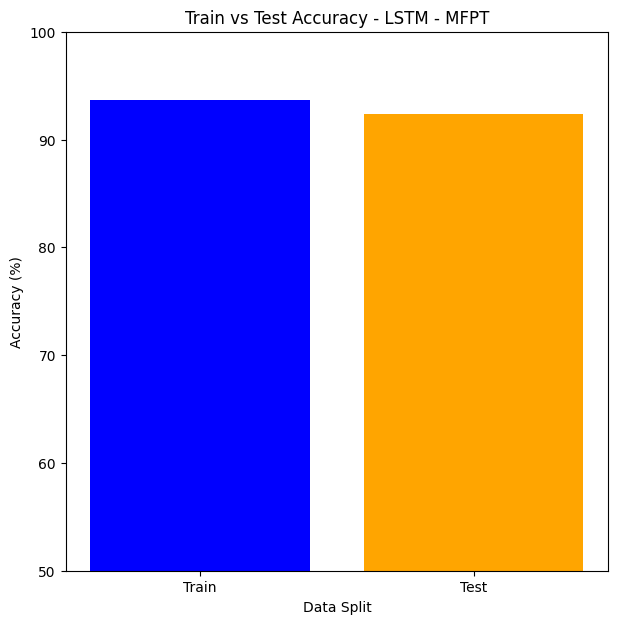

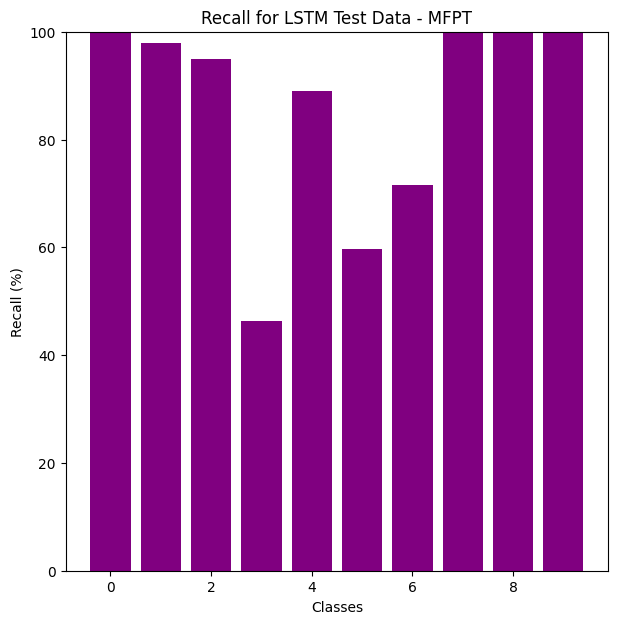

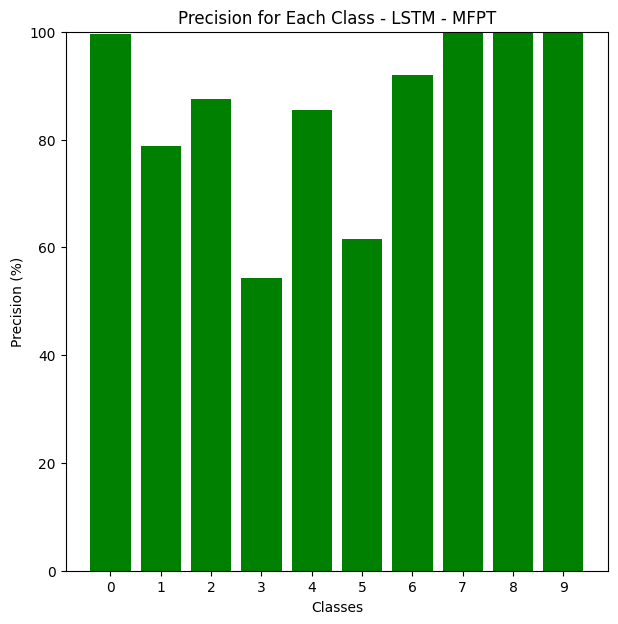

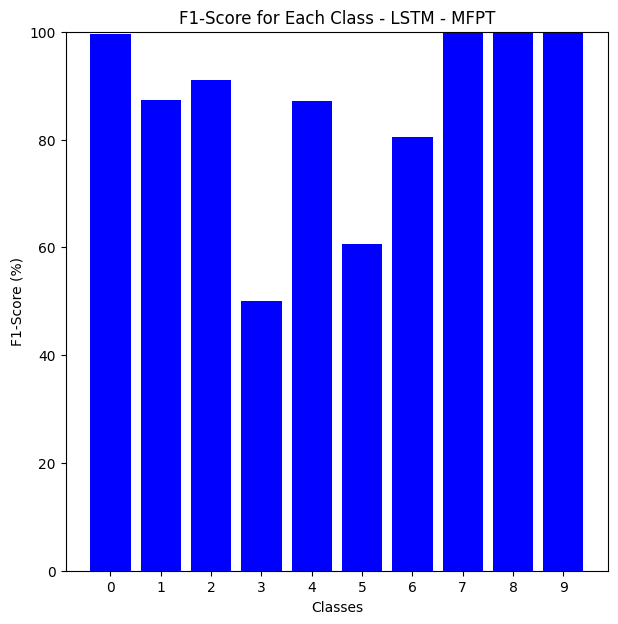

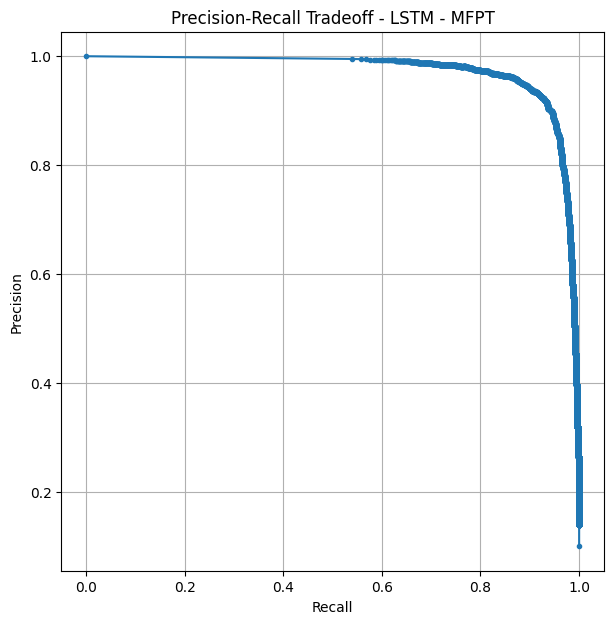

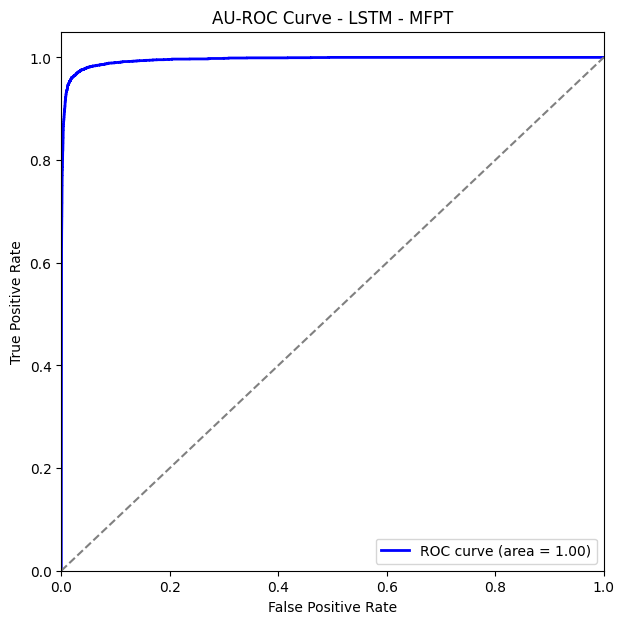

In [61]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - LSTM Train - MFPT')
sns.heatmap(lstm_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - LSTM Test - MFPT')
sns.heatmap(lstm_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - LSTM'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - LSTM - MFPT')
plt.bar([1, 2], [b_LSTM_train_accuracy, b_LSTM_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plotting 'Recall for LSTM Test Data'
plt.figure(figsize=(7, 7))
plt.title('Recall for LSTM Test Data - MFPT')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - LSTM - MFPT')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - LSTM - MFPT')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - LSTM - MFPT')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - LSTM - MFPT')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Support Vector Machine Classification Model**

In [62]:
start_time = time.time()
# Reshape the data - 1 dimensional feed
Input_1D = X.reshape([-1,2000,1])

# Test-Train Split
X_1D_train, X_1D_test, y_1D_train, y_1D_test = train_test_split(Input_1D, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# SVM Classifier
b_SVM_model = SVC(kernel='linear', C=0.1, probability=True, random_state=42)
b_SVM_model.fit(X_1D_train.reshape(len(X_1D_train), -1), np.argmax(y_1D_train, axis=1))

b_SVM_train_accuracy = b_SVM_model.score(X_1D_train.reshape(len(X_1D_train), -1), np.argmax(y_1D_train, axis=1)) * 100
b_SVM_test_accuracy = b_SVM_model.score(X_1D_test.reshape(len(X_1D_test), -1), np.argmax(y_1D_test, axis=1)) * 100

print('SVM train accuracy - MFPT =', b_SVM_train_accuracy)
print('SVM test accuracy - MFPT =', b_SVM_test_accuracy)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")
pickle.dump(b_SVM_model, open(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Models/b_SVM_model', 'wb'))

SVM train accuracy - MFPT = 100.0
SVM test accuracy - MFPT = 76.4193451486933
Training time: 214.37 seconds


**Calculation of Performance metrics**

In [63]:
# Predict on test data
y_pred_proba = b_SVM_model.predict_proba(X_1D_test.reshape(len(X_1D_test), -1))
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_1D_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
svm_train_pred = b_SVM_model.predict(X_1D_train.reshape(len(X_1D_train), -1))
svm_train_cm = confusion_matrix(np.argmax(y_1D_train, axis=1), svm_train_pred)
svm_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for SVM - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [b_SVM_train_accuracy, b_SVM_test_accuracy, recall_avg, precision_avg, f1_avg, roc_auc]
}
b_SVM_train_accuracy = b_SVM_train_accuracy
b_SVM_test_accuracy = b_SVM_test_accuracy
b_SVM_recall_avg = recall_avg
b_SVM_precision_avg = precision_avg
b_SVM_f1_avg = f1_avg
b_SVM_roc_auc = roc_auc
metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for SVM - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

Class-wise Metrics for SVM - MFPT:
Class Label     Recall  Precision   F1-Score
    Class 0  97.554348  97.554348  97.554348
    Class 1  50.000000  45.893720  47.858942
    Class 2  14.606742  21.311475  17.333333
    Class 3  44.791667  36.909871  40.470588
    Class 4  31.976744  32.163743  32.069971
    Class 5  27.932961  31.250000  29.498525
    Class 6  27.777778  25.000000  26.315789
    Class 7 100.000000 100.000000 100.000000
    Class 8 100.000000 100.000000 100.000000
    Class 9 100.000000 100.000000 100.000000
    Average  59.464024  59.008316  59.110150

Overall Performance Metrics for SVM - MFPT:
           Metric      Value
   Train Accuracy 100.000000
    Test Accuracy  76.419345
   Average Recall  59.464024
Average Precision  59.008316
 Average F1-Score  59.110150
          ROC AUC   0.982900


**Plot results - SVM Model**

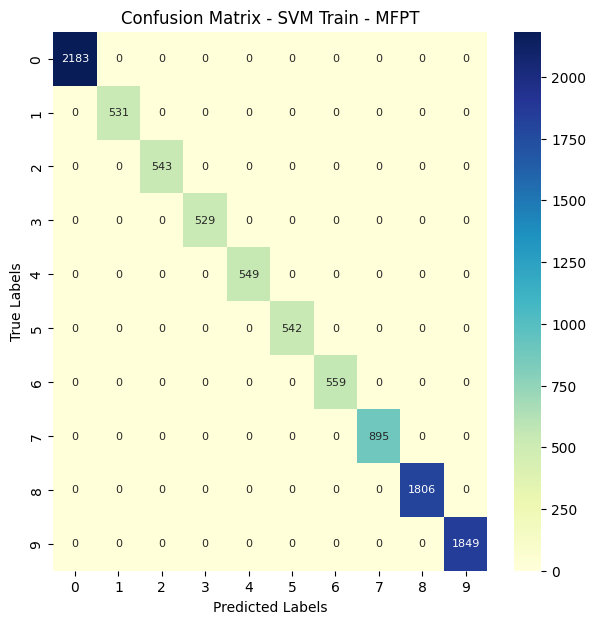

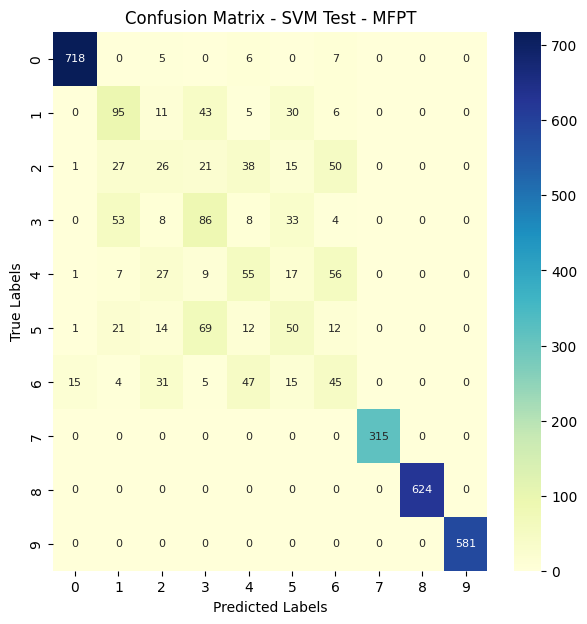

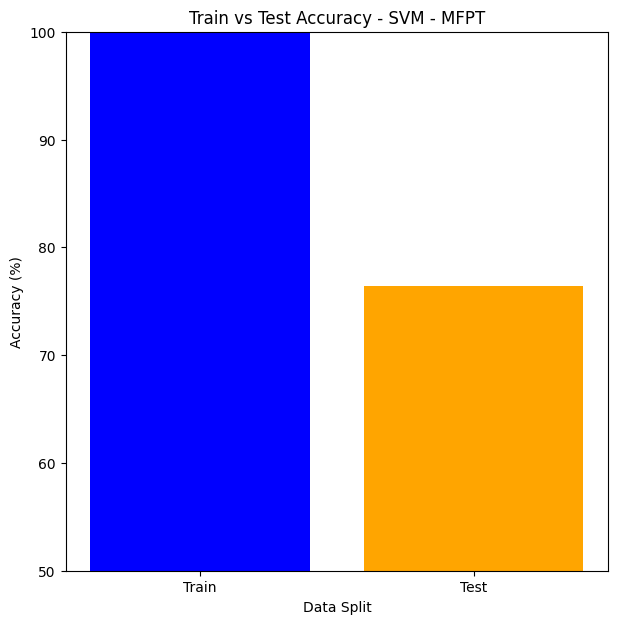

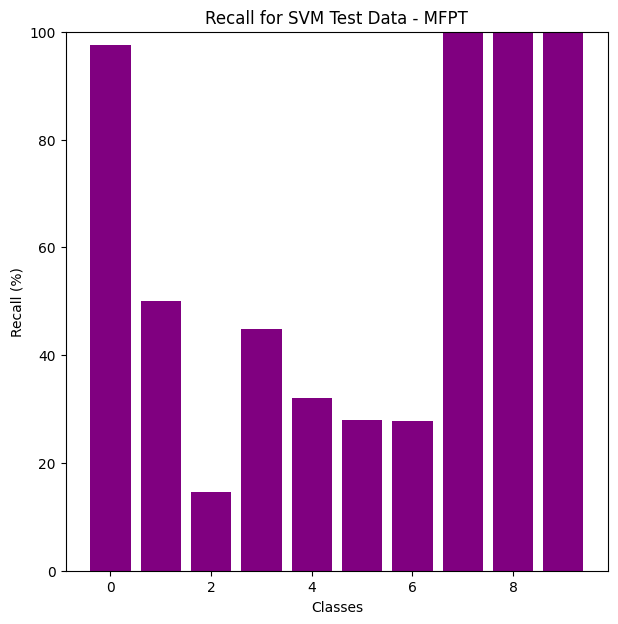

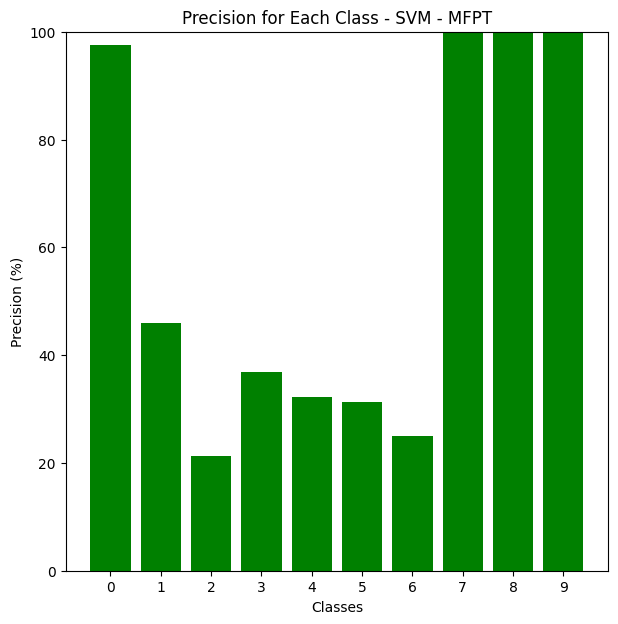

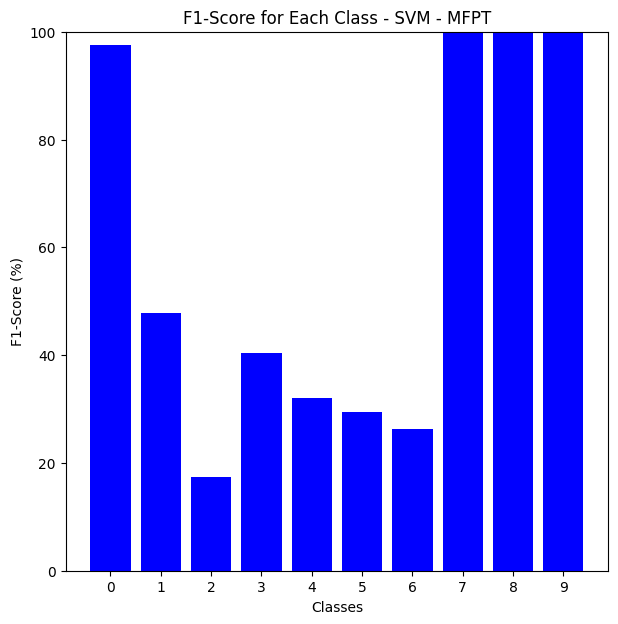

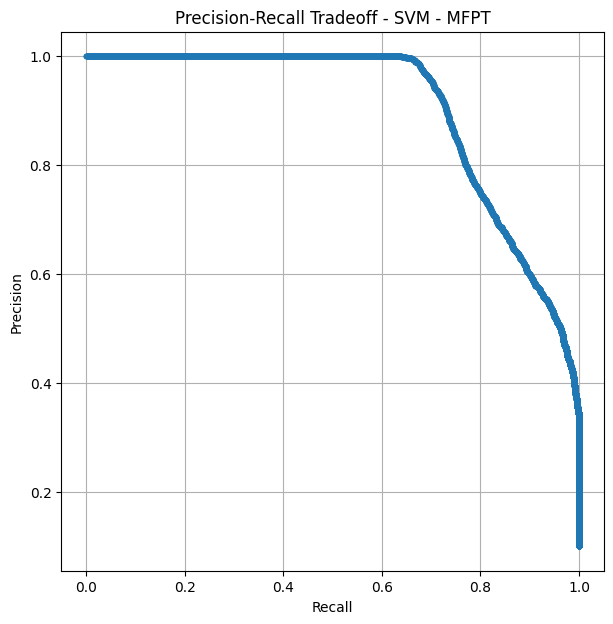

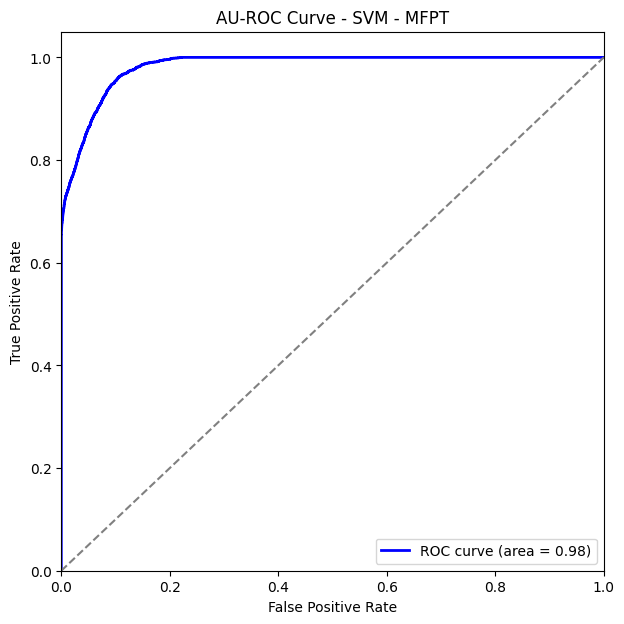

In [64]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - SVM Train - MFPT')
sns.heatmap(svm_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - SVM Test - MFPT')
sns.heatmap(svm_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - SVM'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - SVM - MFPT')
plt.bar([1, 2], [b_SVM_train_accuracy, b_SVM_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plot Recall for each class
plt.figure(figsize=(7, 7))
plt.title('Recall for SVM Test Data - MFPT')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - SVM - MFPT')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - SVM - MFPT')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - SVM - MFPT')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - SVM - MFPT')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Voting** **Classifier**

In [96]:
# Define a custom Keras wrapper class for scikit-learn
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, keras_model, num_classes):
        self.keras_model = keras_model
        self.num_classes = num_classes

    def fit(self, X, y):
        y_one_hot = np.eye(self.num_classes)[y]
        self.keras_model.fit(X, y_one_hot, epochs=10, batch_size=32, verbose=1)
        return self

    def predict(self, X):
        return np.argmax(self.keras_model.predict(X), axis=1)

    def predict_proba(self, X):
        return self.keras_model.predict(X)

# Assuming your Keras models are defined and compiled
b_rnn_wrapper = KerasClassifierWrapper(keras_model=Classification_b_RNN.model, num_classes=10)
b_lstm_wrapper = KerasClassifierWrapper(keras_model=b_Classification.model, num_classes=10)

# Initialize the Voting Classifier
start_time = time.time()
# Reshape and split your data
Input_1D = X.reshape([-1, 2000, 1])
X_train, X_test, y_train, y_test = train_test_split(Input_1D, Y_CNN, train_size=0.75, test_size=0.25, random_state=101)

# Flatten the data for traditional classifiers
X_train_flattened = X_train.reshape(len(X_train), -1)
X_test_flattened = X_test.reshape(len(X_test), -1)

# Ensure y_train and y_test are in the correct format (class indices)
y_train_indices = np.argmax(y_train, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

# Create the Voting Classifier
b_voting_clf = VotingClassifier(
    estimators=[
        ('rf', b_rf_model),
        ('gb', b_gb_model),
        ('rnn', b_rnn_wrapper),
        ('lstm', b_lstm_wrapper)
    ],
    voting='soft'  # Use 'soft' voting to average class probabilities
)

# Fit the Voting Classifier
b_voting_clf.fit(X_train_flattened, y_train_indices)

# Evaluate the Voting Classifier
b_voting_train_accuracy = b_voting_clf.score(X_train_flattened, y_train_indices) * 100
b_voting_test_accuracy = b_voting_clf.score(X_test_flattened, y_test_indices) * 100

print('Voting Classifier train accuracy - MFPT =', b_voting_train_accuracy)
print('Voting Classifier test accuracy - MFPT =', b_voting_test_accuracy)

end_time = time.time()
training_duration = end_time - start_time
print(f"Training time: {training_duration:.2f} seconds")

pickle.dump(b_voting_clf, open(r'C:\Users\ariad\Downloads\Fault Classification\MFPT/Models/b_voting_model', 'wb'))


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - accuracy: 0.9209 - loss: 1.0267
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.9525 - loss: 0.3600
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.9562 - loss: 0.2826
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.9692 - loss: 0.1827
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.9783 - loss: 0.1079
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.9858 - loss: 0.0734
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.9791 - loss: 0.1328
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.9800 - loss: 0.1476
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.9789 - loss: 0.1247
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.9795 - loss: 0.1382
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 266ms/step - accuracy: 0.9635 - loss: 0.1852
Epoch 2/10
313/313 ━

**Calculation of Performance metrics**

In [97]:
# Predict on test data with Voting Classifier
y_pred_proba = b_voting_clf.predict_proba(X_test_flattened)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
precision_avg = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
f1_avg = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

# Compute Recall
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
recall_avg = np.mean(recall_per_class) * 100

# AU-ROC
y_test_bin = label_binarize(y_true, classes=range(10))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Compute confusion matrices
voting_train_pred = b_voting_clf.predict(X_train_flattened)
voting_train_cm = confusion_matrix(np.argmax(y_1D_train, axis=1), voting_train_pred)
voting_test_cm = confusion_matrix(y_true, y_pred)

# Create DataFrame for class-wise metrics
metrics_data = {
    'Class Label': [f'Class {i}' for i in range(10)] + ['Average'],
    'Recall': [recall * 100 for recall in recall_per_class] + [recall_avg],
    'Precision': [precision[i] * 100 for i in range(10)] + [precision_avg],
    'F1-Score': [f1[i] * 100 for i in range(10)] + [f1_avg]
}
metrics_df = pd.DataFrame(metrics_data)
print("Class-wise Metrics for Voting Classifier - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

# Tabulate All Performance Metrics
metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Average Recall', 'Average Precision', 'Average F1-Score', 'ROC AUC'],
    'Value': [b_voting_train_accuracy,
              b_voting_test_accuracy,
              recall_avg, precision_avg, f1_avg, roc_auc]
}
b_v_train_accuracy = b_voting_train_accuracy
b_v_test_accuracy = b_voting_test_accuracy
b_v_recall_avg = recall_avg
b_v_precision_avg = precision_avg
b_v_f1_avg = f1_avg
b_v_roc_auc = roc_auc
metrics_df = pd.DataFrame(metrics)
print("\nOverall Performance Metrics for Voting Classifier - MFPT:")
print(metrics_df.to_string(index=False, float_format='{:,.6f}'.format))

105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step
Class-wise Metrics for Voting Classifier - MFPT:
Class Label     Recall  Precision   F1-Score
    Class 0 100.000000  96.587927  98.264352
    Class 1  77.368421  71.707317  74.430380
    Class 2  72.471910  77.710843  75.000000
    Class 3  55.208333  57.297297  56.233422
    Class 4  76.162791  68.229167  71.978022
    Class 5  54.189944  62.580645  58.083832
    Class 6  68.518519  77.083333  72.549020
    Class 7 100.000000 100.000000 100.000000
    Class 8 100.000000 100.000000 100.000000
    Class 9 100.000000 100.000000 100.000000
    Average  80.391992  81.119653  80.653903

Overall Performance Metrics for Voting Classifier - MFPT:
           Metric      Value
   Train Accuracy 100.000000
    Test Accuracy  96.764103
   Average Recall  80.391992
Average Precision  81.119653
 Average F1-Score  80.653903
      

**Plot results-Voting classifier**

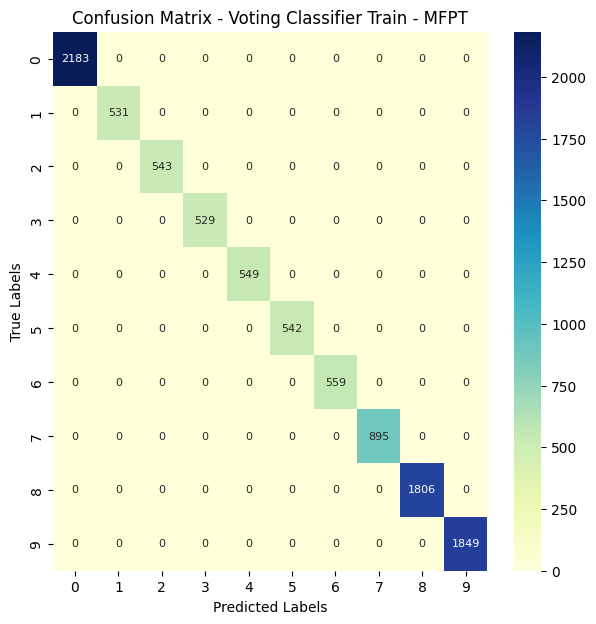

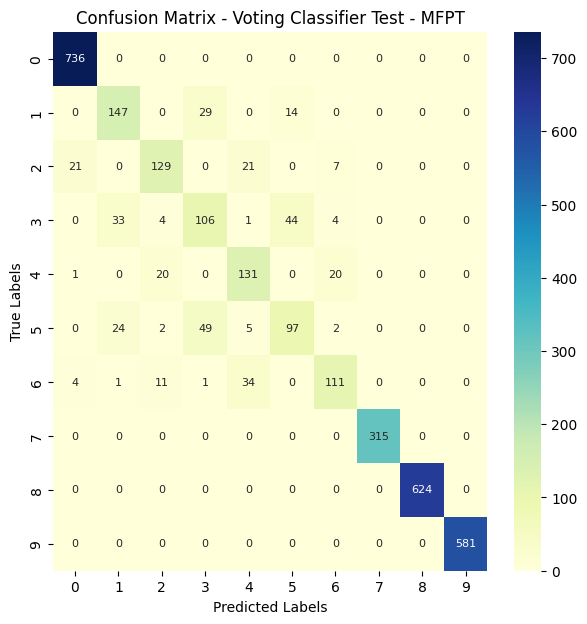

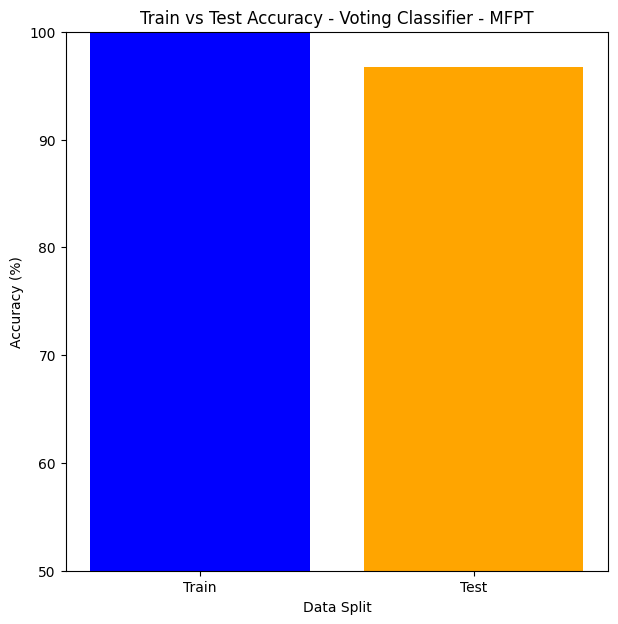

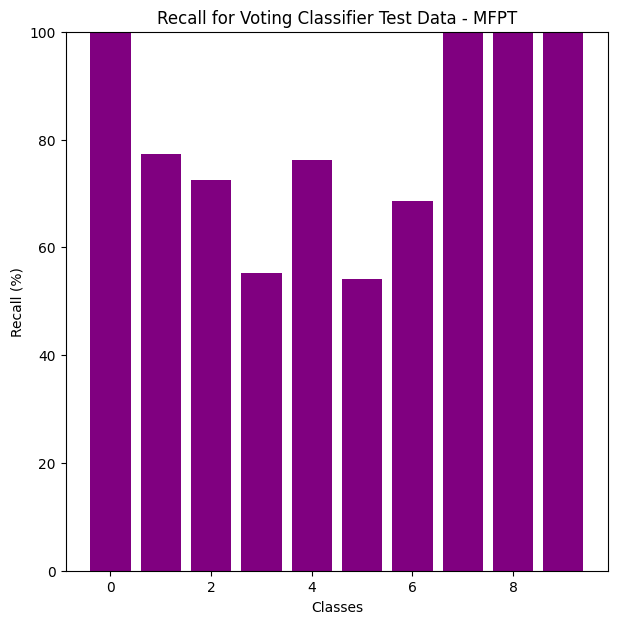

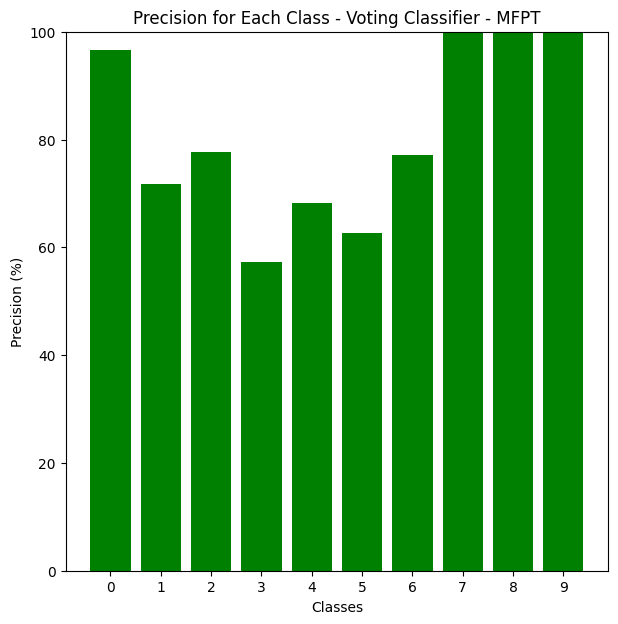

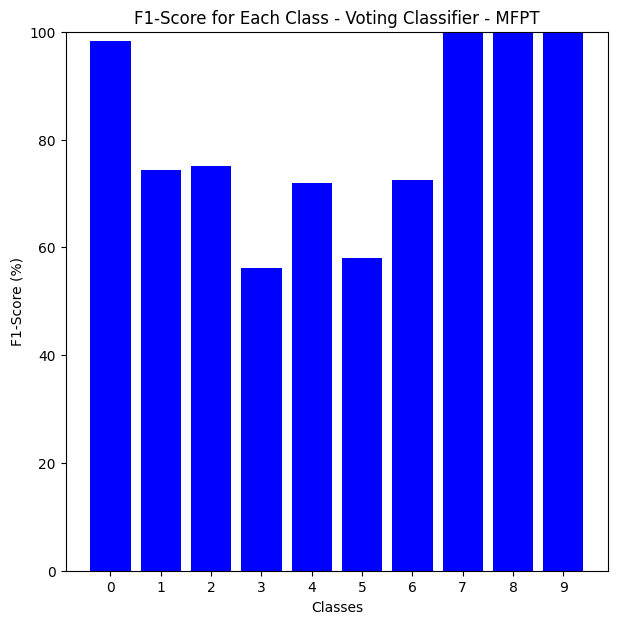

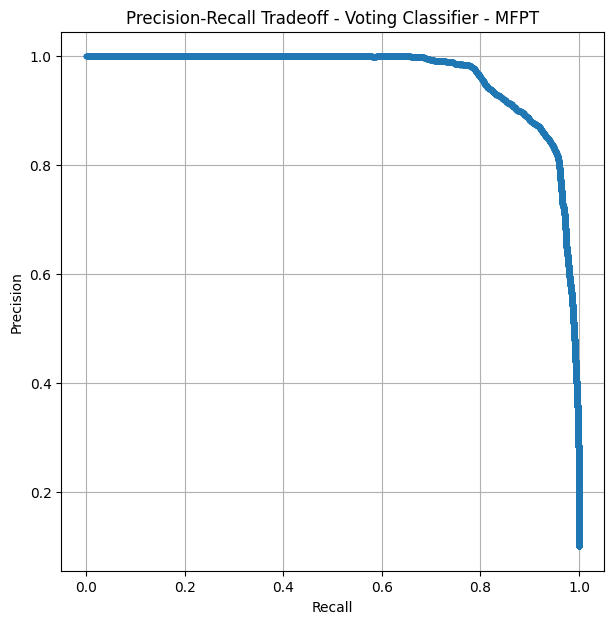

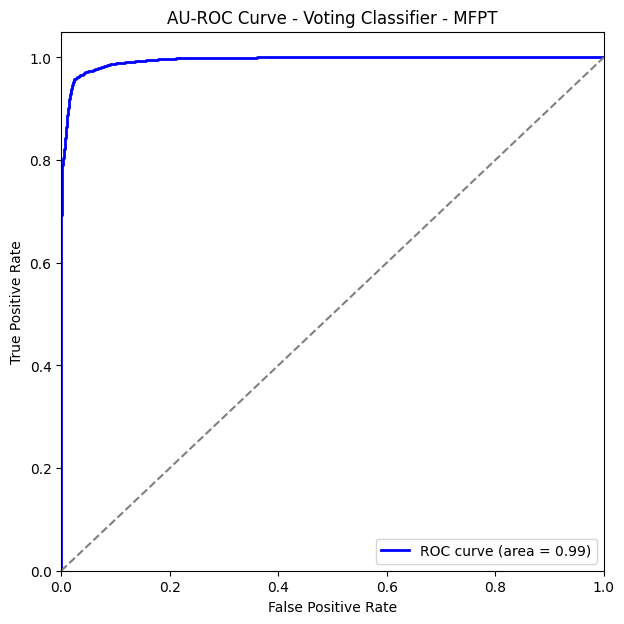

In [98]:
# Plot confusion matrix for train data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - Voting Classifier Train - MFPT')
sns.heatmap(voting_train_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(7, 7))
plt.title('Confusion Matrix - Voting Classifier Test - MFPT')
sns.heatmap(voting_test_cm, annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting 'Train vs Test Accuracy - Voting Classifier'
plt.figure(figsize=(7, 7))
plt.title('Train vs Test Accuracy - Voting Classifier - MFPT')
plt.bar([1, 2], [b_voting_train_accuracy, b_voting_test_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Data Split')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([50, 100])
plt.show()

# Plot Recall for each class
plt.figure(figsize=(7, 7))
plt.title('Recall for Voting Classifier Test Data - MFPT')
plt.bar(range(10), recall_per_class * 100, color='purple')
plt.ylabel('Recall (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.show()

# Plot Precision for each class
plt.figure(figsize=(7, 7))
plt.title('Precision for Each Class - Voting Classifier - MFPT')
plt.bar(range(10), precision * 100, color='green')
plt.ylabel('Precision (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(7, 7))
plt.title('F1-Score for Each Class - Voting Classifier - MFPT')
plt.bar(range(10), f1 * 100, color='blue')
plt.ylabel('F1-Score (%)')
plt.xlabel('Classes')
plt.ylim([0, 100])
plt.xticks(range(10))
plt.show()

# Plot Precision-Recall Tradeoff (Overall)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(7, 7))
plt.title('Precision-Recall Tradeoff - Voting Classifier - MFPT')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Plot AU-ROC Curve
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Curve - Voting Classifier - MFPT')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**COMPARISON OF MODELS**

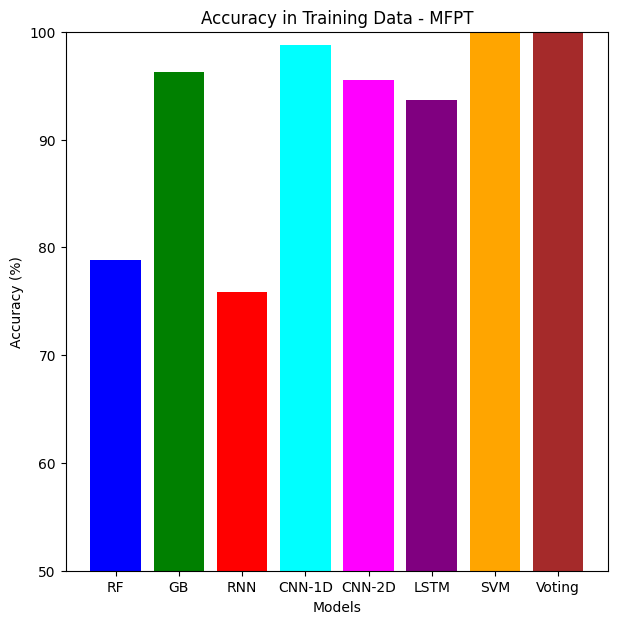

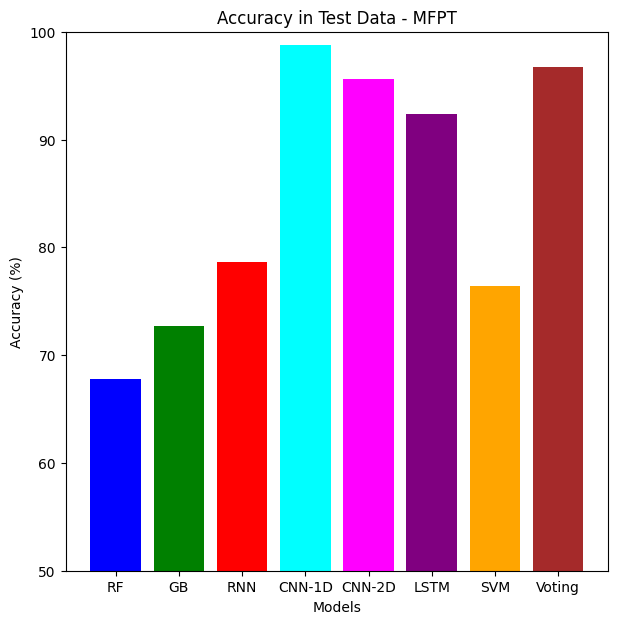

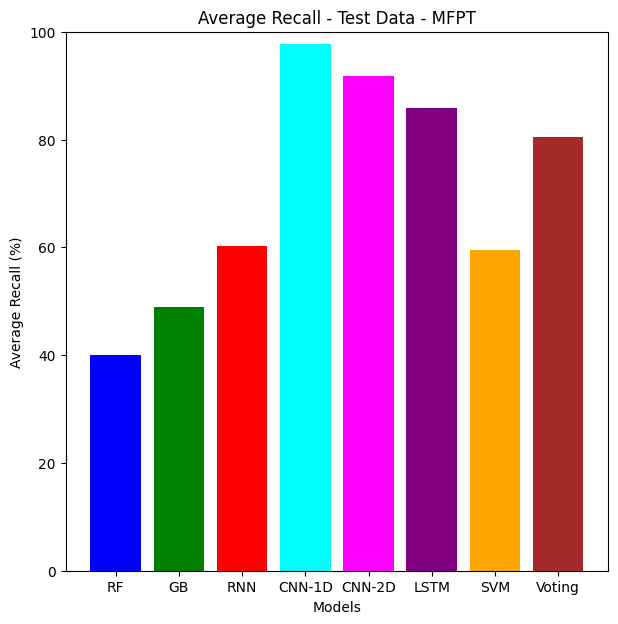

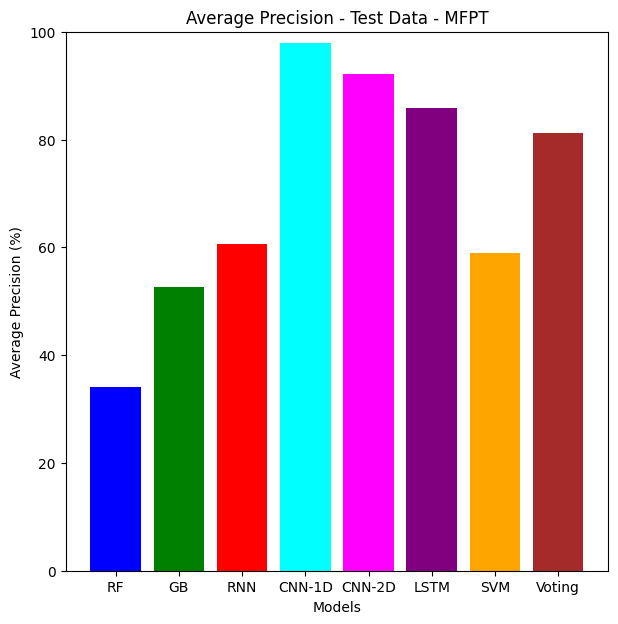

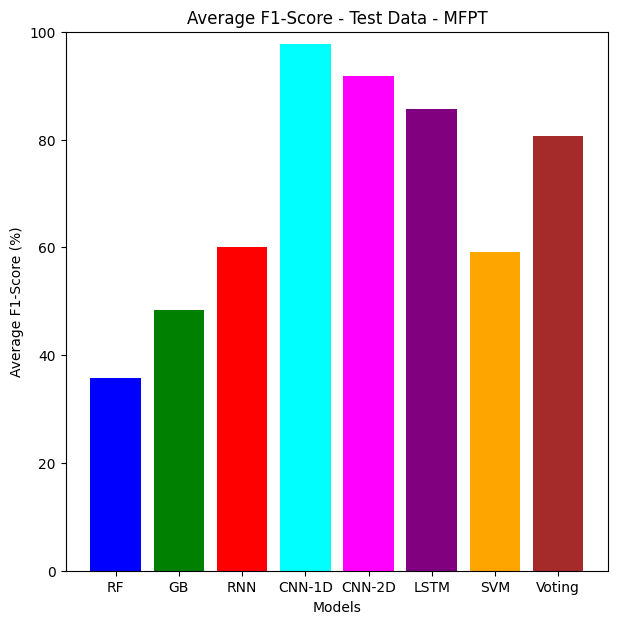

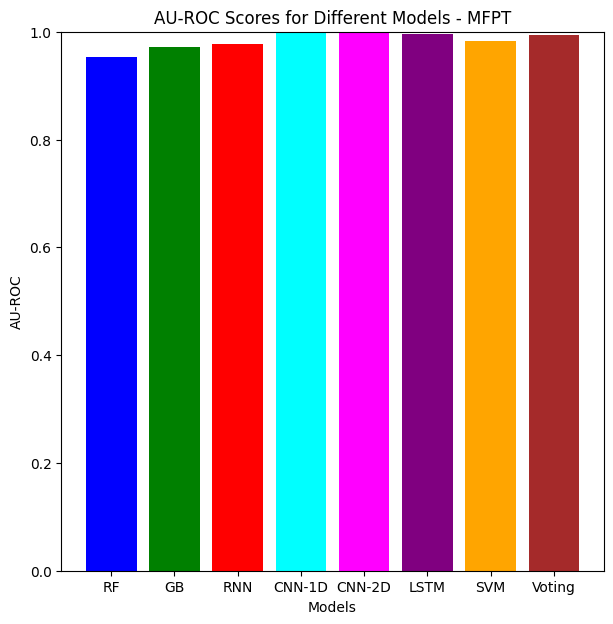

In [99]:
# Define the metrics for each model including Voting Classifier
metrics_mfpt = {
    'RF': {
        'Train Accuracy': b_rf_train_accuracy,
        'Test Accuracy': b_rf_test_accuracy,
        'Average Recall': b_rf_recall_avg,
        'Average Precision': b_rf_precision_avg,
        'Average F1-Score': b_rf_f1_avg,
        'AU-ROC': b_rf_roc_auc
    },
    'GB': {
        'Train Accuracy': b_gb_train_accuracy,
        'Test Accuracy': b_gb_test_accuracy,
        'Average Recall': b_gb_recall_avg,
        'Average Precision': b_gb_precision_avg,
        'Average F1-Score': b_gb_f1_avg,
        'AU-ROC': b_gb_roc_auc
    },
    'RNN': {
        'Train Accuracy': b_RNN_train_accuracy,
        'Test Accuracy': b_RNN_test_accuracy,
        'Average Recall': b_recall_RNN_avg,
        'Average Precision': b_precision_RNN_avg,
        'Average F1-Score': b_f1_RNN_avg,
        'AU-ROC': b_roc_auc_RNN
    },
    'CNN-1D': {
        'Train Accuracy': b_CNN_1D_train_accuracy,
        'Test Accuracy': b_CNN_1D_test_accuracy,
        'Average Recall': b_recall_CNN_1D_avg,
        'Average Precision': b_precision_CNN_1D_avg,
        'Average F1-Score': b_f1_CNN_1D_avg,
        'AU-ROC': b_roc_auc_CNN_1D
    },
    'CNN-2D': {
        'Train Accuracy': b_CNN_2D_train_accuracy,
        'Test Accuracy': b_CNN_2D_test_accuracy,
        'Average Recall': b_recall_CNN_2D_avg,
        'Average Precision': b_precision_CNN_2D_avg,
        'Average F1-Score': b_f1_CNN_2D_avg,
        'AU-ROC': b_roc_auc_CNN_2D
    },
    'LSTM': {
        'Train Accuracy': b_LSTM_train_accuracy,
        'Test Accuracy': b_LSTM_test_accuracy,
        'Average Recall': b_recall_LSTM_avg,
        'Average Precision': b_precision_LSTM_avg,
        'Average F1-Score': b_f1_LSTM_avg,
        'AU-ROC': b_roc_auc_LSTM
    },
    'SVM': {
        'Train Accuracy': b_SVM_train_accuracy,
        'Test Accuracy': b_SVM_test_accuracy,
        'Average Recall': b_SVM_recall_avg,
        'Average Precision': b_SVM_precision_avg,
        'Average F1-Score': b_SVM_f1_avg,
        'AU-ROC': b_SVM_roc_auc
    },
    'Voting': {
        'Train Accuracy': b_voting_train_accuracy,
        'Test Accuracy': b_voting_test_accuracy,
        'Average Recall': b_v_recall_avg,
        'Average Precision': b_v_precision_avg,
        'Average F1-Score': b_v_f1_avg,
        'AU-ROC': b_v_roc_auc
    }
}

# Plot Accuracy in Training Data
plt.figure(figsize=(7, 7))
plt.title('Accuracy in Training Data - MFPT')
plt.bar(metrics_mfpt.keys(), [metrics_mfpt[model]['Train Accuracy'] for model in metrics_mfpt], color=['blue', 'green', 'red', 'cyan', 'magenta', 'purple', 'orange', 'brown'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Models')
plt.ylim([50, 100])
plt.show()

# Plot Accuracy in Test Data
plt.figure(figsize=(7, 7))
plt.title('Accuracy in Test Data - MFPT')
plt.bar(metrics_mfpt.keys(), [metrics_mfpt[model]['Test Accuracy'] for model in metrics_mfpt], color=['blue', 'green', 'red', 'cyan', 'magenta', 'purple', 'orange', 'brown'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Models')
plt.ylim([50, 100])
plt.show()

# Plot Average Recall - Test Data
plt.figure(figsize=(7, 7))
plt.title('Average Recall - Test Data - MFPT')
plt.bar(metrics_mfpt.keys(), [metrics_mfpt[model]['Average Recall'] for model in metrics_mfpt], color=['blue', 'green', 'red', 'cyan', 'magenta', 'purple', 'orange', 'brown'])
plt.ylabel('Average Recall (%)')
plt.xlabel('Models')
plt.ylim([0, 100])
plt.show()

# Plot Average Precision - Test Data
plt.figure(figsize=(7, 7))
plt.title('Average Precision - Test Data - MFPT')
plt.bar(metrics_mfpt.keys(), [metrics_mfpt[model]['Average Precision'] for model in metrics_mfpt], color=['blue', 'green', 'red', 'cyan', 'magenta', 'purple', 'orange', 'brown'])
plt.ylabel('Average Precision (%)')
plt.xlabel('Models')
plt.ylim([0, 100])
plt.show()

# Plot Average F1-Score - Test Data
plt.figure(figsize=(7, 7))
plt.title('Average F1-Score - Test Data - MFPT')
plt.bar(metrics_mfpt.keys(), [metrics_mfpt[model]['Average F1-Score'] for model in metrics_mfpt], color=['blue', 'green', 'red', 'cyan', 'magenta', 'purple', 'orange', 'brown'])
plt.ylabel('Average F1-Score (%)')
plt.xlabel('Models')
plt.ylim([0, 100])
plt.show()

# Plot AU-ROC Scores
plt.figure(figsize=(7, 7))
plt.title('AU-ROC Scores for Different Models - MFPT')
plt.bar(metrics_mfpt.keys(), [metrics_mfpt[model]['AU-ROC'] for model in metrics_mfpt], color=['blue', 'green', 'red', 'cyan', 'magenta', 'purple', 'orange', 'brown'])
plt.ylabel('AU-ROC')
plt.xlabel('Models')
plt.ylim([0, 1])
plt.show()

**Comparison of Datasets**

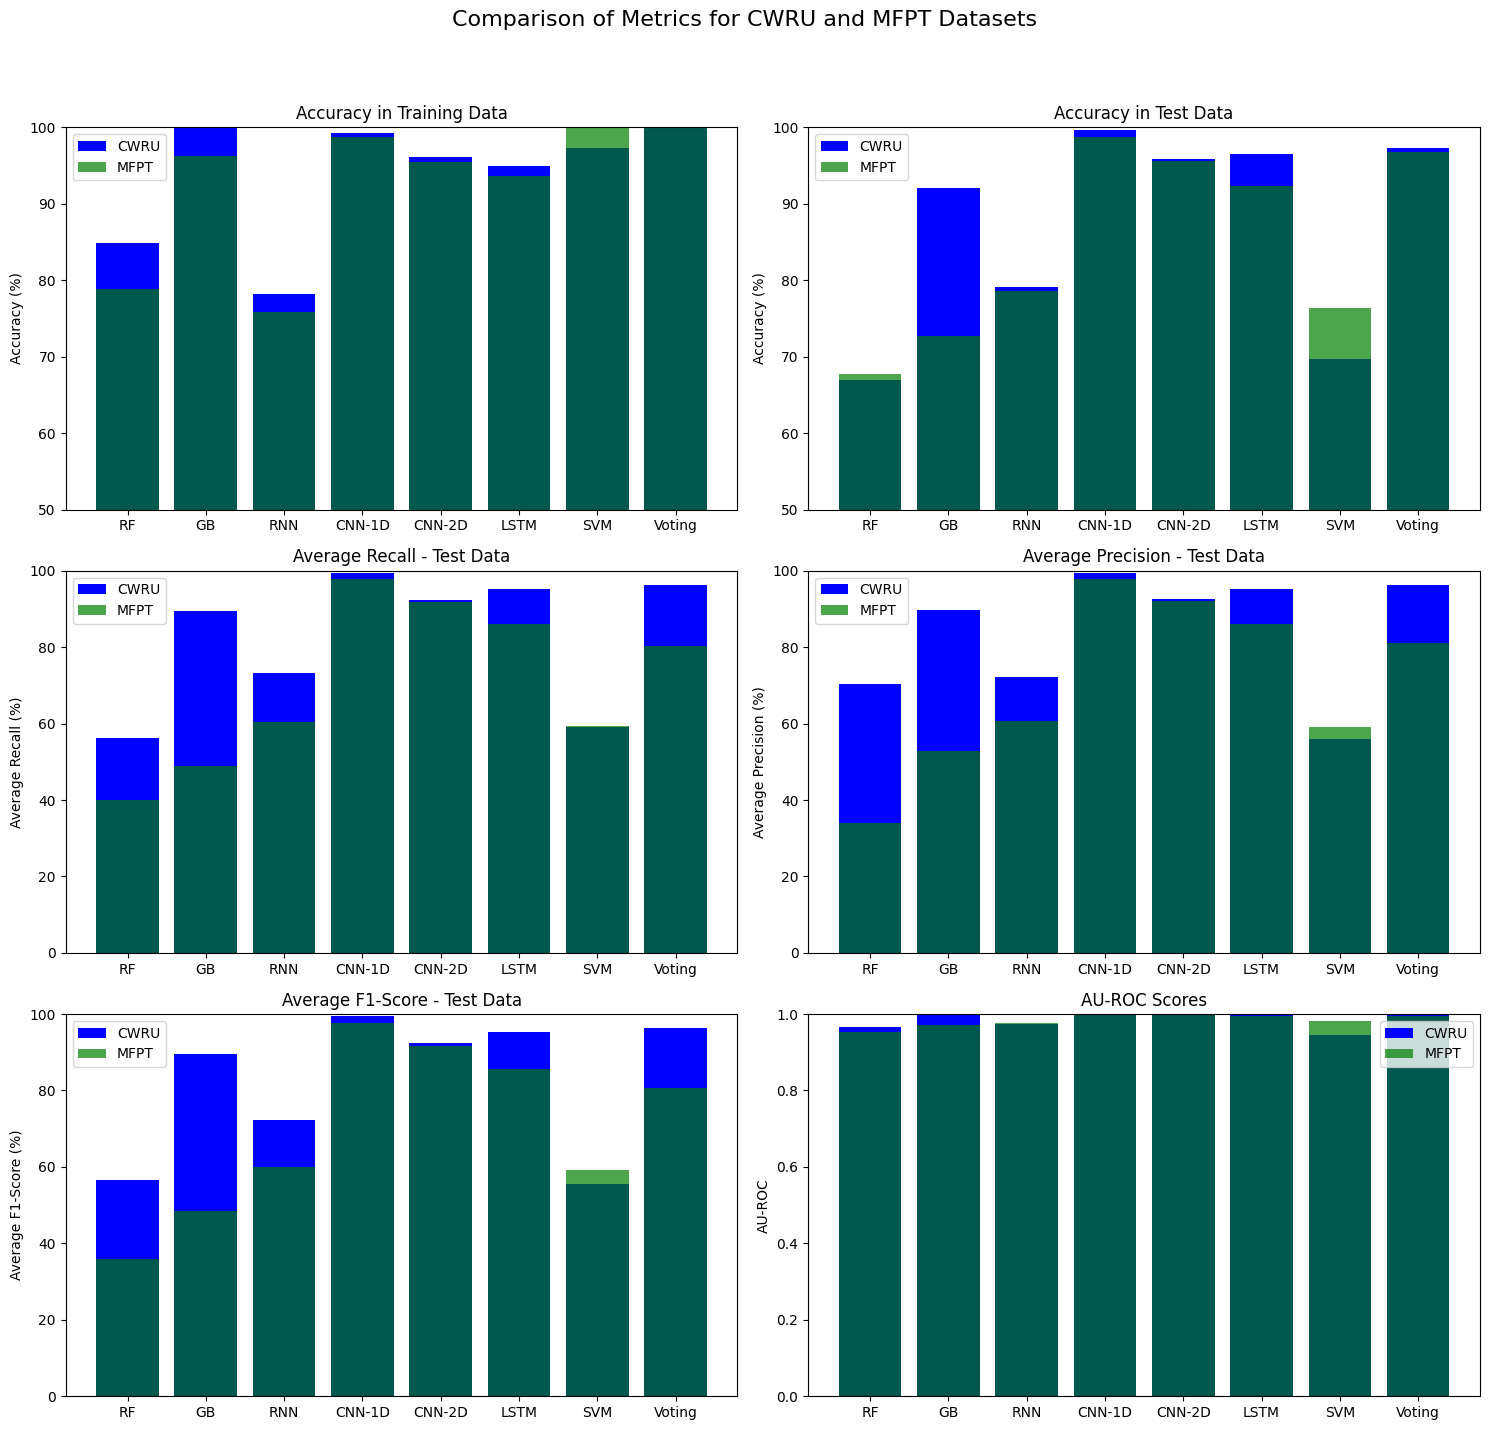

In [100]:
# Set up subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Comparison of Metrics for CWRU and MFPT Datasets', fontsize=16)

# Plot Accuracy in Training Data
axes[0, 0].bar(metrics_cwru.keys(), [metrics_cwru[model]['Train Accuracy'] for model in metrics_cwru], color='blue', label='CWRU')
axes[0, 0].bar(metrics_mfpt.keys(), [metrics_mfpt[model]['Train Accuracy'] for model in metrics_mfpt], color='green', alpha=0.7, label='MFPT')
axes[0, 0].set_title('Accuracy in Training Data')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim([50, 100])
axes[0, 0].legend()

# Plot Accuracy in Test Data
axes[0, 1].bar(metrics_cwru.keys(), [metrics_cwru[model]['Test Accuracy'] for model in metrics_cwru], color='blue', label='CWRU')
axes[0, 1].bar(metrics_mfpt.keys(), [metrics_mfpt[model]['Test Accuracy'] for model in metrics_mfpt], color='green', alpha=0.7, label='MFPT')
axes[0, 1].set_title('Accuracy in Test Data')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_ylim([50, 100])
axes[0, 1].legend()

# Plot Average Recall - Test Data
axes[1, 0].bar(metrics_cwru.keys(), [metrics_cwru[model]['Average Recall'] for model in metrics_cwru], color='blue', label='CWRU')
axes[1, 0].bar(metrics_mfpt.keys(), [metrics_mfpt[model]['Average Recall'] for model in metrics_mfpt], color='green', alpha=0.7, label='MFPT')
axes[1, 0].set_title('Average Recall - Test Data')
axes[1, 0].set_ylabel('Average Recall (%)')
axes[1, 0].set_ylim([0, 100])
axes[1, 0].legend()

# Plot Average Precision - Test Data
axes[1, 1].bar(metrics_cwru.keys(), [metrics_cwru[model]['Average Precision'] for model in metrics_cwru], color='blue', label='CWRU')
axes[1, 1].bar(metrics_mfpt.keys(), [metrics_mfpt[model]['Average Precision'] for model in metrics_mfpt], color='green', alpha=0.7, label='MFPT')
axes[1, 1].set_title('Average Precision - Test Data')
axes[1, 1].set_ylabel('Average Precision (%)')
axes[1, 1].set_ylim([0, 100])
axes[1, 1].legend()

# Plot Average F1-Score - Test Data
axes[2, 0].bar(metrics_cwru.keys(), [metrics_cwru[model]['Average F1-Score'] for model in metrics_cwru], color='blue', label='CWRU')
axes[2, 0].bar(metrics_mfpt.keys(), [metrics_mfpt[model]['Average F1-Score'] for model in metrics_mfpt], color='green', alpha=0.7, label='MFPT')
axes[2, 0].set_title('Average F1-Score - Test Data')
axes[2, 0].set_ylabel('Average F1-Score (%)')
axes[2, 0].set_ylim([0, 100])
axes[2, 0].legend()

# Plot AU-ROC Scores
axes[2, 1].bar(metrics_cwru.keys(), [metrics_cwru[model]['AU-ROC'] for model in metrics_cwru], color='blue', label='CWRU')
axes[2, 1].bar(metrics_mfpt.keys(), [metrics_mfpt[model]['AU-ROC'] for model in metrics_mfpt], color='green', alpha=0.7, label='MFPT')
axes[2, 1].set_title('AU-ROC Scores')
axes[2, 1].set_ylabel('AU-ROC')
axes[2, 1].set_ylim([0, 1])
axes[2, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

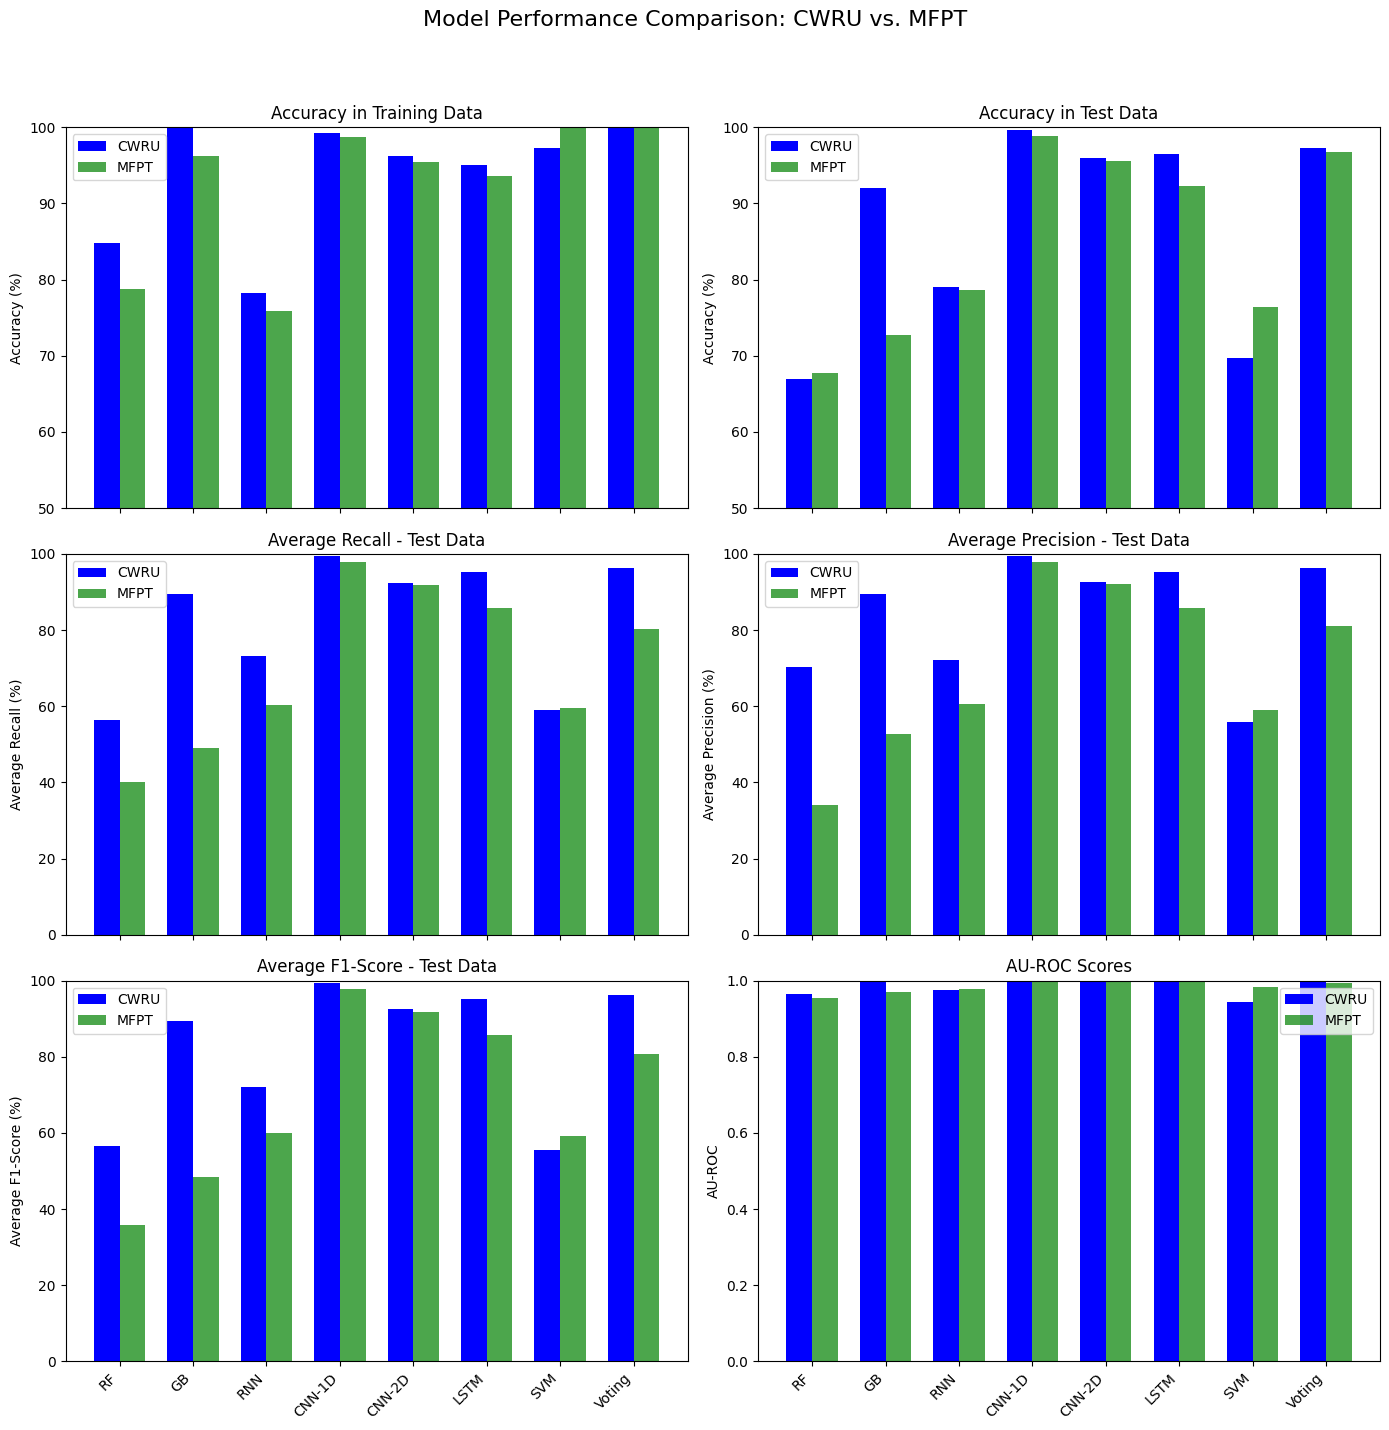

In [101]:
# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 15), sharex=True)
fig.suptitle('Model Performance Comparison: CWRU vs. MFPT', fontsize=16)

models = list(metrics_cwru.keys()) 
x = np.arange(len(models))  # Model positions on x-axis
width = 0.35  # Width of the bars

# Plot Accuracy in Training Data
axes[0, 0].bar(x - width/2, [metrics_cwru[model]['Train Accuracy'] for model in models], width, color='blue', label='CWRU')
axes[0, 0].bar(x + width/2, [metrics_mfpt[model]['Train Accuracy'] for model in models], width, color='green', alpha=0.7, label='MFPT')
axes[0, 0].set_title('Accuracy in Training Data')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim([50, 100])
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].legend()

# Plot Accuracy in Test Data
axes[0, 1].bar(x - width/2, [metrics_cwru[model]['Test Accuracy'] for model in models], width, color='blue', label='CWRU')
axes[0, 1].bar(x + width/2, [metrics_mfpt[model]['Test Accuracy'] for model in models], width, color='green', alpha=0.7, label='MFPT')
axes[0, 1].set_title('Accuracy in Test Data')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_ylim([50, 100])
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].legend()

# Plot Average Recall - Test Data
axes[1, 0].bar(x - width/2, [metrics_cwru[model]['Average Recall'] for model in models], width, color='blue', label='CWRU')
axes[1, 0].bar(x + width/2, [metrics_mfpt[model]['Average Recall'] for model in models], width, color='green', alpha=0.7, label='MFPT')
axes[1, 0].set_title('Average Recall - Test Data')
axes[1, 0].set_ylabel('Average Recall (%)')
axes[1, 0].set_ylim([0, 100])
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
axes[1, 0].legend()

# Plot Average Precision - Test Data
axes[1, 1].bar(x - width/2, [metrics_cwru[model]['Average Precision'] for model in models], width, color='blue', label='CWRU')
axes[1, 1].bar(x + width/2, [metrics_mfpt[model]['Average Precision'] for model in models], width, color='green', alpha=0.7, label='MFPT')
axes[1, 1].set_title('Average Precision - Test Data')
axes[1, 1].set_ylabel('Average Precision (%)')
axes[1, 1].set_ylim([0, 100])
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models, rotation=45, ha='right')
axes[1, 1].legend()

# Plot Average F1-Score - Test Data
axes[2, 0].bar(x - width/2, [metrics_cwru[model]['Average F1-Score'] for model in models], width, color='blue', label='CWRU')
axes[2, 0].bar(x + width/2, [metrics_mfpt[model]['Average F1-Score'] for model in models], width, color='green', alpha=0.7, label='MFPT')
axes[2, 0].set_title('Average F1-Score - Test Data')
axes[2, 0].set_ylabel('Average F1-Score (%)')
axes[2, 0].set_ylim([0, 100])
axes[2, 0].set_xticks(x)
axes[2, 0].set_xticklabels(models, rotation=45, ha='right')
axes[2, 0].legend()

# Plot AU-ROC Scores
axes[2, 1].bar(x - width/2, [metrics_cwru[model]['AU-ROC'] for model in models], width, color='blue', label='CWRU')
axes[2, 1].bar(x + width/2, [metrics_mfpt[model]['AU-ROC'] for model in models], width, color='green', alpha=0.7, label='MFPT')
axes[2, 1].set_title('AU-ROC Scores')
axes[2, 1].set_ylabel('AU-ROC')
axes[2, 1].set_ylim([0, 1])
axes[2, 1].set_xticks(x)
axes[2, 1].set_xticklabels(models, rotation=45, ha='right')
axes[2, 1].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

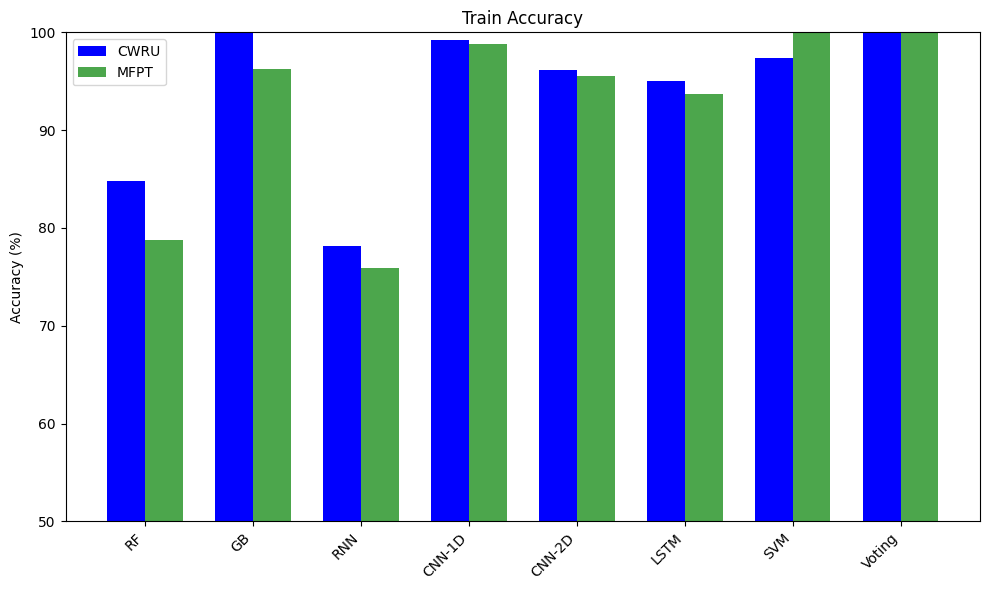

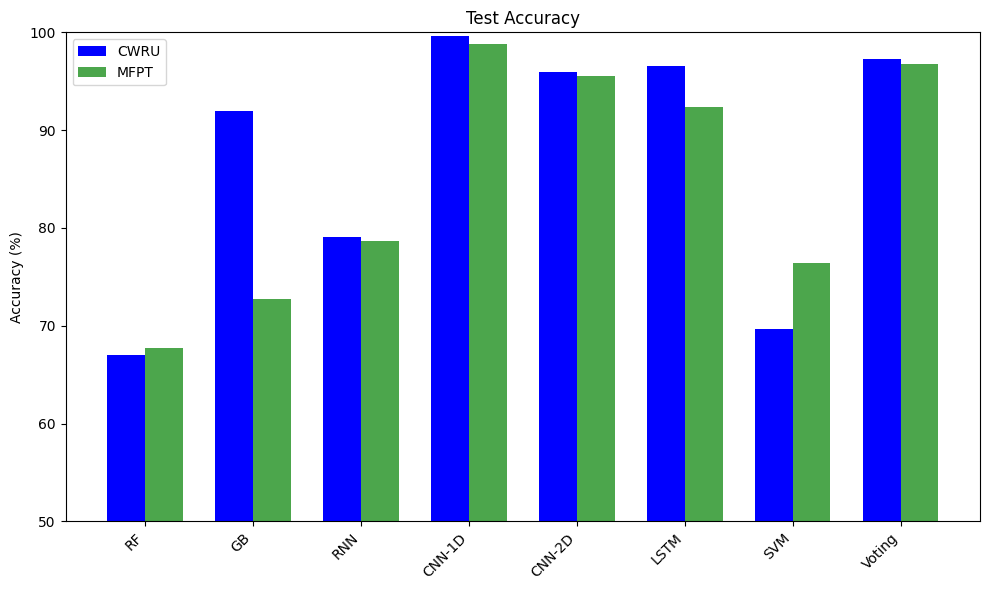

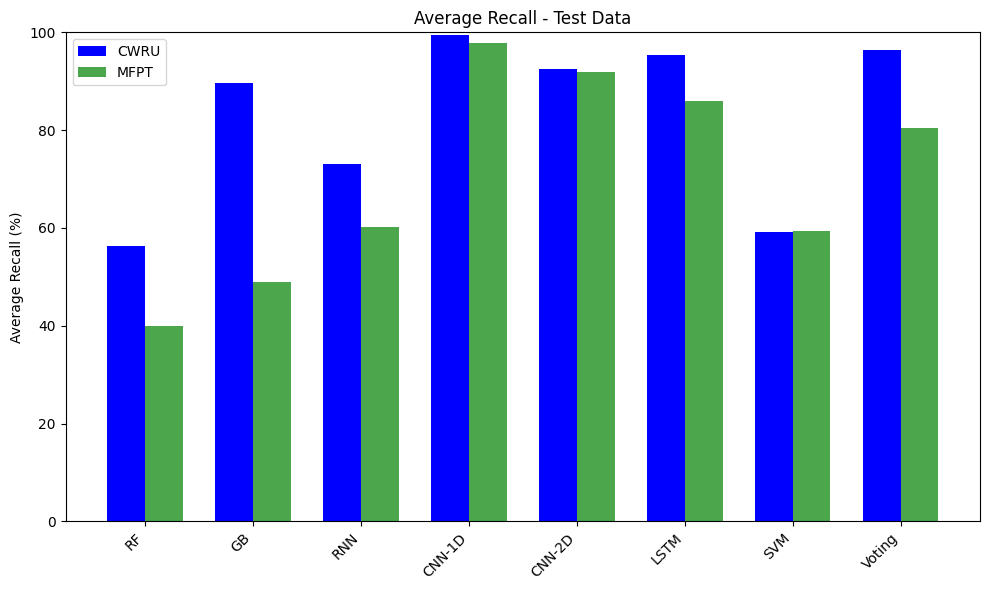

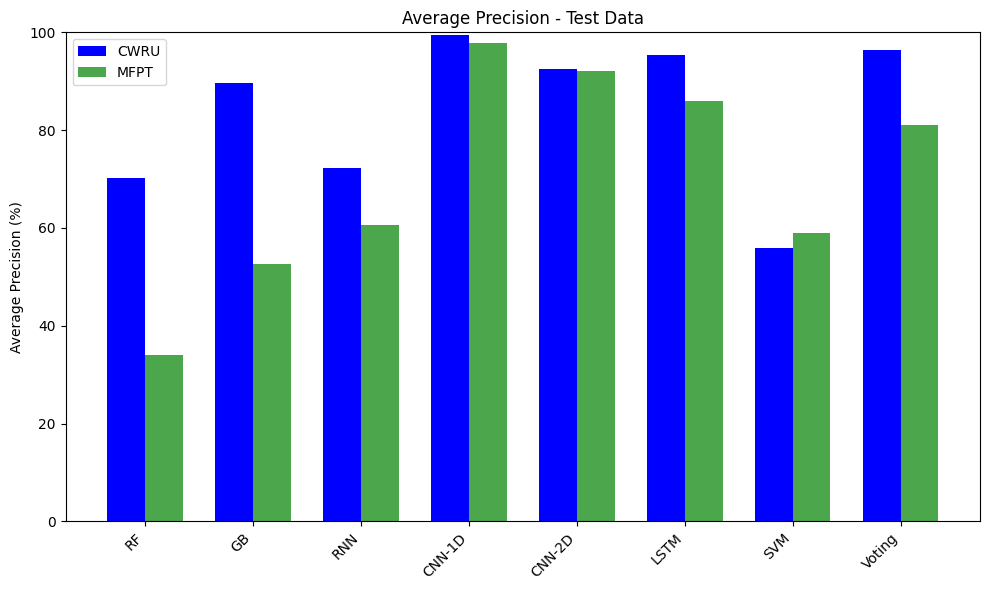

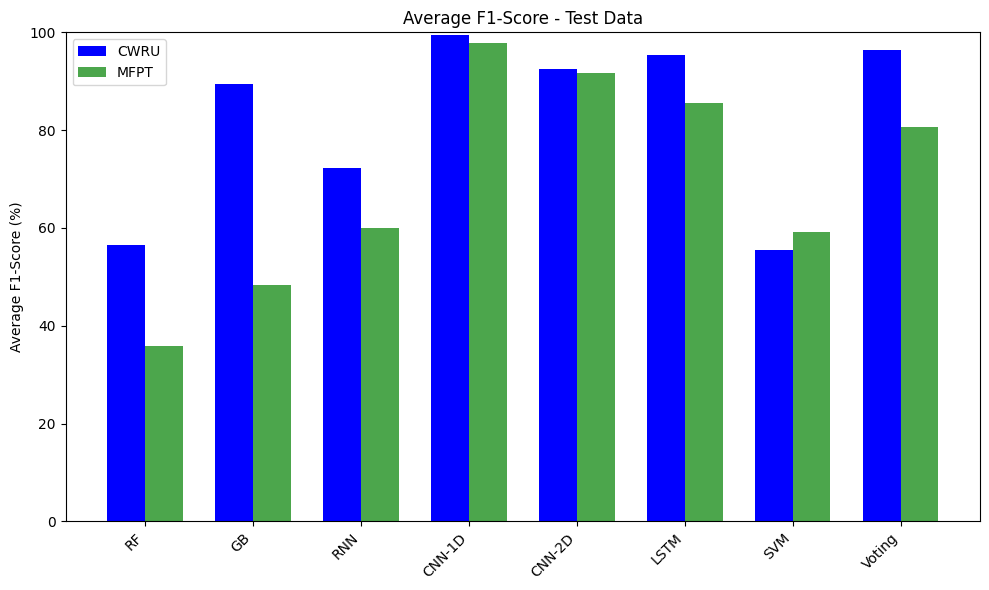

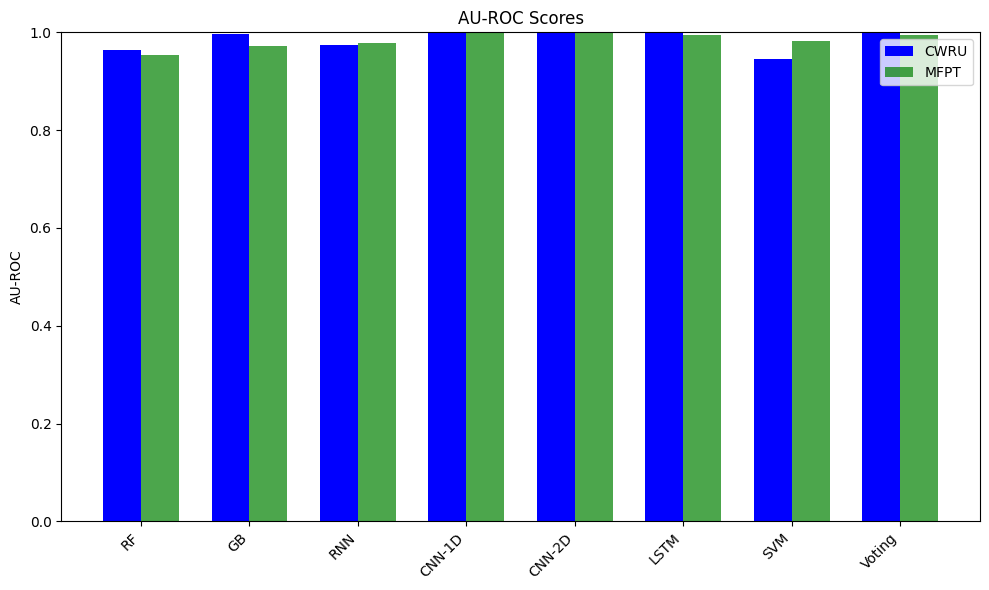

In [102]:
figsize = (10, 6)

# Train Accuracy
plt.figure(figsize=figsize)
plt.bar(x - width/2, [metrics_cwru[model]['Train Accuracy'] for model in models], width, color='blue', label='CWRU')
plt.bar(x + width/2, [metrics_mfpt[model]['Train Accuracy'] for model in models], width, color='green', alpha=0.7, label='MFPT')
plt.title('Train Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim([50, 100])
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Test Accuracy
plt.figure(figsize=figsize)
plt.bar(x - width/2, [metrics_cwru[model]['Test Accuracy'] for model in models], width, color='blue', label='CWRU')
plt.bar(x + width/2, [metrics_mfpt[model]['Test Accuracy'] for model in models], width, color='green', alpha=0.7, label='MFPT')
plt.title('Test Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim([50, 100])
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Average Recall
plt.figure(figsize=figsize)
plt.bar(x - width/2, [metrics_cwru[model]['Average Recall'] for model in models], width, color='blue', label='CWRU')
plt.bar(x + width/2, [metrics_mfpt[model]['Average Recall'] for model in models], width, color='green', alpha=0.7, label='MFPT')
plt.title('Average Recall - Test Data')
plt.ylabel('Average Recall (%)')
plt.ylim([0, 100])
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Average Precision
plt.figure(figsize=figsize)
plt.bar(x - width/2, [metrics_cwru[model]['Average Precision'] for model in models], width, color='blue', label='CWRU')
plt.bar(x + width/2, [metrics_mfpt[model]['Average Precision'] for model in models], width, color='green', alpha=0.7, label='MFPT')
plt.title('Average Precision - Test Data')
plt.ylabel('Average Precision (%)')
plt.ylim([0, 100])
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Average F1-Score
plt.figure(figsize=figsize)
plt.bar(x - width/2, [metrics_cwru[model]['Average F1-Score'] for model in models], width, color='blue', label='CWRU')
plt.bar(x + width/2, [metrics_mfpt[model]['Average F1-Score'] for model in models], width, color='green', alpha=0.7, label='MFPT')
plt.title('Average F1-Score - Test Data')
plt.ylabel('Average F1-Score (%)')
plt.ylim([0, 100])
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# AU-ROC
plt.figure(figsize=figsize)
plt.bar(x - width/2, [metrics_cwru[model]['AU-ROC'] for model in models], width, color='blue', label='CWRU')
plt.bar(x + width/2, [metrics_mfpt[model]['AU-ROC'] for model in models], width, color='green', alpha=0.7, label='MFPT')
plt.title('AU-ROC Scores')
plt.ylabel('AU-ROC')
plt.ylim([0, 1])
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
